# 一、导入库

In [8]:
import os
import math
import time
import joblib
import pickle
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.layers import Layer
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import GRU, Dense,Conv1D, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM,Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score

import tensorflow as tf
from tensorflow.keras  import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D,
    Dense, Dropout, Flatten, TimeDistributed, LayerNormalization, BatchNormalization, Attention
)

%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'     #显示中文
plt.rcParams ['axes.unicode_minus']=False     #显示负号

# 二、数据处理

## 2.1 数据读取

In [9]:
data0=pd.read_csv('沪深300期货历史数据2.csv',parse_dates=['日期']).set_index('日期')[['开盘','高','低','收盘']].sort_index()
data0=data0.astype('float')
data0.tail()

开盘       高       低      收盘
日期                                        
2025-01-14  3725.0  3833.8  3721.8  3819.6
2025-01-15  3816.4  3817.2  3788.4  3795.2
2025-01-16  3806.2  3849.6  3774.2  3795.0
2025-01-17  3786.8  3830.0  3777.6  3818.6
2025-01-20  3832.0  3862.2  3819.6  3829.0

## 2.2 数据处理（填充空缺）

In [10]:
    # 读取CSV文件，自动检测文件编码
    file_path = '沪深300期货历史数据2.csv'
    df = pd.read_csv(file_path, encoding='utf-8-sig')

    # 将日期列转换为日期时间类型
    df['日期'] = pd.to_datetime(df['日期'])

    # 设置日期列为索引
    df.set_index('日期', inplace=True)

    # 创建一个完整的日期范围
    start_date = df.index.min()
    end_date = df.index.max()
    full_date_range = pd.date_range(start=start_date, end=end_date)

    # 重新索引数据集，使日期连续
    df = df.reindex(full_date_range)

    # 定义均值插补函数
    def mean_imputation(df, col_name):
        column = df[col_name]
        for i in range(len(column)):
            if pd.isna(column.iloc[i]):
                # 找到前后非缺失值的索引
                prev_index = i - 1
                next_index = i + 1
                while prev_index >= 0 and pd.isna(column.iloc[prev_index]):
                    prev_index -= 1
                while next_index < len(column) and pd.isna(column.iloc[next_index]):
                    next_index += 1
                # 如果前后都有非缺失值，则计算均值填充
                if prev_index >= 0 and next_index < len(column):
                    df.loc[column.index[i], col_name] = (column.iloc[prev_index] + column.iloc[next_index]) / 2
        return df

    # 对除交易量和涨跌幅外的列进行均值插补
    columns_to_impute = ['收盘', '开盘', '高', '低']
    for column in columns_to_impute:
        df = mean_imputation(df, column)

    # 处理交易量列，将带有K的数据转换为数值类型
    def convert_volume(volume):
        if isinstance(volume, str):
            if volume.endswith('K'):
                return float(volume[:-1]) * 1000
        return pd.to_numeric(volume, errors='coerce')

    df['交易量'] = df['交易量'].apply(convert_volume)

    # 计算平均交易量并填充缺失值
    average_volume = df['交易量'].dropna().mean()
    df['交易量'].fillna(average_volume, inplace=True)

    # 计算涨跌幅并填充缺失值
    df['涨跌幅'] = df['收盘'].pct_change()
    # 第一个涨跌幅值填充为0
    df['涨跌幅'].fillna(0, inplace=True)
    # 将涨跌幅精确到小数点后2位
    df['涨跌幅'] = df['涨跌幅'].round(2)

    # 重置索引
    df.reset_index(inplace=True)
    df.rename(columns={'index': '日期'}, inplace=True)

    # 保存处理后的数据，保持与源文件相同的编码
    df.to_csv('沪深300期货历史数据2_处理后.csv', index=False, encoding='utf-8-sig')


In [11]:
data0=pd.read_csv('沪深300期货历史数据2_处理后.csv',parse_dates=['日期']).set_index('日期')[['开盘','高','低','收盘']].sort_index()
data0=data0.astype('float')
data0.tail()

开盘        高       低      收盘
日期                                         
2025-01-16  3806.2  3849.60  3774.2  3795.0
2025-01-17  3786.8  3830.00  3777.6  3818.6
2025-01-18  3809.4  3846.10  3798.6  3823.8
2025-01-19  3820.7  3854.15  3809.1  3826.4
2025-01-20  3832.0  3862.20  3819.6  3829.0

In [12]:
# # 加载新数据
# data0 = pd.read_csv('沪深300期货历史数据 (7).csv')

# # 数据格式转换
# data0['日期'] =data0['日期'].str.replace('-', '/')

# # 去除收盘、开盘、高、低列中的逗号
# columns_to_clean = ['收盘', '开盘', '高', '低']
# for col in columns_to_clean:
#     data0[col] = data0[col].str.replace(',', '').astype(float)

# # 去除涨跌幅列的百分号并转换为小数
# data0['涨跌幅'] = data0['涨跌幅'].str.rstrip('%').astype(float) / 100

# # 去除交易量列的 'K' 并转换为数值
# data0['交易量'] = data0['交易量'].str.rstrip('K').astype(float) * 1000

# # 设置日期索引并排序
# data0 = data0.set_index('日期')[['开盘', '高', '低', '收盘']].sort_index().astype('float')
# data0.tail()

## 2.3 构建训练集和测试集

In [13]:
def build_sequences(text, window_size=9):
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]
        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
 
def get_traintest(data,train_ratio=0.8,window_size=9):
    train_size=int(len(data)*train_ratio)
    train=data[:train_size]
    test=data[train_size-window_size:]
    X_train,y_train=build_sequences(train,window_size=window_size)
    X_test,y_test=build_sequences(test,window_size=window_size)
    return X_train,y_train[:,-1],X_test,y_test[:,-1]

## 2.4 数据预处理，特征缩放

In [14]:
#数据预处理，特征缩放
data=data0.to_numpy()
scaler = MinMaxScaler() 
scaler = scaler.fit(data[:,:-1])
X=scaler.transform(data[:,:-1])   
 
y_scaler = MinMaxScaler() 
y_scaler = y_scaler.fit(data[:,-1].reshape(-1,1))
y=y_scaler.transform(data[:,-1].reshape(-1,1))

scaler = MinMaxScaler().fit(data[:,:-1])
y_scaler = MinMaxScaler().fit(data[:,-1].reshape(-1,1))

joblib.dump(scaler, 'feature_scaler.pkl')     # 保存特征归一化器
joblib.dump(y_scaler, 'target_scaler.pkl')    # 保存目标归一化器

train_ratio=0.8     #训练集比例   
window_size=9  #滑动窗口大小，即循环神经网络的时间步长
X_train,y_train,X_test,y_test=get_traintest(np.c_[X,y],window_size=window_size,train_ratio=train_ratio)

## 2.5 查看数据集分配图

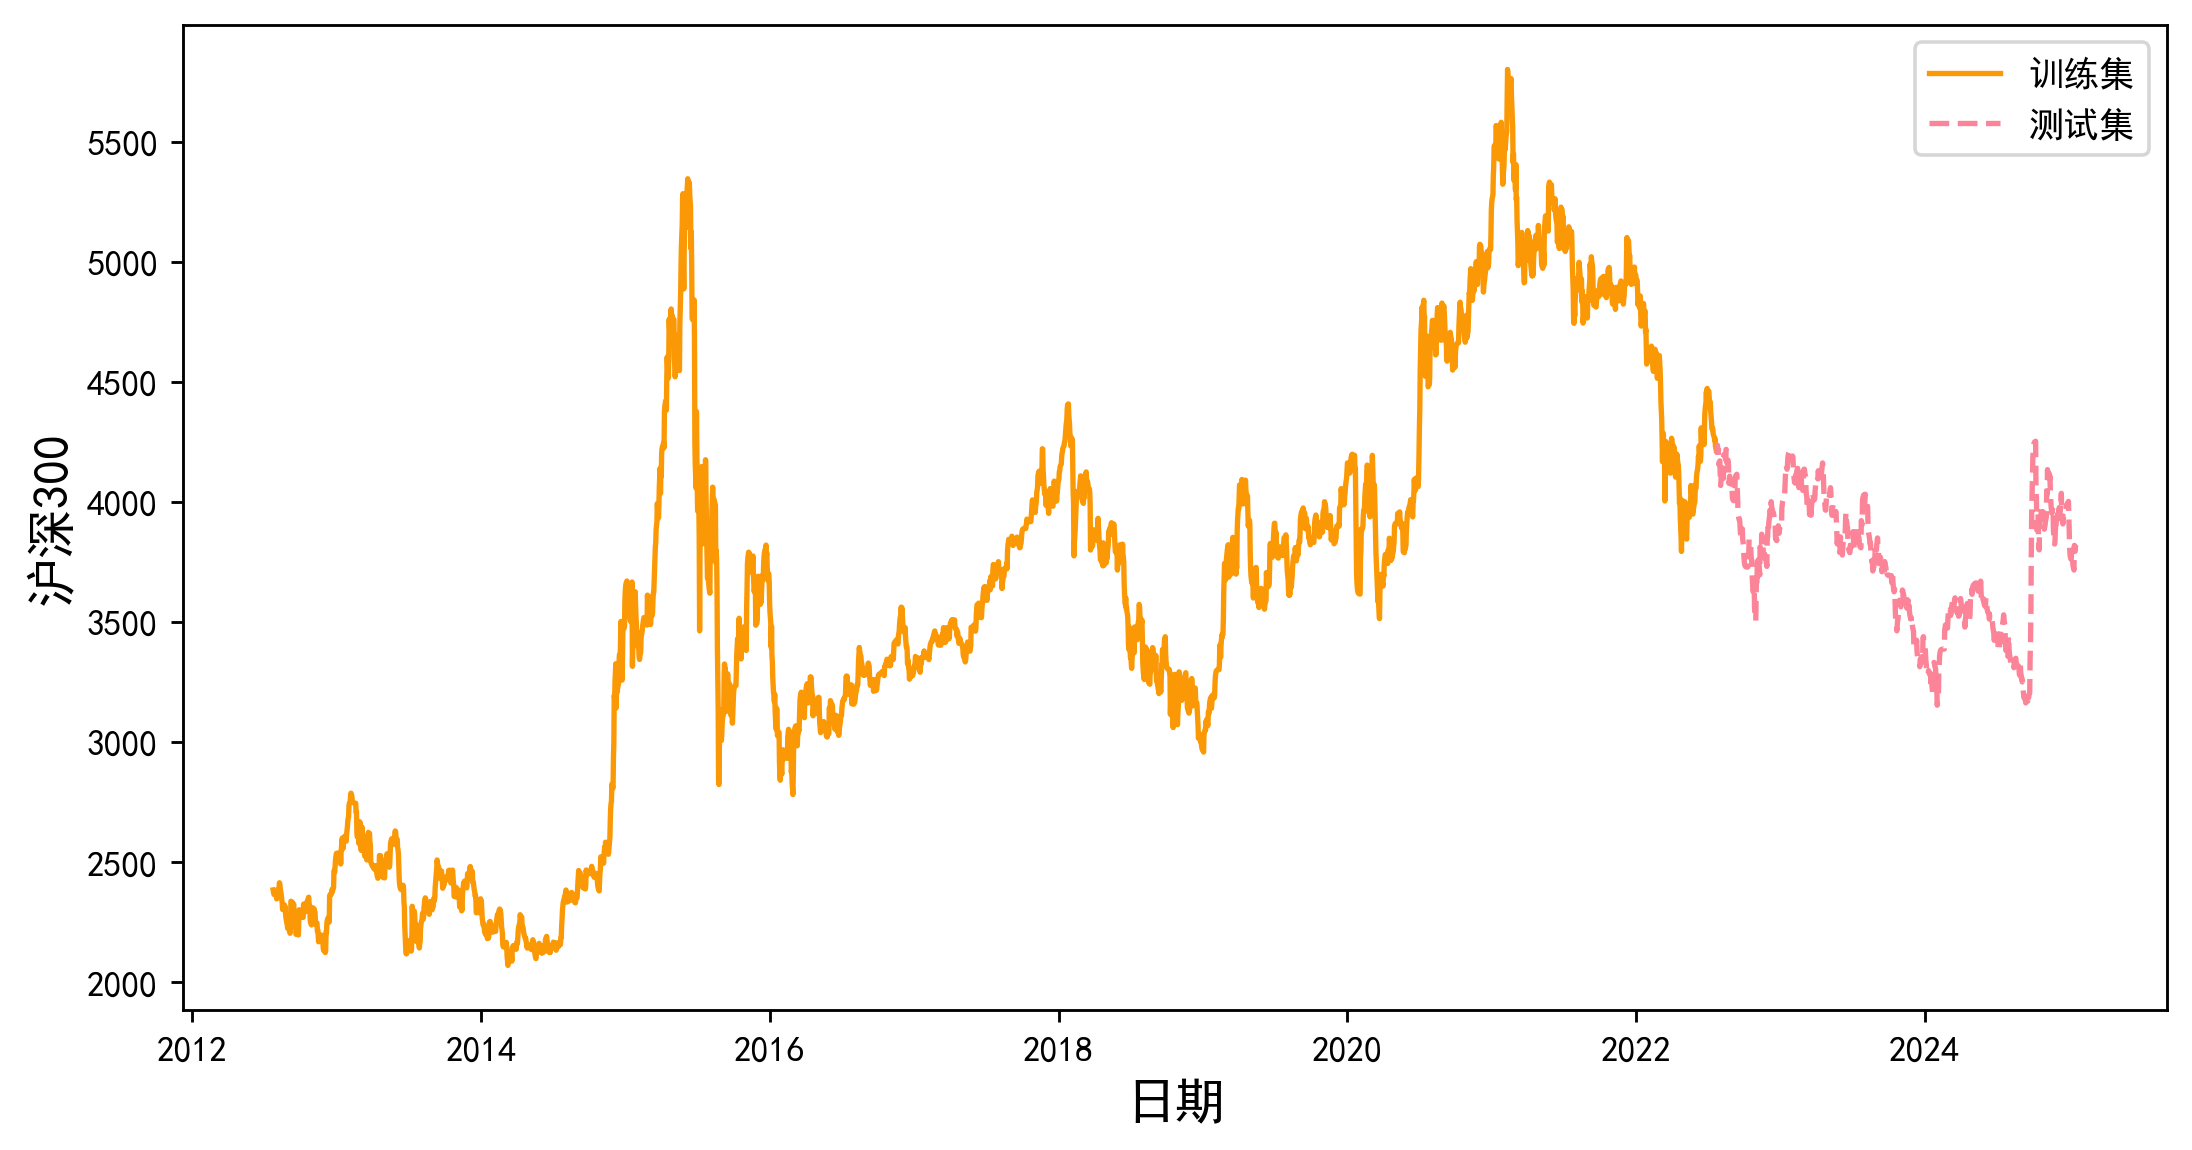

训练集开始时间2012-07-24 00:00:00,结束时间2022-07-23 00:00:00
测试集开始时间2022-07-24 00:00:00,结束时间2025-01-20 00:00:00


In [15]:
y_test1 = y_scaler.inverse_transform(y_test.reshape(-1,1))
test_size=int(len(data)*(1-train_ratio))
plt.figure(figsize=(10,5),dpi=256)
plt.plot(data0.index[:-test_size],data0.iloc[:,-1].iloc[:-test_size],label='训练集',color='#FA9905')
plt.plot(data0.index[-test_size:],data0.iloc[:,-1].iloc[-(test_size):],label='测试集',color='#FB8498',linestyle='dashed')
plt.legend()
plt.ylabel('沪深300',fontsize=14)
plt.xlabel('日期',fontsize=14)
plt.show()
print(f'训练集开始时间{data0.index[:-test_size][0]},结束时间{data0.index[:-test_size][-1]}')
print(f'测试集开始时间{data0.index[-test_size:][0]},结束时间{data0.index[-test_size:][-1]}')

# 三、定义评价指标

In [16]:
#设置随机种子
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)
    
 #评估模型预测的准确性   
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    return mse, rmse, mae, mape #r_2

#绘制训练过程中的损失值和其他指标的变化曲线
def plot_loss(hist,imfname=''):
    plt.subplots(1,4,figsize=(16,4))
    for i,key in enumerate(hist.history.keys()):
        n=int(str('24')+str(i+1))
        plt.subplot(n)
        plt.plot(hist.history[key], 'k', label=f'Training {key}')
        plt.title(f'{imfname} Training {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.legend()
    plt.tight_layout()
    plt.show()

#绘制真实值和预测值的对比图
def plot_fit(y_test, y_pred):
    plt.figure(figsize=(4,2))
    plt.plot(y_test, color="red", label="actual")
    plt.plot(y_pred, color="blue", label="predict")
    plt.title(f"拟合值和真实值对比")
    plt.xlabel("Time")
    plt.ylabel('values')
    plt.legend()
    plt.show()

# 四、设置训练函数

In [17]:
df_eval_all = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'MAPE'])
df_preds_all = pd.DataFrame()

def train_fuc(
    mode='LSTM',
    batch_size=32,
    epochs=1000,  # 设置为足够大的初始值，由 EarlyStopping 控制实际轮次
    hidden_dim=[32, 16],
    verbose=0,
    show_loss=True,
    show_fit=True,
    early_stop_patience=10,  # 添加 EarlyStopping 参数
    monitor_metric='val_loss',  # 默认监控验证损失
    min_delta=0,
    model_save_path=None,  

):
    # 构建模型
    s = time.time()
    set_my_seed()
    model = build_model(X_train=X_train, mode=mode, hidden_dim=hidden_dim)
    
    # 配置 EarlyStopping
    earlystop = EarlyStopping(
        monitor=monitor_metric,
        min_delta=min_delta,
        patience=early_stop_patience,
        restore_best_weights=True  # 恢复最佳模型权重
    )
    
    # 训练模型
    hist = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        callbacks=[earlystop],
        validation_data=(X_test, y_test)
    )
    
    # 保存模型
    if model_save_path is not None:
        model.save(model_save_path)  # 保存为 Keras 格式
        print(f"模型已保存至：{model_save_path}")
    
    # 输出训练信息
    if show_loss:
        plot_loss(hist)
    
    # 预测与评估
    y_pred = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred)
    if show_fit:
        plot_fit(y_test1, y_pred) 
    e = time.time()
    print(f"运行时间为 {round(e - s, 3)} 秒")
    df_preds_all[mode] = y_pred.reshape(-1,)
    
    # 保存评估结果
    eval_metrics = list(evaluation(y_test1, y_pred))  # 评估指标顺序: MSE, RMSE, MAE, MAPE
    df_eval_all.loc[f'{mode}', :] = eval_metrics
    metrics_to_print = eval_metrics.copy()
    metrics_to_print[0] *= 0.01 
    metrics_to_print[1] *= 0.1
    metrics_to_print[2] *= 0.1
    metrics_to_print = [round(i, 3) for i in metrics_to_print]
    print(f"{mode} 的预测效果为：MSE: {metrics_to_print[0]}, RMSE: {metrics_to_print[1]}, MAE: {metrics_to_print[2]}, MAPE: {metrics_to_print[3]}")
    print("======================================= 运行结束 ==========================================")

    return hist

In [18]:
def train_model(train_fuc, model_save_path, mode, batch_size, hidden_dim, verbose, early_stop_patience):
    # 检查模型文件是否存在，如果存在则删除
    if os.path.exists(model_save_path):
        os.remove(model_save_path)
        
    # 训练模型
    hist = train_fuc(
        mode=mode,
        batch_size=batch_size,
        hidden_dim=hidden_dim,
        verbose=verbose,
        early_stop_patience=early_stop_patience,
        model_save_path=model_save_path,
    )
    return hist

# 模型训练参数
params = {
    'LSTM': {
        'model_save_path': 'lstm_model.h5',
        'mode': 'LSTM',          #模型名称
        'batch_size': 32,        #训练批次
        'hidden_dim': [32, 16],  # 隐藏层维度
        'verbose': 1,
        'early_stop_patience': 5 # 早停耐心
    },
    'GRU': {
        'model_save_path': 'GRU_model.h5',
        'mode': 'GRU',
        'batch_size': 32,
        'hidden_dim': [32, 16],
        'verbose': 1,
        'early_stop_patience': 5
    },
     'CNN+LSTM': {
        'model_save_path': 'CNN+LSTM_model.h5',
        'mode': 'CNN+LSTM',
        'batch_size': 32,
        'hidden_dim': [128, 64],
        'verbose': 1,
        'early_stop_patience': 5
    },

    'BiLSTM': {
        'model_save_path': 'BiLSTM_model.h5',
        'mode': 'BiLSTM',
        'batch_size': 32,
        'hidden_dim': [32, 16],
        'verbose': 1,
        'early_stop_patience': 5}
}

# 五、开始训练

## 5.1 短、中、长期预测

### 5.1.1 数据处理与模型构建

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 加载数据
data0 = pd.read_csv('沪深300期货历史数据2_处理后.csv', parse_dates=['日期']).set_index('日期')[['开盘', '高', '低', '收盘']].sort_index()
data0 = data0.astype('float')
data = data0.to_numpy()

# 加载Scaler
scaler = joblib.load('feature_scaler.pkl')
y_scaler = joblib.load('target_scaler.pkl')

# 数据预处理
X = scaler.transform(data[:, :-1])
y = data[:, -1].reshape(-1, 1)
y = y_scaler.transform(y)

# 构建序列数据
def build_sequences(X, y, window_size, prediction_size):
    X_sequences = []
    y_sequences = []
    for i in range(len(X) - window_size - prediction_size + 1):
        x = X[i:i+window_size]
        y_pred = y[i+window_size:i+window_size+prediction_size]
        X_sequences.append(x)
        y_sequences.append(y_pred)
    return np.array(X_sequences), np.array(y_sequences)

# 定义模型结构（添加注意力机制）
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = Dense(units)
        self.U = Dense(units)
        self.v = Dense(1)
    
    def call(self, inputs):
        x = self.W(inputs)
        u = self.U(inputs)
        x_u = tf.expand_dims(x, axis=-1)
        u_x = tf.expand_dims(u, axis=-2)
        attention_weights = tf.nn.softmax(tf.reduce_sum(x_u * u_x, axis=-1), axis=-1)
        return tf.reduce_sum(attention_weights * inputs, axis=-2)

def build_model(window_size, prediction_size, feature_size):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, feature_size)))
    model.add(Dropout(0.2))
    model.add(Attention(64))
    model.add(Dropout(0.2))
    model.add(Dense(prediction_size))
    model.compile(loss='mse', optimizer='adam')
    return model

# 训练模型
def train_model(window_size, prediction_size, X, y, test_size=0.2, epochs=50, batch_size=32):
    train_size = int(len(y) * (1 - test_size))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    X_train_seq, y_train_seq = build_sequences(X_train, y_train, window_size, prediction_size)
    X_test_seq, y_test_seq = build_sequences(X_test, y_test, window_size, prediction_size)
    
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    model = build_model(window_size, prediction_size, X.shape[-1])
    
    history = model.fit(X_train_seq, y_train_seq, 
                       epochs=epochs, 
                       batch_size=batch_size, 
                       validation_data=(X_test_seq, y_test_seq),
                       callbacks=[early_stopping],
                       verbose=1)
    return model, history

# 评估函数
def evaluate_model(y_true, y_pred):
    y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100  # 转换为百分比
    return rmse, mae, mape

# 实验运行函数
def run_experiments():
    # 实验1：短期预测
    model_short, _ = train_model(10, 1, X, y)
    # 实验2：中期预测
    model_mid, _ = train_model(30, 3, X, y)
    # 实验3：长期预测
    model_long, _ = train_model(60, 5, X, y)
    return model_short, model_mid, model_long

# 评估所有模型
def evaluate_all_models(model_short, model_mid, model_long, X, y):
    # 实验1评估
    _, X_test_short, _, y_test_short = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_test_seq_short, y_test_seq_short = build_sequences(X_test_short, y_test_short, 10, 1)
    y_pred_short = model_short.predict(X_test_seq_short)
    rmse_short, mae_short, mape_short = evaluate_model(y_test_seq_short, y_pred_short)
    
    # 实验2评估
    _, X_test_mid, _, y_test_mid = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_test_seq_mid, y_test_seq_mid = build_sequences(X_test_mid, y_test_mid, 30, 3)
    y_pred_mid = model_mid.predict(X_test_seq_mid)
    rmse_mid, mae_mid, mape_mid = evaluate_model(y_test_seq_mid, y_pred_mid)
    
    # 实验3评估
    _, X_test_long, _, y_test_long = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_test_seq_long, y_test_seq_long = build_sequences(X_test_long, y_test_long, 60, 5)
    y_pred_long = model_long.predict(X_test_seq_long)
    rmse_long, mae_long, mape_long = evaluate_model(y_test_seq_long, y_pred_long)
    
    return (rmse_short, rmse_mid, rmse_long), (mae_short, mae_mid, mae_long), (mape_short, mape_mid, mape_long)

### 5.1.2 评估模型&可视化

Epoch 1/50
114/114 [==============================] - 3s 13ms/step - loss: 0.0343 - val_loss: 9.3432e-04
Epoch 2/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 8.6682e-04
Epoch 3/50
114/114 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 8.8505e-04
Epoch 4/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 9.0638e-04
Epoch 5/50
114/114 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/50
114/114 [==============================] - 1s 13ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 8/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 9.9777e-04
Epoch 9/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 8.1254e-04
Epoch 10/50
114/114 [==============================] - 1s 13ms/step

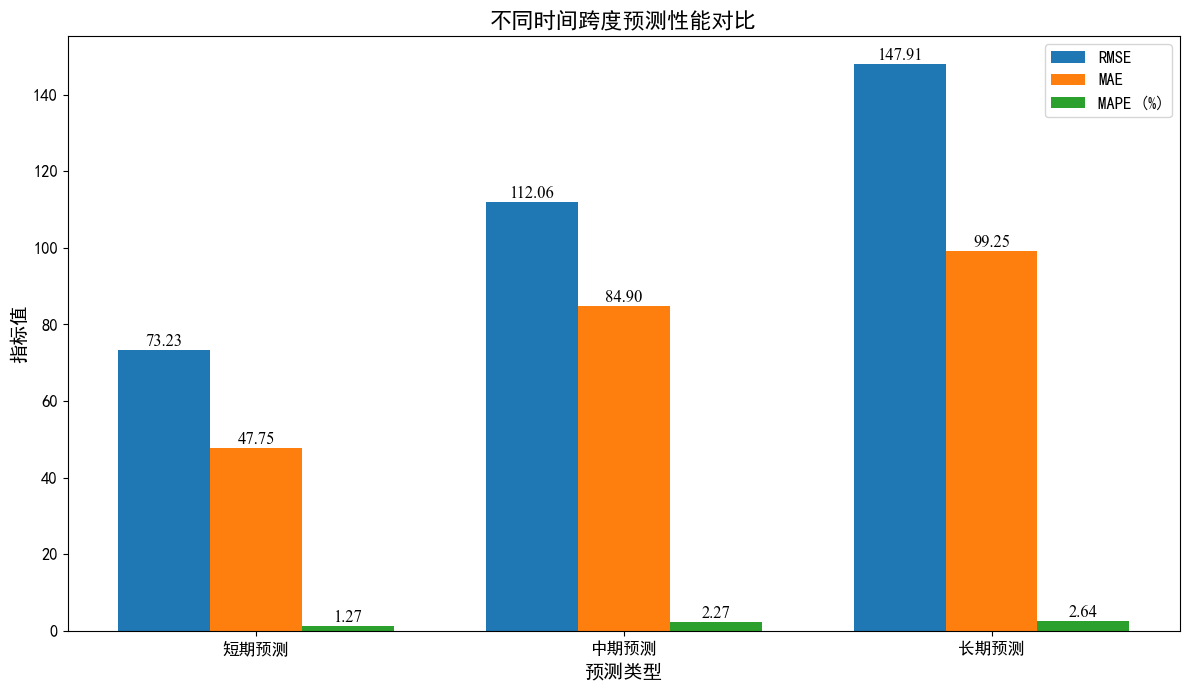

In [13]:
    # 运行实验
    model_short, model_mid, model_long = run_experiments()
    
    # 获取评估指标
    rmse_values, mae_values, mape_values = evaluate_all_models(model_short, model_mid, model_long, X, y)
    
    # 可视化设置
    prediction_types = ['短期预测', '中期预测', '长期预测']
    bar_width = 0.25
    index = np.arange(len(prediction_types))
    
    plt.figure(figsize=(12, 7))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 绘制柱状图
    bars1 = plt.bar(index - bar_width, rmse_values, bar_width, label='RMSE')
    bars2 = plt.bar(index, mae_values, bar_width, label='MAE')
    bars3 = plt.bar(index + bar_width, mape_values, bar_width, label='MAPE (%)')
    
    # 添加数值标签
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom',
                    fontsize=12, fontfamily='Times New Roman')
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    # 图表装饰
    plt.xlabel('预测类型', fontsize=14)
    plt.ylabel('指标值', fontsize=14)
    plt.title('不同时间跨度预测性能对比', fontsize=16)
    plt.xticks(index, prediction_types, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 5.2不同滑动窗口下的LSTM模型比较


=== 正在运行的滑动窗口为：=3 ===

=== 正在运行的滑动窗口为：=3 ===

=== 正在运行的滑动窗口为：=3 ===
(2436, 3, 4) (2436,) (610, 3, 4) (610,)
Epoch 1/1000
77/77 [==============================] - 5s 20ms/step - loss: 0.2741 - root_mean_squared_error: 0.5020 - mape: 112335.2891 - mae: 0.3628 - val_loss: 0.0223 - val_root_mean_squared_error: 0.0192 - val_mape: 3.3380 - val_mae: 0.0147
Epoch 2/1000
77/77 [==============================] - 1s 9ms/step - loss: 0.0652 - root_mean_squared_error: 0.2083 - mape: 16263.9883 - mae: 0.1634 - val_loss: 0.0219 - val_root_mean_squared_error: 0.0179 - val_mape: 2.8221 - val_mae: 0.0128
Epoch 3/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0421 - root_mean_squared_error: 0.1440 - mape: 138445.0781 - mae: 0.1145 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0550 - val_mape: 12.3018 - val_mae: 0.0532
Epoch 4/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0329 - root_mean_squared_error: 0.1095 - mape: 26067.5801 - mae: 0.0863 - val_loss: 0

Epoch 68/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0043 - root_mean_squared_error: 0.0356 - mape: 7120.0435 - mae: 0.0267 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0158 - val_mape: 2.5652 - val_mae: 0.0112
Epoch 69/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0042 - root_mean_squared_error: 0.0357 - mape: 15546.0508 - mae: 0.0268 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0209 - val_mape: 3.4156 - val_mae: 0.0159
Epoch 70/1000
77/77 [==============================] - 1s 7ms/step - loss: 0.0041 - root_mean_squared_error: 0.0357 - mape: 22517.4668 - mae: 0.0268 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0396 - val_mape: 7.5461 - val_mae: 0.0353
Epoch 71/1000
77/77 [==============================] - 0s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0369 - mape: 26120.7070 - mae: 0.0276 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0388 - val_mape: 7.9988 - val_mae: 0.0358
Epoch 72/1000
77/77 [========

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


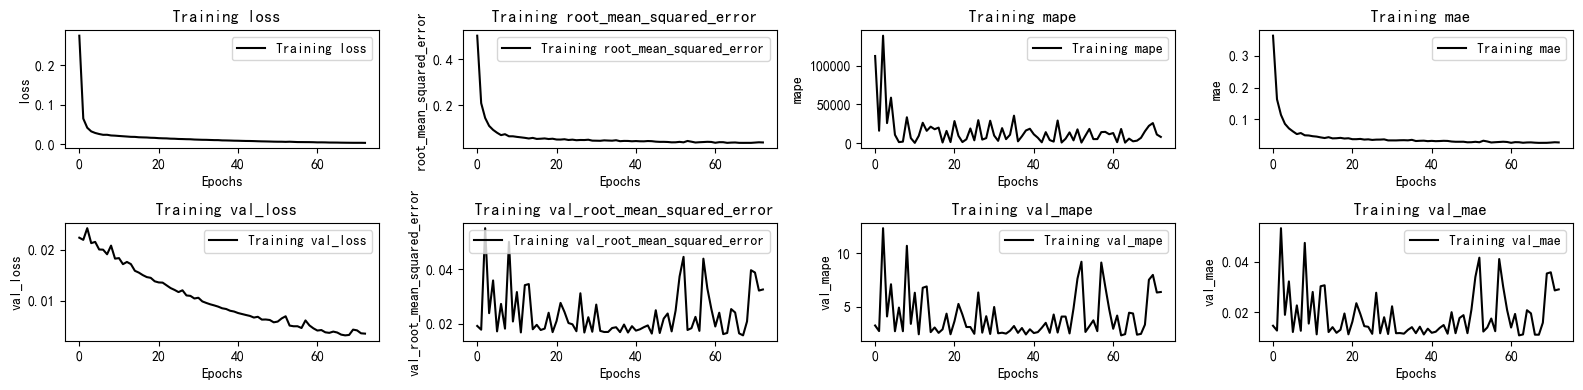

20/20 [==============================] - 1s 2ms/step


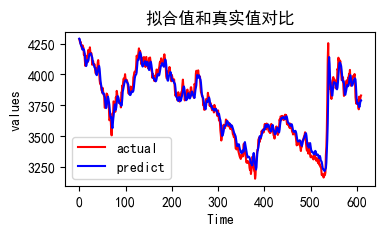

运行时间为 47.086 秒
LSTM 的预测效果为：MSE: 34.687, RMSE: 5.89, MAE: 4.17, MAPE: 0.011
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=5 ===

=== 正在运行的滑动窗口为：=5 ===

=== 正在运行的滑动窗口为：=5 ===
(2434, 5, 4) (2434,) (610, 5, 4) (610,)
Epoch 1/1000
77/77 [==============================] - 5s 19ms/step - loss: 0.3904 - root_mean_squared_error: 0.6068 - mape: 202819.7188 - mae: 0.4228 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1052 - val_mape: 23.0807 - val_mae: 0.1030
Epoch 2/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0741 - root_mean_squared_error: 0.2281 - mape: 60779.9258 - mae: 0.1785 - val_loss: 0.0244 - val_root_mean_squared_error: 0.0501 - val_mape: 11.0334 - val_mae: 0.0469
Epoch 3/1000
77/77 [==============================] - 1s 9ms/step - loss: 0.0474 - root_mean_squared_error: 0.1600 - mape: 167020.3750 - mae: 0.1272 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1034 - val_mape: 23.4206 - val_mae: 0.1

Epoch 34/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0143 - root_mean_squared_error: 0.0487 - mape: 1055.2487 - mae: 0.0369 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0704 - val_mape: 15.2806 - val_mae: 0.0678
Epoch 35/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0140 - root_mean_squared_error: 0.0485 - mape: 21885.8105 - mae: 0.0371 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0210 - val_mape: 3.4426 - val_mae: 0.0152
Epoch 36/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0134 - root_mean_squared_error: 0.0458 - mape: 9133.9258 - mae: 0.0348 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0196 - val_mape: 2.8644 - val_mae: 0.0129
Epoch 37/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0131 - root_mean_squared_error: 0.0452 - mape: 16238.5850 - mae: 0.0346 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0191 - val_mape: 2.8083 - val_mae: 0.0126
Epoch 38/1000
77/77 [========

Epoch 68/1000
77/77 [==============================] - 1s 9ms/step - loss: 0.0060 - root_mean_squared_error: 0.0388 - mape: 12979.9512 - mae: 0.0292 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0197 - val_mape: 2.9868 - val_mae: 0.0133
Epoch 69/1000
77/77 [==============================] - 1s 9ms/step - loss: 0.0059 - root_mean_squared_error: 0.0394 - mape: 13979.5645 - mae: 0.0298 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0216 - val_mape: 3.8212 - val_mae: 0.0167
Epoch 70/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0056 - root_mean_squared_error: 0.0372 - mape: 13786.0605 - mae: 0.0278 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0199 - val_mape: 3.0303 - val_mae: 0.0135
Epoch 71/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0055 - root_mean_squared_error: 0.0376 - mape: 20030.9043 - mae: 0.0283 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0172 - val_mape: 2.6740 - val_mae: 0.0117
Epoch 72/1000
77/77 [=======

Epoch 102/1000
77/77 [==============================] - 1s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0312 - mape: 22616.5488 - mae: 0.0236 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0409 - val_mape: 8.4736 - val_mae: 0.0382
Epoch 103/1000
77/77 [==============================] - 1s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0326 - mape: 16254.8203 - mae: 0.0247 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0188 - val_mape: 3.1180 - val_mae: 0.0142
Epoch 104/1000
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0330 - mape: 24839.3086 - mae: 0.0251 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0255 - val_mape: 4.9716 - val_mae: 0.0223
Epoch 105/1000
77/77 [==============================] - 1s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0326 - mape: 25686.8418 - mae: 0.0245 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0171 - val_mape: 2.7724 - val_mae: 0.0123
Epoch 106/1000
77/77 [

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


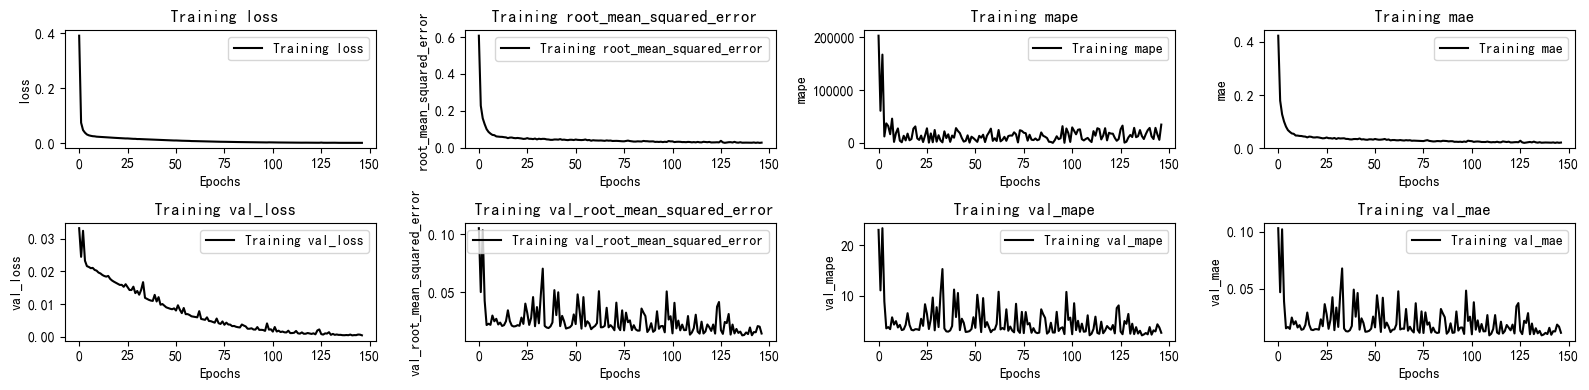

20/20 [==============================] - 1s 3ms/step


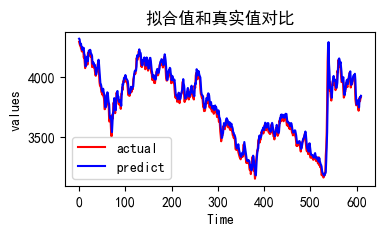

运行时间为 107.308 秒
LSTM 的预测效果为：MSE: 23.308, RMSE: 4.828, MAE: 3.629, MAPE: 0.01
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=7 ===

=== 正在运行的滑动窗口为：=7 ===

=== 正在运行的滑动窗口为：=7 ===
(2432, 7, 4) (2432,) (610, 7, 4) (610,)
Epoch 1/1000
76/76 [==============================] - 5s 20ms/step - loss: 0.4223 - root_mean_squared_error: 0.6326 - mape: 69627.0625 - mae: 0.4400 - val_loss: 0.0248 - val_root_mean_squared_error: 0.0514 - val_mape: 10.2755 - val_mae: 0.0463
Epoch 2/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0822 - root_mean_squared_error: 0.2453 - mape: 214615.7969 - mae: 0.1937 - val_loss: 0.0233 - val_root_mean_squared_error: 0.0368 - val_mape: 7.4049 - val_mae: 0.0321
Epoch 3/1000
76/76 [==============================] - 1s 8ms/step - loss: 0.0512 - root_mean_squared_error: 0.1711 - mape: 68743.4219 - mae: 0.1342 - val_loss: 0.0227 - val_root_mean_squared_error: 0.0300 - val_mape: 5.4985 - val_mae: 0.02

Epoch 34/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0152 - root_mean_squared_error: 0.0460 - mape: 9309.3232 - mae: 0.0352 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0203 - val_mape: 3.0349 - val_mae: 0.0136
Epoch 35/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0151 - root_mean_squared_error: 0.0477 - mape: 786.8423 - mae: 0.0364 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0200 - val_mape: 2.9915 - val_mae: 0.0134
Epoch 36/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0148 - root_mean_squared_error: 0.0474 - mape: 9660.2783 - mae: 0.0360 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0226 - val_mape: 3.4172 - val_mae: 0.0153
Epoch 37/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0143 - root_mean_squared_error: 0.0452 - mape: 12096.3750 - mae: 0.0343 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0212 - val_mape: 3.1375 - val_mae: 0.0141
Epoch 38/1000
76/76 [========

Epoch 68/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0066 - root_mean_squared_error: 0.0362 - mape: 8300.6611 - mae: 0.0274 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0176 - val_mape: 2.8468 - val_mae: 0.0124
Epoch 69/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0071 - root_mean_squared_error: 0.0438 - mape: 6607.6260 - mae: 0.0336 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0289 - val_mape: 5.7884 - val_mae: 0.0252
Epoch 70/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0065 - root_mean_squared_error: 0.0381 - mape: 5001.5225 - mae: 0.0290 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0295 - val_mape: 5.9525 - val_mae: 0.0259
Epoch 71/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0062 - root_mean_squared_error: 0.0366 - mape: 7834.3750 - mae: 0.0273 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0191 - val_mape: 2.8668 - val_mae: 0.0127
Epoch 72/1000
76/76 [========

Epoch 102/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0026 - root_mean_squared_error: 0.0308 - mape: 9066.4590 - mae: 0.0231 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0141 - val_mape: 2.2516 - val_mae: 0.0100
Epoch 103/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0308 - mape: 21889.7383 - mae: 0.0227 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0311 - val_mape: 6.4618 - val_mae: 0.0287
Epoch 104/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0026 - root_mean_squared_error: 0.0339 - mape: 17989.8574 - mae: 0.0256 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0159 - val_mape: 2.8069 - val_mae: 0.0122
Epoch 105/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0025 - root_mean_squared_error: 0.0320 - mape: 1793.6334 - mae: 0.0239 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0157 - val_mape: 2.4730 - val_mae: 0.0113
Epoch 106/1000
76/76 [==

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


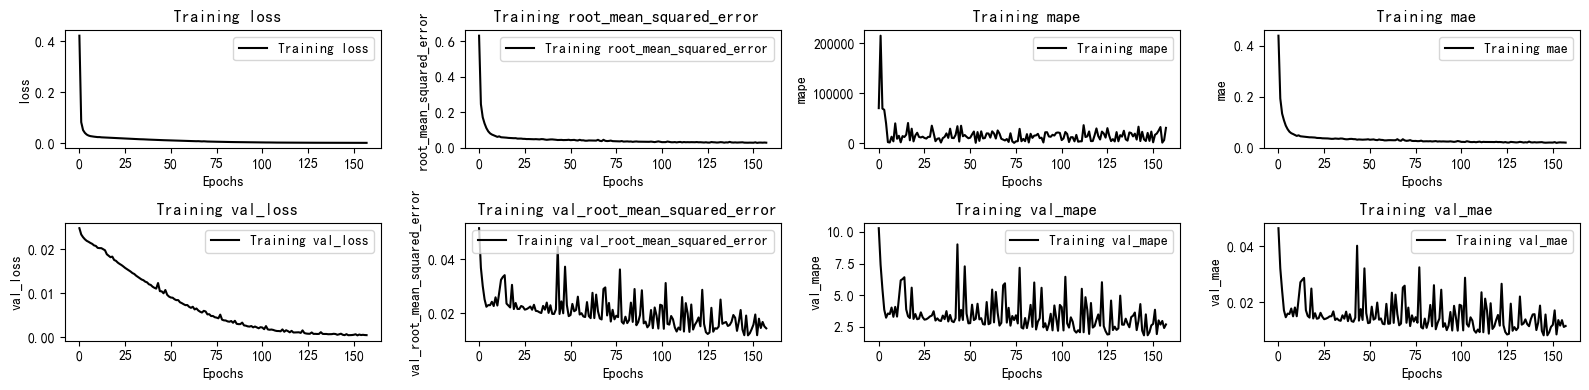

20/20 [==============================] - 1s 3ms/step


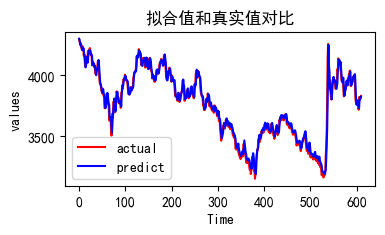

运行时间为 118.919 秒
LSTM 的预测效果为：MSE: 19.272, RMSE: 4.39, MAE: 3.185, MAPE: 0.009
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=9 ===

=== 正在运行的滑动窗口为：=9 ===

=== 正在运行的滑动窗口为：=9 ===
(2430, 9, 4) (2430,) (610, 9, 4) (610,)
Epoch 1/1000
76/76 [==============================] - 5s 24ms/step - loss: 0.4399 - root_mean_squared_error: 0.6463 - mape: 1452.4933 - mae: 0.4388 - val_loss: 0.0229 - val_root_mean_squared_error: 0.0284 - val_mape: 4.5831 - val_mae: 0.0211
Epoch 2/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0821 - root_mean_squared_error: 0.2450 - mape: 65915.7031 - mae: 0.1931 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0249 - val_mape: 4.1015 - val_mae: 0.0178
Epoch 3/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0547 - root_mean_squared_error: 0.1811 - mape: 42050.4258 - mae: 0.1436 - val_loss: 0.0224 - val_root_mean_squared_error: 0.0238 - val_mape: 3.4370 - val_mae: 0.015

Epoch 67/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0074 - root_mean_squared_error: 0.0389 - mape: 17263.7461 - mae: 0.0297 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0188 - val_mape: 3.1028 - val_mae: 0.0136
Epoch 68/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0072 - root_mean_squared_error: 0.0389 - mape: 4419.3579 - mae: 0.0292 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0193 - val_mape: 3.4142 - val_mae: 0.0146
Epoch 69/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0071 - root_mean_squared_error: 0.0386 - mape: 12821.9189 - mae: 0.0292 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0200 - val_mape: 3.4002 - val_mae: 0.0150
Epoch 70/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0070 - root_mean_squared_error: 0.0404 - mape: 11722.2148 - mae: 0.0307 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0186 - val_mape: 2.7469 - val_mae: 0.0124
Epoch 71/1000
76/76 [====

Epoch 101/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0029 - root_mean_squared_error: 0.0332 - mape: 9241.9609 - mae: 0.0248 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0146 - val_mape: 2.3691 - val_mae: 0.0103
Epoch 102/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0028 - root_mean_squared_error: 0.0322 - mape: 17159.6074 - mae: 0.0236 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0157 - val_mape: 2.7803 - val_mae: 0.0119
Epoch 103/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0027 - root_mean_squared_error: 0.0317 - mape: 9940.7900 - mae: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0270 - val_mape: 5.5815 - val_mae: 0.0243
Epoch 104/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0027 - root_mean_squared_error: 0.0332 - mape: 6686.5957 - mae: 0.0247 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0201 - val_mape: 3.3777 - val_mae: 0.0155
Epoch 105/1000
76/76 [=

Epoch 167/1000
76/76 [==============================] - 1s 13ms/step - loss: 9.5347e-04 - root_mean_squared_error: 0.0274 - mape: 7548.3257 - mae: 0.0202 - val_loss: 3.4273e-04 - val_root_mean_squared_error: 0.0120 - val_mape: 2.0398 - val_mae: 0.0088
Epoch 168/1000
76/76 [==============================] - 1s 17ms/step - loss: 9.3043e-04 - root_mean_squared_error: 0.0271 - mape: 13838.4775 - mae: 0.0203 - val_loss: 3.5571e-04 - val_root_mean_squared_error: 0.0125 - val_mape: 1.9183 - val_mae: 0.0087
Epoch 169/1000
76/76 [==============================] - 1s 14ms/step - loss: 9.4325e-04 - root_mean_squared_error: 0.0273 - mape: 26758.3496 - mae: 0.0203 - val_loss: 4.0882e-04 - val_root_mean_squared_error: 0.0147 - val_mape: 2.7643 - val_mae: 0.0120
Epoch 170/1000
76/76 [==============================] - 1s 12ms/step - loss: 9.8569e-04 - root_mean_squared_error: 0.0281 - mape: 1792.5201 - mae: 0.0211 - val_loss: 7.5110e-04 - val_root_mean_squared_error: 0.0234 - val_mape: 4.4372 - val_ma

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


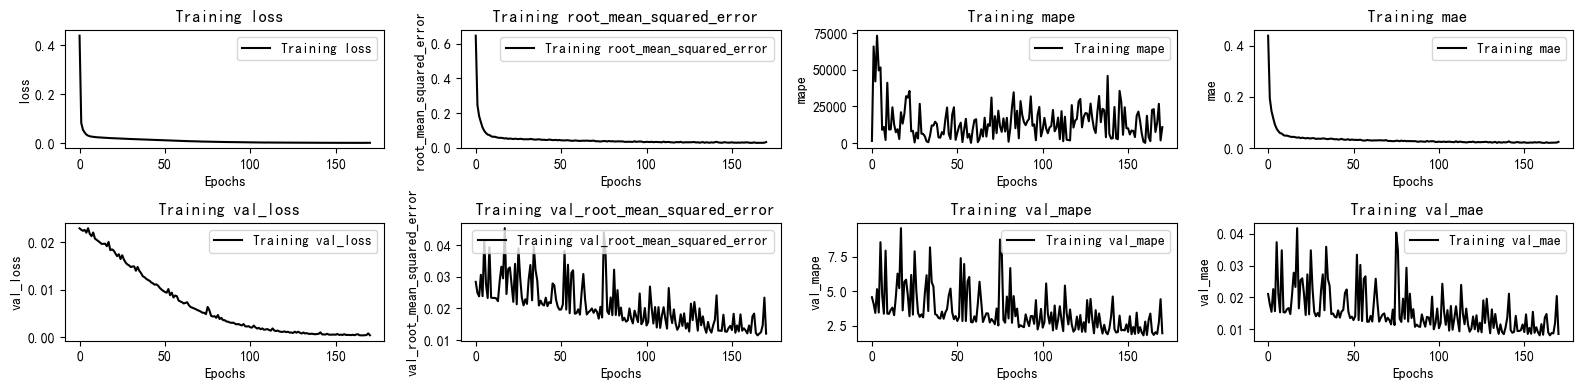

20/20 [==============================] - 1s 4ms/step


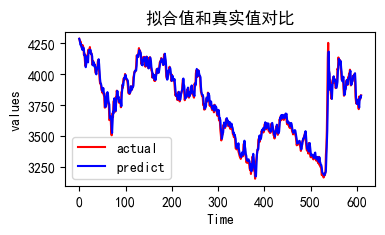

运行时间为 168.728 秒
LSTM 的预测效果为：MSE: 18.322, RMSE: 4.28, MAE: 3.018, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=11 ===

=== 正在运行的滑动窗口为：=11 ===

=== 正在运行的滑动窗口为：=11 ===
(2428, 11, 4) (2428,) (610, 11, 4) (610,)
Epoch 1/1000
76/76 [==============================] - 5s 25ms/step - loss: 0.4901 - root_mean_squared_error: 0.6840 - mape: 276237.6875 - mae: 0.4710 - val_loss: 0.0227 - val_root_mean_squared_error: 0.0251 - val_mape: 3.8965 - val_mae: 0.0175
Epoch 2/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0891 - root_mean_squared_error: 0.2590 - mape: 18954.1328 - mae: 0.2055 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0324 - val_mape: 6.3674 - val_mae: 0.0267
Epoch 3/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0582 - root_mean_squared_error: 0.1903 - mape: 52341.7148 - mae: 0.1514 - val_loss: 0.0260 - val_root_mean_squared_error: 0.0640 - val_mape: 13.8850 - val_ma

Epoch 67/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0077 - root_mean_squared_error: 0.0390 - mape: 6248.7095 - mae: 0.0294 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0183 - val_mape: 2.8289 - val_mae: 0.0126
Epoch 68/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0074 - root_mean_squared_error: 0.0381 - mape: 21827.4531 - mae: 0.0294 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0181 - val_mape: 2.8684 - val_mae: 0.0126
Epoch 69/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0072 - root_mean_squared_error: 0.0373 - mape: 28184.0137 - mae: 0.0283 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0179 - val_mape: 2.5856 - val_mae: 0.0116
Epoch 70/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0069 - root_mean_squared_error: 0.0355 - mape: 12084.3984 - mae: 0.0265 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0189 - val_mape: 2.9794 - val_mae: 0.0133
Epoch 71/1000
76/76 [====

Epoch 101/1000
76/76 [==============================] - 1s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0328 - mape: 4758.0566 - mae: 0.0244 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0334 - val_mape: 6.8628 - val_mae: 0.0308
Epoch 102/1000
76/76 [==============================] - 1s 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0311 - mape: 1039.3920 - mae: 0.0229 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0145 - val_mape: 2.4063 - val_mae: 0.0105
Epoch 103/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0029 - root_mean_squared_error: 0.0327 - mape: 12375.0889 - mae: 0.0244 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0272 - val_mape: 5.3948 - val_mae: 0.0242
Epoch 104/1000
76/76 [==============================] - 1s 14ms/step - loss: 0.0029 - root_mean_squared_error: 0.0338 - mape: 4952.0142 - mae: 0.0255 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0149 - val_mape: 2.4813 - val_mae: 0.0110
Epoch 105/1000
76/76 [=

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


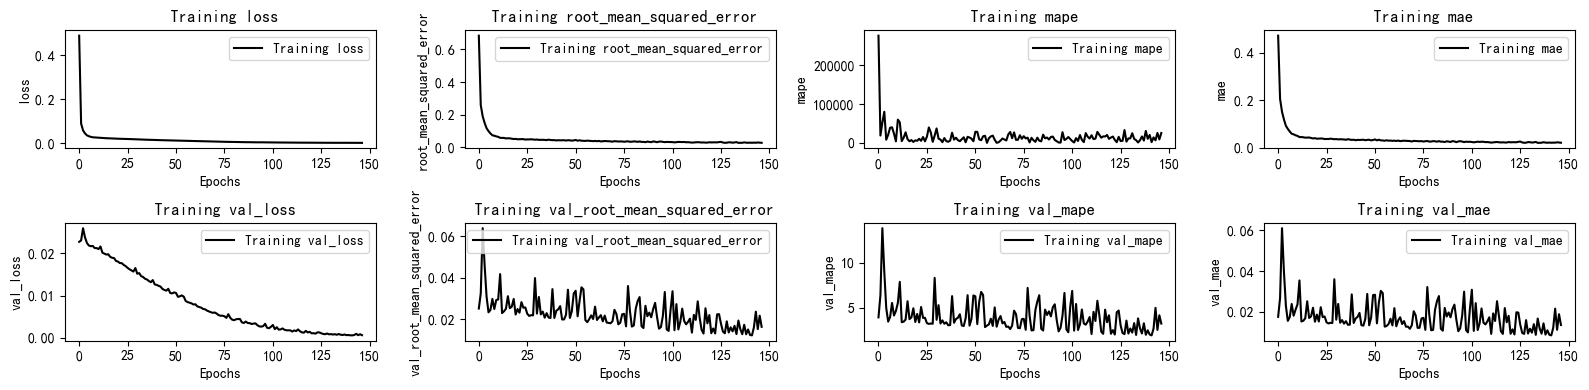

20/20 [==============================] - 1s 5ms/step


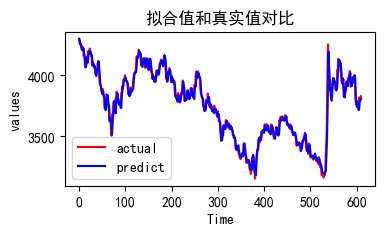

运行时间为 167.19 秒
LSTM 的预测效果为：MSE: 20.206, RMSE: 4.495, MAE: 3.112, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=13 ===

=== 正在运行的滑动窗口为：=13 ===

=== 正在运行的滑动窗口为：=13 ===
(2426, 13, 4) (2426,) (610, 13, 4) (610,)
Epoch 1/1000
76/76 [==============================] - 5s 27ms/step - loss: 0.3749 - root_mean_squared_error: 0.5939 - mape: 65760.3984 - mae: 0.4096 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0264 - val_mape: 4.5895 - val_mae: 0.0196
Epoch 2/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0727 - root_mean_squared_error: 0.2250 - mape: 3723.6289 - mae: 0.1790 - val_loss: 0.0248 - val_root_mean_squared_error: 0.0530 - val_mape: 10.3834 - val_mae: 0.0471
Epoch 3/1000
76/76 [==============================] - 1s 18ms/step - loss: 0.0512 - root_mean_squared_error: 0.1710 - mape: 25946.2793 - mae: 0.1369 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0311 - val_mape: 5.8878 - val_mae:

Epoch 67/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0071 - root_mean_squared_error: 0.0381 - mape: 2367.8477 - mae: 0.0286 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0246 - val_mape: 4.7823 - val_mae: 0.0203
Epoch 68/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0070 - root_mean_squared_error: 0.0395 - mape: 6517.2290 - mae: 0.0297 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0265 - val_mape: 4.7054 - val_mae: 0.0211
Epoch 69/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0066 - root_mean_squared_error: 0.0364 - mape: 4803.2646 - mae: 0.0271 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0188 - val_mape: 3.3053 - val_mae: 0.0141
Epoch 70/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0064 - root_mean_squared_error: 0.0351 - mape: 2373.5583 - mae: 0.0262 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0172 - val_mape: 2.5490 - val_mae: 0.0114
Epoch 71/1000
76/76 [=======

Epoch 101/1000
76/76 [==============================] - 1s 18ms/step - loss: 0.0027 - root_mean_squared_error: 0.0318 - mape: 885.9585 - mae: 0.0235 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0173 - val_mape: 2.7254 - val_mae: 0.0124
Epoch 102/1000
76/76 [==============================] - 1s 19ms/step - loss: 0.0027 - root_mean_squared_error: 0.0325 - mape: 438.1435 - mae: 0.0243 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0216 - val_mape: 3.8015 - val_mae: 0.0171
Epoch 103/1000
76/76 [==============================] - 2s 23ms/step - loss: 0.0025 - root_mean_squared_error: 0.0312 - mape: 2683.2805 - mae: 0.0233 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0173 - val_mape: 2.7808 - val_mae: 0.0125
Epoch 104/1000
76/76 [==============================] - 2s 23ms/step - loss: 0.0026 - root_mean_squared_error: 0.0335 - mape: 6141.7554 - mae: 0.0256 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0146 - val_mape: 2.2522 - val_mae: 0.0100
Epoch 105/1000
76/76 [====

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


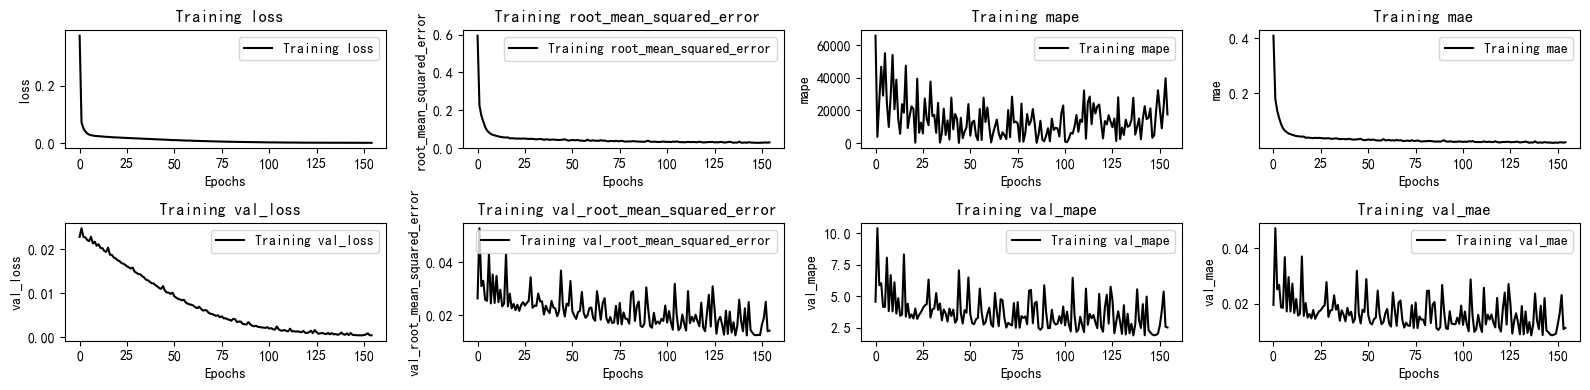

20/20 [==============================] - 1s 8ms/step


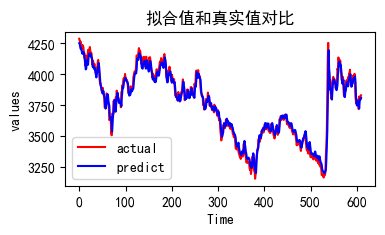

运行时间为 234.616 秒
LSTM 的预测效果为：MSE: 21.927, RMSE: 4.683, MAE: 3.421, MAPE: 0.009
======================================= 运行结束 ==========================================

=== 正在运行的滑动窗口为：=15 ===

=== 正在运行的滑动窗口为：=15 ===

=== 正在运行的滑动窗口为：=15 ===
(2424, 15, 4) (2424,) (610, 15, 4) (610,)
Epoch 1/1000
76/76 [==============================] - 6s 38ms/step - loss: 0.3256 - root_mean_squared_error: 0.5509 - mape: 7260.9893 - mae: 0.3842 - val_loss: 0.0230 - val_root_mean_squared_error: 0.0302 - val_mape: 4.5667 - val_mae: 0.0215
Epoch 2/1000
76/76 [==============================] - 2s 30ms/step - loss: 0.0681 - root_mean_squared_error: 0.2146 - mape: 119932.0000 - mae: 0.1701 - val_loss: 0.0225 - val_root_mean_squared_error: 0.0241 - val_mape: 3.6389 - val_mae: 0.0163
Epoch 3/1000
76/76 [==============================] - 3s 34ms/step - loss: 0.0471 - root_mean_squared_error: 0.1588 - mape: 20251.8555 - mae: 0.1260 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0367 - val_mape: 6.4422 - val_mae

Epoch 67/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0063 - root_mean_squared_error: 0.0374 - mape: 7731.4917 - mae: 0.0282 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0242 - val_mape: 4.3832 - val_mae: 0.0196
Epoch 68/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0062 - root_mean_squared_error: 0.0387 - mape: 14033.1465 - mae: 0.0290 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0314 - val_mape: 5.9311 - val_mae: 0.0269
Epoch 69/1000
76/76 [==============================] - 2s 31ms/step - loss: 0.0060 - root_mean_squared_error: 0.0371 - mape: 1037.9816 - mae: 0.0279 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0165 - val_mape: 2.5599 - val_mae: 0.0113
Epoch 70/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0058 - root_mean_squared_error: 0.0367 - mape: 18194.8906 - mae: 0.0276 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0188 - val_mape: 3.3040 - val_mae: 0.0143
Epoch 71/1000
76/76 [=====

Epoch 101/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0024 - root_mean_squared_error: 0.0316 - mape: 11582.3672 - mae: 0.0234 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0150 - val_mape: 2.7247 - val_mae: 0.0114
Epoch 102/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0024 - root_mean_squared_error: 0.0328 - mape: 1563.2897 - mae: 0.0246 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0142 - val_mape: 2.1815 - val_mae: 0.0098
Epoch 103/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0022 - root_mean_squared_error: 0.0301 - mape: 8061.9365 - mae: 0.0225 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0219 - val_mape: 3.8849 - val_mae: 0.0179
Epoch 104/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0026 - root_mean_squared_error: 0.0367 - mape: 14662.8945 - mae: 0.0277 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0166 - val_mape: 2.7372 - val_mae: 0.0125
Epoch 105/1000
76/76 [

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_17220\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


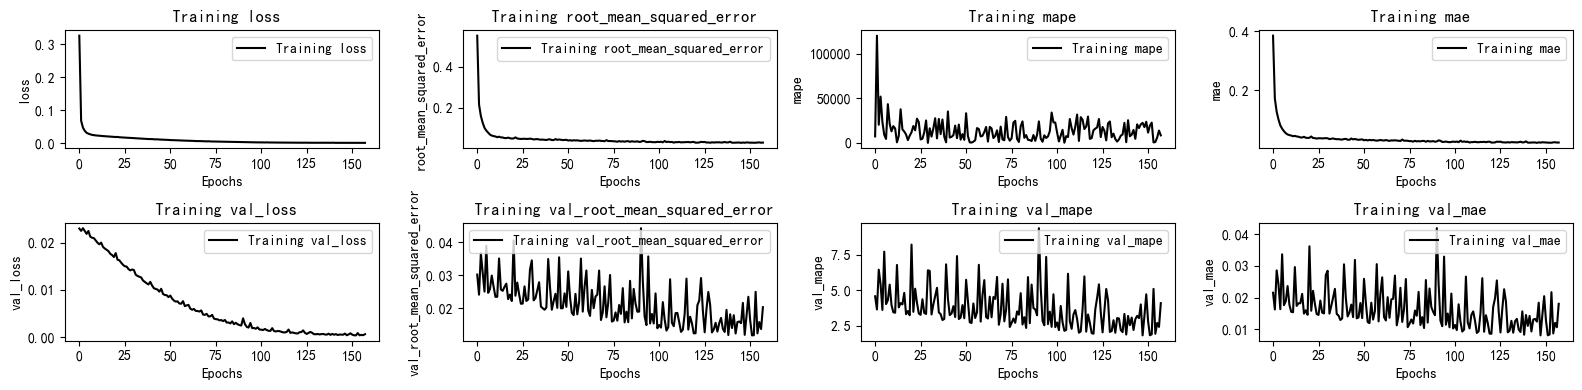

20/20 [==============================] - 1s 11ms/step


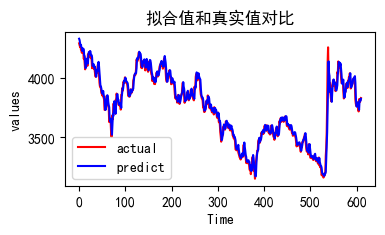

运行时间为 358.303 秒
LSTM 的预测效果为：MSE: 19.607, RMSE: 4.428, MAE: 3.125, MAPE: 0.008
======================================= 运行结束 ==========================================


In [11]:
window_sizes = [3,5,7,9,11,13,15] #设置滑动窗口范围
train_ratio = 0.8  
results = {}  # 存储结果的字典
# 自动执行不同窗口大小的实验
for ws in window_sizes:
    print(f"\n=== 正在运行的滑动窗口为：={ws} ===")
    print(f"\n=== 正在运行的滑动窗口为：={ws} ===")
    print(f"\n=== 正在运行的滑动窗口为：={ws} ===")
    
    # 数据准备（保持原始调用方式）
    X_train, y_train, X_test, y_test = get_traintest(np.c_[X,y], 
                                                    window_size=ws,
                                                    train_ratio=train_ratio)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # 动态创建对应窗口大小的模型构建函数
    def build_model(X_train, mode='LSTM', hidden_dim=[32,16]):
        set_my_seed()
        model = Sequential()
        window_size = ws  # 动态绑定当前窗口值
        input_shape = (window_size, X_train.shape[-1])

        if mode=='LSTM':
            model.add(LSTM(
                units=64, 
                return_sequences=True, 
                input_shape=input_shape,
                kernel_initializer='he_normal'
            ))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
            model.add(LSTM(
                units=64,
                return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                recurrent_regularizer=tf.keras.regularizers.L2(1e-5)
            ))
            model.add(LSTM(units=64, return_sequences=False))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse',
                     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
        return model

    # 执行训练
    hist = train_model(train_fuc, **params['LSTM'])


In [12]:
from tabulate import tabulate

# 定义表格数据
data = [
    ["滑动窗口数为3", 34.687, 5.89, 4.17, 0.011],
    ["滑动窗口数为5", 23.308, 4.828, 3.629, 0.01],
    ["滑动窗口数为7", 19.272, 4.39, 3.185, 0.009],
    ["滑动窗口数为9", 18.322, 4.28, 3.018, 0.008],
    ["滑动窗口数为11", 20.206, 4.495, 3.112, 0.008],
    ["滑动窗口数为13", 21.927, 4.683, 3.421, 0.009],
    ["滑动窗口数为15", 23.628, 4.428, 3.125, 0.008]
]

# 定义表头
headers = ["滑动窗口数", "MSE", "RMSE", "MAE", "MAPE"]

# 打印表格
print(tabulate(data, headers, tablefmt="grid"))

+----------------+--------+--------+-------+--------+
| 滑动窗口数     |    MSE |   RMSE |   MAE |   MAPE |
+================+========+========+=======+========+
| 滑动窗口数为3  | 34.687 |  5.89  | 4.17  |  0.011 |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为5  | 23.308 |  4.828 | 3.629 |  0.01  |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为7  | 19.272 |  4.39  | 3.185 |  0.009 |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为9  | 18.322 |  4.28  | 3.018 |  0.008 |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为11 | 20.206 |  4.495 | 3.112 |  0.008 |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为13 | 21.927 |  4.683 | 3.421 |  0.009 |
+----------------+--------+--------+-------+--------+
| 滑动窗口数为15 | 23.628 |  4.428 | 3.125 |  0.008 |
+----------------+--------+--------+-------+--------+


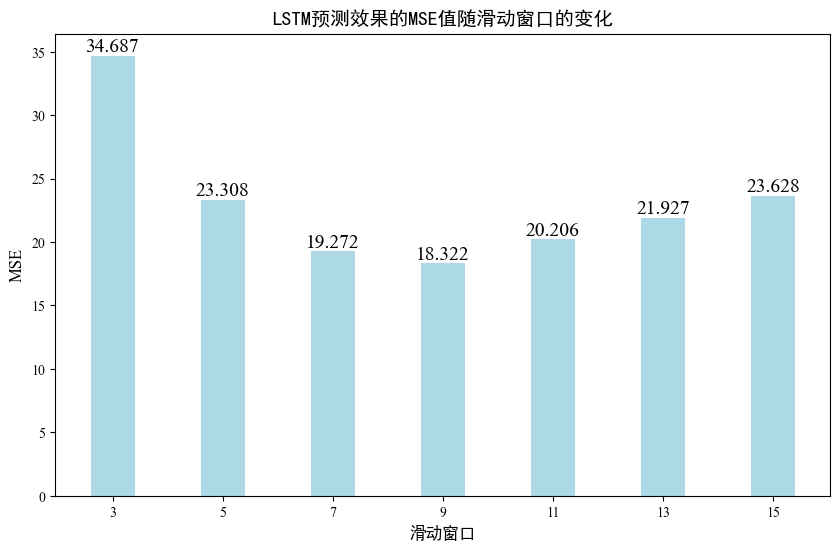

In [18]:
time_steps = [3, 5, 7, 9, 11, 13, 15]
mse_values = [34.687, 23.308, 19.272, 18.322, 20.206,21.927, 23.628]

# 创建柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(time_steps, mse_values, color='lightblue')

# 在柱子上添加具体的数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval , round(yval, 3), ha='center', va='bottom',fontsize=14, fontfamily='Times New Roman')
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
# 设置标题和轴标签
plt.title('LSTM预测效果的MSE值随滑动窗口的变化', fontsize=14)
plt.xlabel('滑动窗口', fontsize=12)
plt.ylabel('MSE',fontsize=12,fontfamily='Times New Roman')

# 设置横轴刻度更详细
plt.xticks(time_steps)

# 显示图表
plt.show()


## 5.3不同隐藏层单元数下的LSTM模型比较

(2430, 9, 4) (2430,) (610, 9, 4) (610,)

=== 正在测试隐藏单元数: 16 ===
Epoch 1/1000
76/76 [==============================] - 5s 19ms/step - loss: 0.2010 - root_mean_squared_error: 0.4438 - mape: 24610.0156 - mae: 0.3279 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0313 - val_mape: 5.0234 - val_mae: 0.0237
Epoch 2/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0481 - root_mean_squared_error: 0.2100 - mape: 88429.6172 - mae: 0.1649 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0239 - val_mape: 3.7486 - val_mae: 0.0165
Epoch 3/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0279 - root_mean_squared_error: 0.1547 - mape: 11541.1504 - mae: 0.1223 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0241 - val_mape: 3.8976 - val_mae: 0.0169
Epoch 4/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0186 - root_mean_squared_error: 0.1212 - mape: 28037.4824 - mae: 0.0955 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0241 - val

Epoch 68/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0032 - root_mean_squared_error: 0.0467 - mape: 10999.2598 - mae: 0.0352 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0208 - val_mape: 3.6221 - val_mae: 0.0154
Epoch 69/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0031 - root_mean_squared_error: 0.0463 - mape: 8495.7588 - mae: 0.0342 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0213 - val_mape: 3.2003 - val_mae: 0.0145
Epoch 70/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0029 - root_mean_squared_error: 0.0449 - mape: 20067.8281 - mae: 0.0330 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0191 - val_mape: 3.0623 - val_mae: 0.0133
Epoch 71/1000
76/76 [==============================] - 1s 9ms/step - loss: 0.0031 - root_mean_squared_error: 0.0473 - mape: 33143.5938 - mae: 0.0352 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0277 - val_mape: 4.6360 - val_mae: 0.0216
Epoch 72/1000
76/76 [========

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_924\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


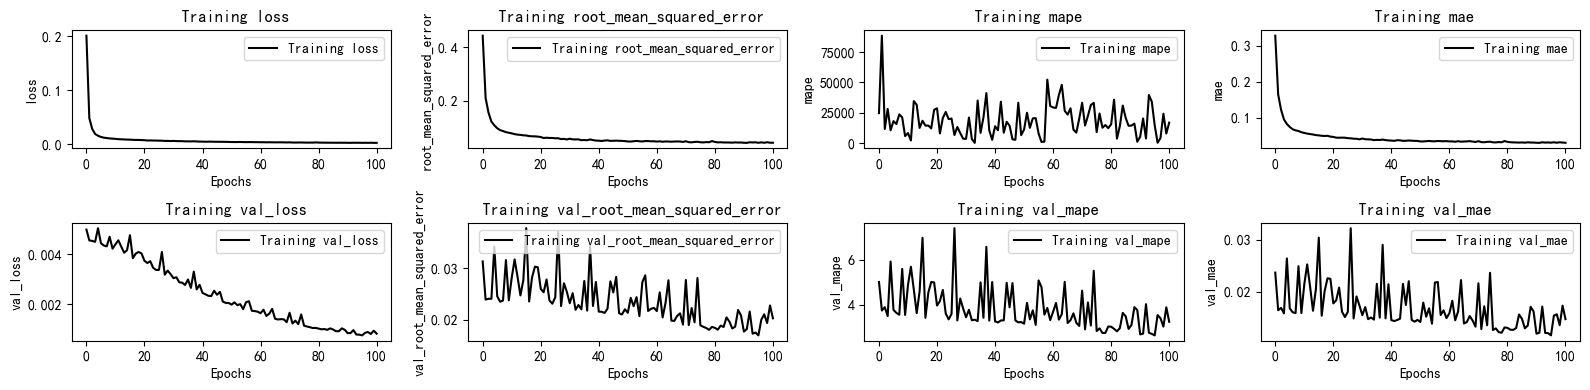

20/20 [==============================] - 1s 2ms/step


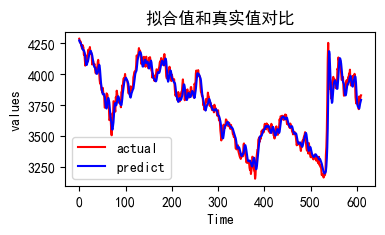

运行时间为 75.853 秒
LSTM 的预测效果为：MSE: 40.249, RMSE: 6.344, MAE: 4.355, MAPE: 0.012
======================================= 运行结束 ==========================================

=== 正在测试隐藏单元数: 32 ===
Epoch 1/1000
76/76 [==============================] - 5s 19ms/step - loss: 0.5024 - root_mean_squared_error: 0.7021 - mape: 45210.1602 - mae: 0.4696 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0678 - val_mape: 14.1307 - val_mae: 0.0627
Epoch 2/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0694 - root_mean_squared_error: 0.2448 - mape: 39960.4414 - mae: 0.1911 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0620 - val_mape: 12.7425 - val_mae: 0.0565
Epoch 3/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0418 - root_mean_squared_error: 0.1798 - mape: 139123.7344 - mae: 0.1417 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0344 - val_mape: 5.6904 - val_mae: 0.0259
Epoch 4/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.029

Epoch 34/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0099 - root_mean_squared_error: 0.0555 - mape: 10986.5049 - mae: 0.0419 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0247 - val_mape: 3.5622 - val_mae: 0.0161
Epoch 35/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0097 - root_mean_squared_error: 0.0550 - mape: 5764.4961 - mae: 0.0412 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0241 - val_mape: 3.8409 - val_mae: 0.0170
Epoch 36/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0094 - root_mean_squared_error: 0.0530 - mape: 19369.5469 - mae: 0.0401 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0235 - val_mape: 3.7060 - val_mae: 0.0164
Epoch 37/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0093 - root_mean_squared_error: 0.0538 - mape: 7786.8906 - mae: 0.0406 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0390 - val_mape: 7.9009 - val_mae: 0.0343
Epoch 38/1000
76/76 [=====

Epoch 68/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0054 - root_mean_squared_error: 0.0446 - mape: 11247.6221 - mae: 0.0331 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0319 - val_mape: 5.6643 - val_mae: 0.0254
Epoch 69/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0053 - root_mean_squared_error: 0.0444 - mape: 14210.8086 - mae: 0.0325 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0202 - val_mape: 3.0444 - val_mae: 0.0135
Epoch 70/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0051 - root_mean_squared_error: 0.0430 - mape: 8571.6152 - mae: 0.0318 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0244 - val_mape: 3.7197 - val_mae: 0.0170
Epoch 71/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0419 - mape: 2516.8562 - mae: 0.0309 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0211 - val_mape: 3.5159 - val_mae: 0.0152
Epoch 72/1000
76/76 [=====

Epoch 102/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0385 - mape: 28104.0137 - mae: 0.0290 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0200 - val_mape: 3.5179 - val_mae: 0.0153
Epoch 103/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0028 - root_mean_squared_error: 0.0397 - mape: 29289.8535 - mae: 0.0296 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0200 - val_mape: 3.6478 - val_mae: 0.0156
Epoch 104/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0378 - mape: 40235.7617 - mae: 0.0281 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0176 - val_mape: 2.5662 - val_mae: 0.0115
Epoch 105/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0025 - root_mean_squared_error: 0.0372 - mape: 39223.0078 - mae: 0.0276 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0205 - val_mape: 3.4044 - val_mae: 0.0152
Epoch 106/1000
76/76

76/76 [==============================] - 1s 10ms/step - loss: 0.0013 - root_mean_squared_error: 0.0326 - mape: 14587.7480 - mae: 0.0240 - val_loss: 3.5701e-04 - val_root_mean_squared_error: 0.0128 - val_mape: 1.9325 - val_mae: 0.0087
Epoch 169/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0350 - mape: 6338.9253 - mae: 0.0260 - val_loss: 3.5084e-04 - val_root_mean_squared_error: 0.0125 - val_mape: 1.9419 - val_mae: 0.0086
Epoch 170/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0318 - mape: 424.0060 - mae: 0.0233 - val_loss: 3.6366e-04 - val_root_mean_squared_error: 0.0132 - val_mape: 2.1182 - val_mae: 0.0095
Epoch 171/1000
76/76 [==============================] - 1s 10ms/step - loss: 0.0013 - root_mean_squared_error: 0.0339 - mape: 12548.4121 - mae: 0.0251 - val_loss: 3.4674e-04 - val_root_mean_squared_error: 0.0126 - val_mape: 2.0243 - val_mae: 0.0088
Epoch 172/1000
76/76 [

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_924\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


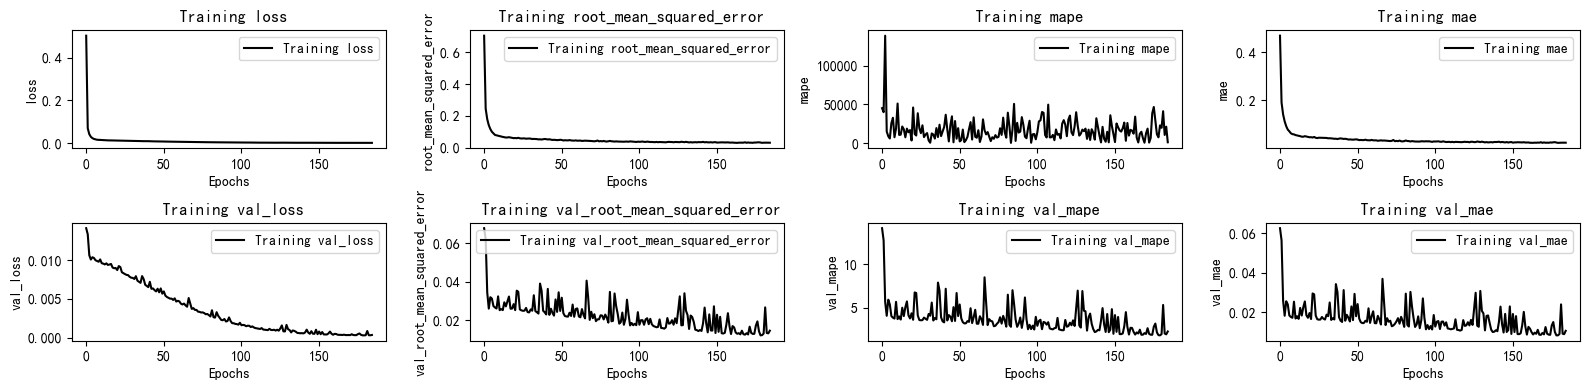

20/20 [==============================] - 1s 3ms/step


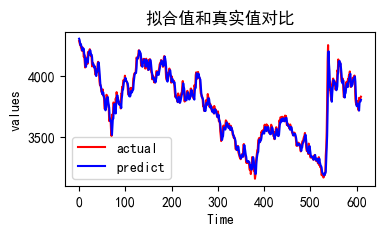

运行时间为 144.108 秒
LSTM 的预测效果为：MSE: 20.945, RMSE: 4.577, MAE: 3.101, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在测试隐藏单元数: 64 ===
Epoch 1/1000
76/76 [==============================] - 5s 23ms/step - loss: 0.4399 - root_mean_squared_error: 0.6463 - mape: 1452.4933 - mae: 0.4388 - val_loss: 0.0229 - val_root_mean_squared_error: 0.0284 - val_mape: 4.5831 - val_mae: 0.0211
Epoch 2/1000
76/76 [==============================] - 1s 14ms/step - loss: 0.0821 - root_mean_squared_error: 0.2450 - mape: 65915.7031 - mae: 0.1931 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0249 - val_mape: 4.1015 - val_mae: 0.0178
Epoch 3/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0547 - root_mean_squared_error: 0.1811 - mape: 42050.4258 - mae: 0.1436 - val_loss: 0.0224 - val_root_mean_squared_error: 0.0238 - val_mape: 3.4370 - val_mae: 0.0155
Epoch 4/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0433 -

Epoch 34/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0159 - root_mean_squared_error: 0.0479 - mape: 553.7238 - mae: 0.0368 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0226 - val_mape: 3.5772 - val_mae: 0.0159
Epoch 35/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0155 - root_mean_squared_error: 0.0467 - mape: 4955.3779 - mae: 0.0353 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0397 - val_mape: 8.2041 - val_mae: 0.0359
Epoch 36/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0151 - root_mean_squared_error: 0.0457 - mape: 11958.4688 - mae: 0.0343 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0322 - val_mape: 5.6780 - val_mae: 0.0257
Epoch 37/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0150 - root_mean_squared_error: 0.0469 - mape: 11907.3887 - mae: 0.0358 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0290 - val_mape: 5.3553 - val_mae: 0.0236
Epoch 38/1000
76/76 [======

Epoch 68/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0072 - root_mean_squared_error: 0.0389 - mape: 4419.3579 - mae: 0.0292 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0193 - val_mape: 3.4142 - val_mae: 0.0146
Epoch 69/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0071 - root_mean_squared_error: 0.0386 - mape: 12821.9189 - mae: 0.0292 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0200 - val_mape: 3.4002 - val_mae: 0.0150
Epoch 70/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0070 - root_mean_squared_error: 0.0404 - mape: 11722.2148 - mae: 0.0307 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0186 - val_mape: 2.7469 - val_mae: 0.0124
Epoch 71/1000
76/76 [==============================] - 1s 11ms/step - loss: 0.0066 - root_mean_squared_error: 0.0364 - mape: 31029.1035 - mae: 0.0275 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0197 - val_mape: 2.9983 - val_mae: 0.0136
Epoch 72/1000
76/76 [====

Epoch 102/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0028 - root_mean_squared_error: 0.0322 - mape: 17159.6074 - mae: 0.0236 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0157 - val_mape: 2.7803 - val_mae: 0.0119
Epoch 103/1000
76/76 [==============================] - 1s 12ms/step - loss: 0.0027 - root_mean_squared_error: 0.0317 - mape: 9940.7900 - mae: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0270 - val_mape: 5.5815 - val_mae: 0.0243
Epoch 104/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0027 - root_mean_squared_error: 0.0332 - mape: 6686.5957 - mae: 0.0247 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0201 - val_mape: 3.3777 - val_mae: 0.0155
Epoch 105/1000
76/76 [==============================] - 1s 13ms/step - loss: 0.0025 - root_mean_squared_error: 0.0311 - mape: 10613.5996 - mae: 0.0234 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0152 - val_mape: 2.6645 - val_mae: 0.0114
Epoch 106/1000
76/76 [

Epoch 168/1000
76/76 [==============================] - 1s 14ms/step - loss: 9.3043e-04 - root_mean_squared_error: 0.0271 - mape: 13838.4775 - mae: 0.0203 - val_loss: 3.5571e-04 - val_root_mean_squared_error: 0.0125 - val_mape: 1.9183 - val_mae: 0.0087
Epoch 169/1000
76/76 [==============================] - 1s 15ms/step - loss: 9.4325e-04 - root_mean_squared_error: 0.0273 - mape: 26758.3496 - mae: 0.0203 - val_loss: 4.0882e-04 - val_root_mean_squared_error: 0.0147 - val_mape: 2.7643 - val_mae: 0.0120
Epoch 170/1000
76/76 [==============================] - 1s 14ms/step - loss: 9.8569e-04 - root_mean_squared_error: 0.0281 - mape: 1792.5201 - mae: 0.0211 - val_loss: 7.5110e-04 - val_root_mean_squared_error: 0.0234 - val_mape: 4.4372 - val_mae: 0.0204
Epoch 171/1000
76/76 [==============================] - 1s 14ms/step - loss: 0.0012 - root_mean_squared_error: 0.0316 - mape: 10858.7051 - mae: 0.0238 - val_loss: 3.5504e-04 - val_root_mean_squared_error: 0.0120 - val_mape: 1.9648 - val_mae: 

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_924\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


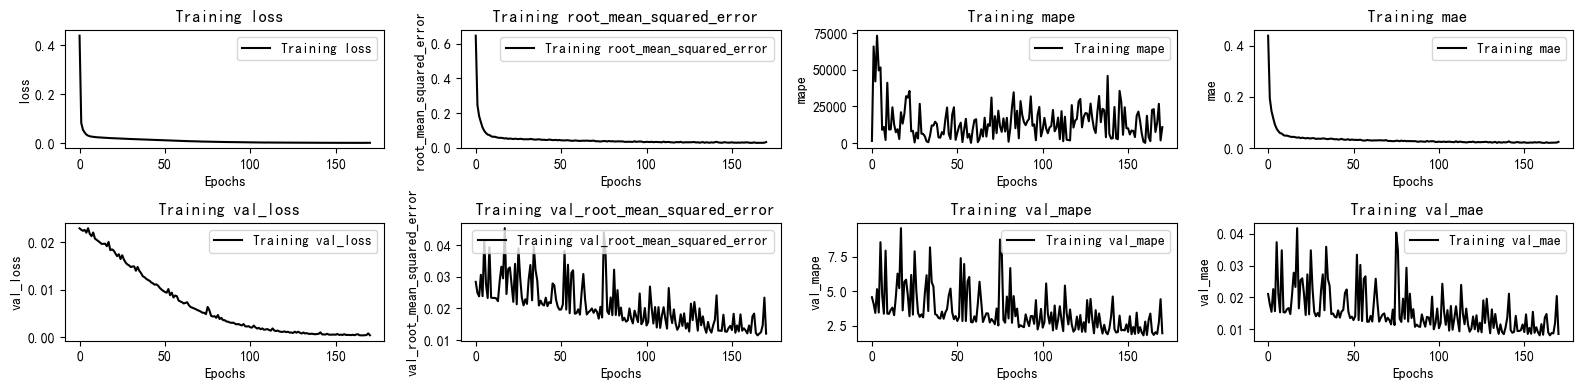

20/20 [==============================] - 1s 5ms/step


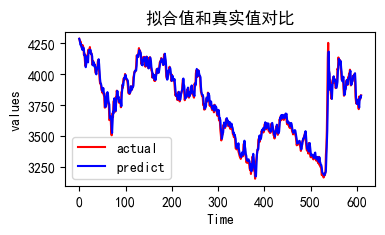

运行时间为 168.322 秒
LSTM 的预测效果为：MSE: 18.322, RMSE: 4.28, MAE: 3.018, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在测试隐藏单元数: 128 ===
Epoch 1/1000
76/76 [==============================] - 8s 44ms/step - loss: 1.1714 - root_mean_squared_error: 1.0572 - mape: 49121.6445 - mae: 0.6389 - val_loss: 0.0546 - val_root_mean_squared_error: 0.0305 - val_mape: 5.6321 - val_mae: 0.0242
Epoch 2/1000
76/76 [==============================] - 3s 33ms/step - loss: 0.1650 - root_mean_squared_error: 0.3340 - mape: 136578.8438 - mae: 0.2668 - val_loss: 0.0586 - val_root_mean_squared_error: 0.0730 - val_mape: 15.2754 - val_mae: 0.0691
Epoch 3/1000
76/76 [==============================] - 2s 33ms/step - loss: 0.1187 - root_mean_squared_error: 0.2564 - mape: 258553.1719 - mae: 0.2038 - val_loss: 0.0555 - val_root_mean_squared_error: 0.0529 - val_mape: 11.5389 - val_mae: 0.0492
Epoch 4/1000
76/76 [==============================] - 2s 33ms/step - loss: 0.0

Epoch 34/1000
76/76 [==============================] - 2s 28ms/step - loss: 0.0320 - root_mean_squared_error: 0.0407 - mape: 23888.6348 - mae: 0.0313 - val_loss: 0.0307 - val_root_mean_squared_error: 0.0265 - val_mape: 4.2862 - val_mae: 0.0195
Epoch 35/1000
76/76 [==============================] - 2s 28ms/step - loss: 0.0314 - root_mean_squared_error: 0.0410 - mape: 3122.4666 - mae: 0.0306 - val_loss: 0.0300 - val_root_mean_squared_error: 0.0261 - val_mape: 4.9026 - val_mae: 0.0209
Epoch 36/1000
76/76 [==============================] - 2s 28ms/step - loss: 0.0306 - root_mean_squared_error: 0.0404 - mape: 2092.5713 - mae: 0.0304 - val_loss: 0.0291 - val_root_mean_squared_error: 0.0201 - val_mape: 3.1222 - val_mae: 0.0138
Epoch 37/1000
76/76 [==============================] - 2s 29ms/step - loss: 0.0302 - root_mean_squared_error: 0.0432 - mape: 13177.3760 - mae: 0.0328 - val_loss: 0.0297 - val_root_mean_squared_error: 0.0414 - val_mape: 8.1798 - val_mae: 0.0362
Epoch 38/1000
76/76 [=====

Epoch 68/1000
76/76 [==============================] - 3s 37ms/step - loss: 0.0131 - root_mean_squared_error: 0.0382 - mape: 4912.8613 - mae: 0.0294 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0183 - val_mape: 3.1456 - val_mae: 0.0133
Epoch 69/1000
76/76 [==============================] - 3s 35ms/step - loss: 0.0127 - root_mean_squared_error: 0.0372 - mape: 19486.1074 - mae: 0.0286 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0190 - val_mape: 2.9173 - val_mae: 0.0133
Epoch 70/1000
76/76 [==============================] - 3s 35ms/step - loss: 0.0121 - root_mean_squared_error: 0.0354 - mape: 4950.6587 - mae: 0.0264 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0178 - val_mape: 2.6360 - val_mae: 0.0118
Epoch 71/1000
76/76 [==============================] - 2s 32ms/step - loss: 0.0118 - root_mean_squared_error: 0.0363 - mape: 3249.9170 - mae: 0.0276 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0183 - val_mape: 2.8728 - val_mae: 0.0129
Epoch 72/1000
76/76 [======

Epoch 102/1000
76/76 [==============================] - 2s 30ms/step - loss: 0.0038 - root_mean_squared_error: 0.0304 - mape: 14753.5107 - mae: 0.0229 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0193 - val_mape: 3.4359 - val_mae: 0.0148
Epoch 103/1000
76/76 [==============================] - 2s 30ms/step - loss: 0.0037 - root_mean_squared_error: 0.0308 - mape: 19689.9727 - mae: 0.0229 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0199 - val_mape: 3.6489 - val_mae: 0.0164
Epoch 104/1000
76/76 [==============================] - 2s 30ms/step - loss: 0.0037 - root_mean_squared_error: 0.0323 - mape: 1440.5309 - mae: 0.0246 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0191 - val_mape: 3.2111 - val_mae: 0.0149
Epoch 105/1000
76/76 [==============================] - 2s 30ms/step - loss: 0.0035 - root_mean_squared_error: 0.0311 - mape: 2470.6179 - mae: 0.0233 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0312 - val_mape: 6.7104 - val_mae: 0.0292
Epoch 106/1000
76/76 [

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_924\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


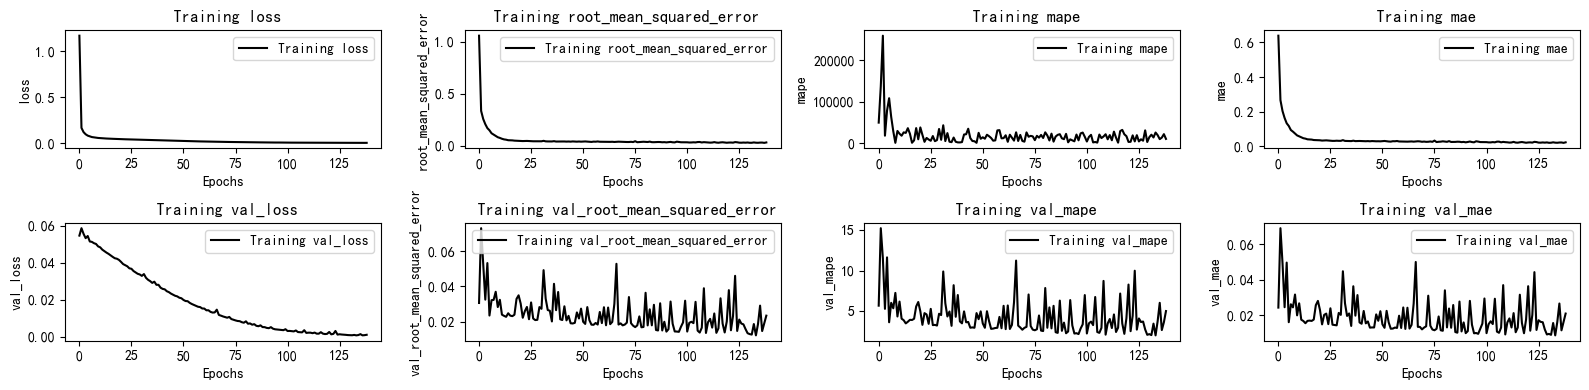

20/20 [==============================] - 1s 11ms/step


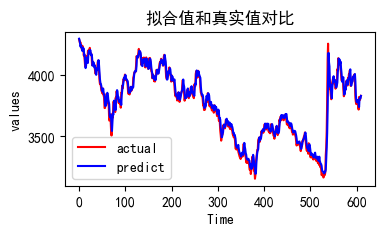

运行时间为 352.222 秒
LSTM 的预测效果为：MSE: 20.527, RMSE: 4.531, MAE: 3.155, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在测试隐藏单元数: 256 ===
Epoch 1/1000
76/76 [==============================] - 16s 120ms/step - loss: 1.6042 - root_mean_squared_error: 1.2124 - mape: 226533.0000 - mae: 0.6624 - val_loss: 0.1376 - val_root_mean_squared_error: 0.0599 - val_mape: 10.0031 - val_mae: 0.0487
Epoch 2/1000
76/76 [==============================] - 9s 117ms/step - loss: 0.2609 - root_mean_squared_error: 0.3573 - mape: 34021.0703 - mae: 0.2826 - val_loss: 0.1413 - val_root_mean_squared_error: 0.0940 - val_mape: 20.1018 - val_mae: 0.0910
Epoch 3/1000
76/76 [==============================] - 9s 116ms/step - loss: 0.2130 - root_mean_squared_error: 0.2854 - mape: 22187.9297 - mae: 0.2265 - val_loss: 0.1401 - val_root_mean_squared_error: 0.0981 - val_mape: 22.1325 - val_mae: 0.0966
Epoch 4/1000
76/76 [==============================] - 9s 118ms/step - los

Epoch 34/1000
76/76 [==============================] - 6s 82ms/step - loss: 0.0623 - root_mean_squared_error: 0.0358 - mape: 10433.1992 - mae: 0.0272 - val_loss: 0.0605 - val_root_mean_squared_error: 0.0212 - val_mape: 3.2681 - val_mae: 0.0147
Epoch 35/1000
76/76 [==============================] - 6s 86ms/step - loss: 0.0604 - root_mean_squared_error: 0.0354 - mape: 8352.7549 - mae: 0.0266 - val_loss: 0.0586 - val_root_mean_squared_error: 0.0186 - val_mape: 3.0448 - val_mae: 0.0132
Epoch 36/1000
76/76 [==============================] - 7s 91ms/step - loss: 0.0587 - root_mean_squared_error: 0.0364 - mape: 21850.1797 - mae: 0.0275 - val_loss: 0.0569 - val_root_mean_squared_error: 0.0197 - val_mape: 2.9385 - val_mae: 0.0132
Epoch 37/1000
76/76 [==============================] - 6s 85ms/step - loss: 0.0569 - root_mean_squared_error: 0.0349 - mape: 36470.5898 - mae: 0.0263 - val_loss: 0.0552 - val_root_mean_squared_error: 0.0190 - val_mape: 2.8287 - val_mae: 0.0127
Epoch 38/1000
76/76 [====

Epoch 68/1000
76/76 [==============================] - 7s 87ms/step - loss: 0.0195 - root_mean_squared_error: 0.0330 - mape: 11570.5195 - mae: 0.0248 - val_loss: 0.0184 - val_root_mean_squared_error: 0.0211 - val_mape: 4.1401 - val_mae: 0.0175
Epoch 69/1000
76/76 [==============================] - 7s 88ms/step - loss: 0.0187 - root_mean_squared_error: 0.0334 - mape: 13604.9414 - mae: 0.0254 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0184 - val_mape: 2.9660 - val_mae: 0.0136
Epoch 70/1000
76/76 [==============================] - 7s 89ms/step - loss: 0.0181 - root_mean_squared_error: 0.0345 - mape: 8196.2539 - mae: 0.0265 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0161 - val_mape: 2.7061 - val_mae: 0.0118
Epoch 71/1000
76/76 [==============================] - 7s 89ms/step - loss: 0.0171 - root_mean_squared_error: 0.0300 - mape: 13621.6709 - mae: 0.0227 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0147 - val_mape: 2.2567 - val_mae: 0.0100
Epoch 72/1000
76/76 [====

Epoch 102/1000
76/76 [==============================] - 7s 88ms/step - loss: 0.0048 - root_mean_squared_error: 0.0309 - mape: 18089.5723 - mae: 0.0234 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0132 - val_mape: 1.9912 - val_mae: 0.0088
Epoch 103/1000
76/76 [==============================] - 7s 87ms/step - loss: 0.0044 - root_mean_squared_error: 0.0278 - mape: 22501.9727 - mae: 0.0212 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0256 - val_mape: 5.3230 - val_mae: 0.0234
Epoch 104/1000
76/76 [==============================] - 6s 85ms/step - loss: 0.0043 - root_mean_squared_error: 0.0289 - mape: 11842.5918 - mae: 0.0221 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0132 - val_mape: 2.0958 - val_mae: 0.0092
Epoch 105/1000
76/76 [==============================] - 7s 86ms/step - loss: 0.0043 - root_mean_squared_error: 0.0310 - mape: 20549.1133 - mae: 0.0232 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0134 - val_mape: 2.0067 - val_mae: 0.0091
Epoch 106/1000
76/76

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_924\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


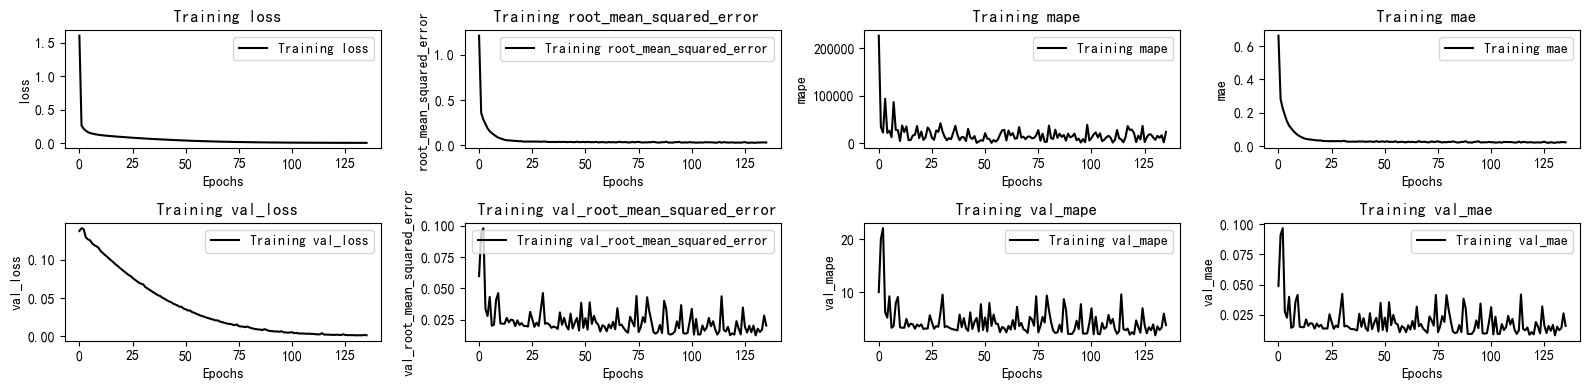

20/20 [==============================] - 1s 21ms/step


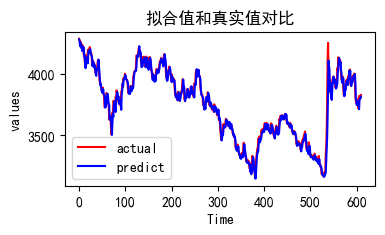

运行时间为 961.698 秒
LSTM 的预测效果为：MSE: 21.984, RMSE: 4.689, MAE: 2.976, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 隐藏单元数性能对比 ===
Units: 16 | Test Loss: 0.3477 | RMSE: 0.5862
Units: 32 | Test Loss: 10.0581 | RMSE: 3.1700
Units: 64 | Test Loss: 0.1282 | RMSE: 0.3258
Units: 128 | Test Loss: 0.2959 | RMSE: 0.4924
Units: 256 | Test Loss: 0.1416 | RMSE: 0.0908


In [11]:
window_size = 9  #上面决定的最优滑动窗口
train_ratio = 0.8
units_list = [16,32,64,128,256]  # 需要测试的隐藏单元数
results = {}

# 数据准备（保持不变）
X_train, y_train, X_test, y_test = get_traintest(np.c_[X,y], 
                                                window_size=window_size,
                                                train_ratio=train_ratio)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

for current_units in units_list:
    print(f"\n=== 正在测试隐藏单元数: {current_units} ===")
    
    # 动态重定义build_model
    def build_model(X_train, mode='LSTM', hidden_dim=[32,16]):
        set_my_seed()
        model = Sequential()
        input_shape = (window_size, X_train.shape[-1])  # 使用外部window_size
        
        if mode == 'LSTM':
            model.add(LSTM(
                units=current_units,  # 使用循环变量
                return_sequences=True,
                input_shape=input_shape,
                kernel_initializer='he_normal'
            ))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
            model.add(LSTM(
                units=current_units,  # 统一使用当前单元数
                return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                recurrent_regularizer=tf.keras.regularizers.L2(1e-5)
            ))
            model.add(LSTM(
                units=current_units,  # 统一单元数
                return_sequences=False
            ))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
        
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse',
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
        return model

    # 训练与评估
    model = build_model(X_train)
    hist = train_model(train_fuc, **params['LSTM'])
    
    # 记录测试集结果
    test_loss, rmse, mape, mae = model.evaluate(X_test, y_test, verbose=0)
    results[current_units] = {
        'test_loss': test_loss,
        'rmse': rmse,
        'mape': mape,
        'mae': mae
    }
    
    # 清理计算图
    tf.keras.backend.clear_session()

# 结果展示
print("\n=== 隐藏单元数性能对比 ===")
for units, metrics in results.items():
    print(f"Units: {units} | Test Loss: {metrics['test_loss']:.4f} | RMSE: {metrics['rmse']:.4f}")

In [13]:
from tabulate import tabulate

# 定义表格数据
data = [
    ["隐藏层单元数为16", 40.249, 6.344, 4.355, 0.012],
    ["隐藏层单元数为32", 20.945, 4.577, 3.101, 0.008],
    ["隐藏层单元数为64", 18.322, 4.28, 3.018, 0.008],
    ["隐藏层单元数为128", 20.527, 4.531, 3.155, 0.008],
    ["隐藏层单元数为256", 21.984, 4.689, 2.976, 0.008]
]

# 定义表头
headers = ["隐藏层单元数", "MSE", "RMSE", "MAE", "MAPE"]

# 打印表格
print(tabulate(data, headers, tablefmt="grid"))


+-------------------+--------+--------+-------+--------+
| 隐藏层单元数      |    MSE |   RMSE |   MAE |   MAPE |
+===================+========+========+=======+========+
| 隐藏层单元数为16  | 40.249 |  6.344 | 4.355 |  0.012 |
+-------------------+--------+--------+-------+--------+
| 隐藏层单元数为32  | 20.945 |  4.577 | 3.101 |  0.008 |
+-------------------+--------+--------+-------+--------+
| 隐藏层单元数为64  | 18.322 |  4.28  | 3.018 |  0.008 |
+-------------------+--------+--------+-------+--------+
| 隐藏层单元数为128 | 20.527 |  4.531 | 3.155 |  0.008 |
+-------------------+--------+--------+-------+--------+
| 隐藏层单元数为256 | 21.984 |  4.689 | 2.976 |  0.008 |
+-------------------+--------+--------+-------+--------+


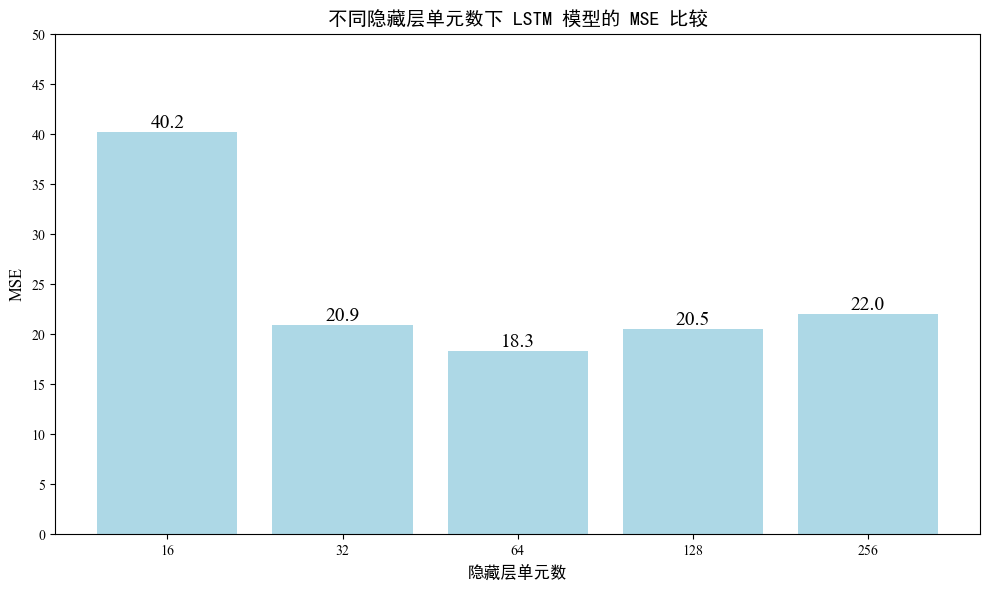

In [18]:
# 隐藏层单元数和对应的 MSE 值
hidden_units =  ['16', '32', '64', '128', '256']
mse_values = [40.249, 20.945,18.322,20.527,21.984]

# 设置柱子的位置，使其均匀分布
x_pos = [0, 1, 2, 3,4]

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图表大小

# 绘制浅蓝色柱状图
plt.bar(x_pos, mse_values, color='lightblue')

# 添加标题和轴标签
plt.title('不同隐藏层单元数下 LSTM 模型的 MSE 比较',fontsize=14)
plt.xlabel('隐藏层单元数', fontsize=12)
plt.ylabel('MSE', fontsize=12, fontfamily='Times New Roman')

# 设置横轴的标签
plt.xticks(x_pos, hidden_units)  # 横轴标签为隐藏层单元数

# 设置纵轴刻度
plt.yticks([0,5,10,15,20,25,30,35,40,45,50])

# 在每个柱子上添加数值标签
for i, value in enumerate(mse_values):
    plt.text(x_pos[i], value, f'{value:.1f}', ha='center', va='bottom',fontfamily='Times New Roman',fontsize=14,)
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
# 调整布局并显示图表
plt.tight_layout()
plt.savefig('隐藏层单元数对MSE的影响.png', dpi=300, bbox_inches='tight')
plt.show()


## 5.4不同学习率下的LSTM模型比较

(3642, 9, 4) (3642,) (913, 9, 4) (913,)

=== 正在测试学习率: 0.1 ===
Epoch 1/1000
114/114 [==============================] - 6s 18ms/step - loss: 2.4725 - root_mean_squared_error: 1.4553 - mape: 1189.8275 - mae: 0.6740 - val_loss: 0.2505 - val_root_mean_squared_error: 0.1520 - val_mape: 27.7304 - val_mae: 0.1338
Epoch 2/1000
114/114 [==============================] - 1s 12ms/step - loss: 0.2179 - root_mean_squared_error: 0.2536 - mape: 131216.3438 - mae: 0.2062 - val_loss: 0.1088 - val_root_mean_squared_error: 0.0843 - val_mape: 15.5605 - val_mae: 0.0718
Epoch 3/1000
114/114 [==============================] - 1s 12ms/step - loss: 0.1359 - root_mean_squared_error: 0.2466 - mape: 108325.4531 - mae: 0.2006 - val_loss: 0.0646 - val_root_mean_squared_error: 0.1005 - val_mape: 17.6256 - val_mae: 0.0845
Epoch 4/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.1023 - root_mean_squared_error: 0.2449 - mape: 109436.2344 - mae: 0.1991 - val_loss: 0.0399 - val_root_mean_squared_erro

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_5788\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


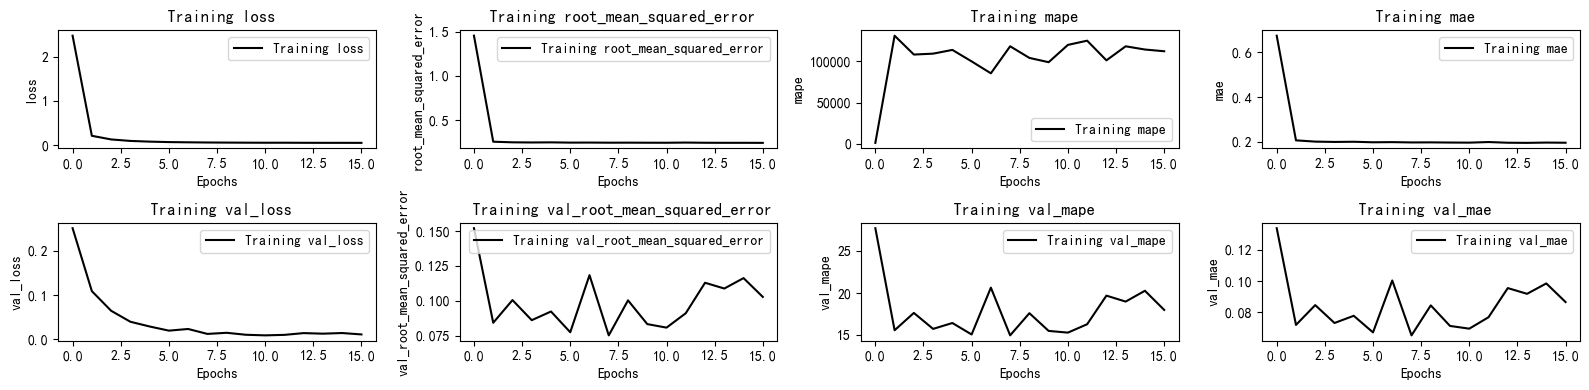

29/29 [==============================] - 1s 4ms/step


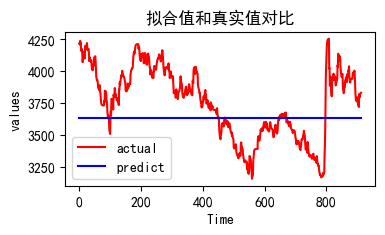

运行时间为 28.622 秒
LSTM 的预测效果为：MSE: 908.164, RMSE: 30.136, MAE: 25.88, MAPE: 0.068
======================================= 运行结束 ==========================================

=== 正在测试学习率: 0.01 ===
Epoch 1/1000
114/114 [==============================] - 6s 18ms/step - loss: 0.6205 - root_mean_squared_error: 0.7696 - mape: 135539.0469 - mae: 0.3313 - val_loss: 0.0310 - val_root_mean_squared_error: 0.0548 - val_mape: 10.9095 - val_mae: 0.0451
Epoch 2/1000
114/114 [==============================] - 1s 13ms/step - loss: 0.0423 - root_mean_squared_error: 0.1254 - mape: 3669.6050 - mae: 0.0983 - val_loss: 0.0261 - val_root_mean_squared_error: 0.0341 - val_mape: 5.4927 - val_mae: 0.0255
Epoch 3/1000
114/114 [==============================] - 1s 12ms/step - loss: 0.0311 - root_mean_squared_error: 0.0876 - mape: 22327.7930 - mae: 0.0674 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0734 - val_mape: 15.6188 - val_mae: 0.0699
Epoch 4/1000
114/114 [==============================] - 1s 11ms/step - lo

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_5788\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


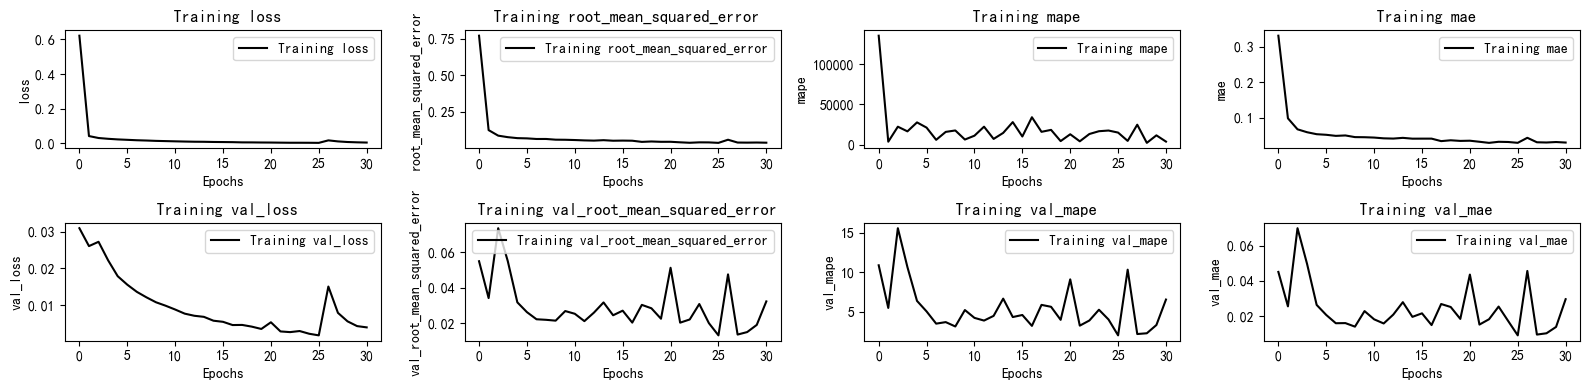

29/29 [==============================] - 1s 5ms/step


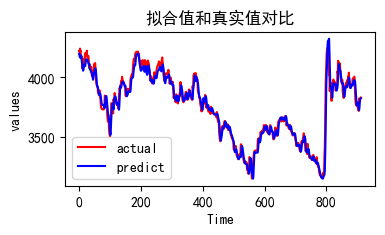

运行时间为 55.571 秒
LSTM 的预测效果为：MSE: 23.876, RMSE: 4.886, MAE: 3.388, MAPE: 0.009
======================================= 运行结束 ==========================================

=== 正在测试学习率: 0.001 ===
Epoch 1/1000
114/114 [==============================] - 9s 25ms/step - loss: 0.3257 - root_mean_squared_error: 0.5510 - mape: 104885.5938 - mae: 0.3673 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0234 - val_mape: 3.6447 - val_mae: 0.0158
Epoch 2/1000
114/114 [==============================] - 2s 13ms/step - loss: 0.0604 - root_mean_squared_error: 0.1962 - mape: 20571.5996 - mae: 0.1551 - val_loss: 0.0284 - val_root_mean_squared_error: 0.0810 - val_mape: 18.0761 - val_mae: 0.0793
Epoch 3/1000
114/114 [==============================] - 2s 14ms/step - loss: 0.0404 - root_mean_squared_error: 0.1366 - mape: 16856.4609 - mae: 0.1079 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0484 - val_mape: 9.9891 - val_mae: 0.0443
Epoch 4/1000
114/114 [==============================] - 2s 13ms/step - los

Epoch 34/1000
114/114 [==============================] - 2s 17ms/step - loss: 0.0109 - root_mean_squared_error: 0.0416 - mape: 4015.1538 - mae: 0.0319 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0265 - val_mape: 4.5981 - val_mae: 0.0211
Epoch 35/1000
114/114 [==============================] - 2s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.0410 - mape: 4585.6821 - mae: 0.0312 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0175 - val_mape: 2.6966 - val_mae: 0.0119
Epoch 36/1000
114/114 [==============================] - 2s 16ms/step - loss: 0.0099 - root_mean_squared_error: 0.0380 - mape: 7889.9609 - mae: 0.0284 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0264 - val_mape: 4.5242 - val_mae: 0.0210
Epoch 37/1000
114/114 [==============================] - 2s 17ms/step - loss: 0.0097 - root_mean_squared_error: 0.0392 - mape: 5926.0522 - mae: 0.0297 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0184 - val_mape: 3.1563 - val_mae: 0.0136
Epoch 38/1000
114/11

114/114 [==============================] - 2s 18ms/step - loss: 9.7090e-04 - root_mean_squared_error: 0.0262 - mape: 17095.9531 - mae: 0.0194 - val_loss: 9.8570e-04 - val_root_mean_squared_error: 0.0265 - val_mape: 5.6757 - val_mae: 0.0252
Epoch 101/1000
114/114 [==============================] - 2s 16ms/step - loss: 9.9947e-04 - root_mean_squared_error: 0.0268 - mape: 9257.2344 - mae: 0.0199 - val_loss: 3.8516e-04 - val_root_mean_squared_error: 0.0102 - val_mape: 1.6023 - val_mae: 0.0072
Epoch 102/1000
114/114 [==============================] - 2s 19ms/step - loss: 9.9465e-04 - root_mean_squared_error: 0.0269 - mape: 8802.3428 - mae: 0.0202 - val_loss: 4.0221e-04 - val_root_mean_squared_error: 0.0115 - val_mape: 2.1867 - val_mae: 0.0092
Epoch 103/1000
114/114 [==============================] - 2s 19ms/step - loss: 0.0010 - root_mean_squared_error: 0.0273 - mape: 7046.8501 - mae: 0.0204 - val_loss: 3.6873e-04 - val_root_mean_squared_error: 0.0104 - val_mape: 1.7289 - val_mae: 0.0077
Ep

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_5788\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


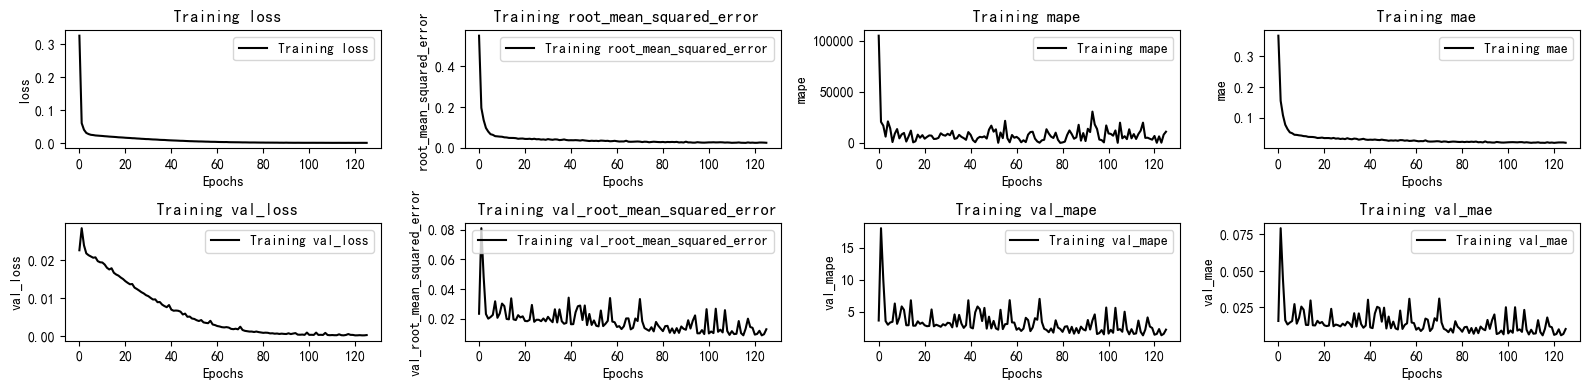

29/29 [==============================] - 1s 5ms/step


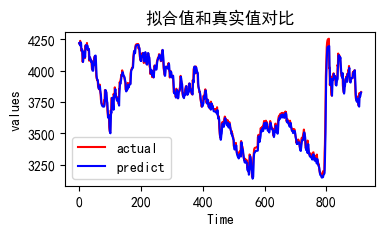

运行时间为 247.938 秒
LSTM 的预测效果为：MSE: 12.237, RMSE: 3.498, MAE: 2.328, MAPE: 0.006
======================================= 运行结束 ==========================================

=== 学习率性能对比 ===
Learning Rate: 0.1000 | Test Loss: 0.1274 | RMSE: 0.3245
Learning Rate: 0.0100 | Test Loss: 0.1274 | RMSE: 0.3245
Learning Rate: 0.0010 | Test Loss: 0.1274 | RMSE: 0.3245


In [12]:
window_size = 9
train_ratio = 0.8
learning_rates = [0.1, 0.01, 0.001]  # 需要测试的学习率列表
results = {}

# 数据准备（保持不变）
X_train, y_train, X_test, y_test = get_traintest(np.c_[X,y], 
                                                window_size=window_size,
                                                train_ratio=train_ratio)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

for current_lr in learning_rates:
    print(f"\n=== 正在测试学习率: {current_lr} ===")
    
    # 动态重定义build_model
    def build_model(X_train, mode='LSTM', hidden_dim=[32,16]):
        set_my_seed()
        model = Sequential()
        input_shape = (window_size, X_train.shape[-1])
        
        if mode == 'LSTM':
            model.add(LSTM(
                units=64, 
                return_sequences=True, 
                input_shape=input_shape,
                kernel_initializer='he_normal'
            ))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
            model.add(LSTM(
                units=64,
                return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                recurrent_regularizer=tf.keras.regularizers.L2(1e-5)
            ))
            model.add(LSTM(units=64, return_sequences=False))
            model.add(LayerNormalization())
            model.add(Dropout(0.2))
        
        model.add(Dense(1))
        # 使用当前循环的学习率
        optimizer = tf.keras.optimizers.Adam(learning_rate=current_lr)  # 动态绑定
        model.compile(optimizer=optimizer, loss='mse',
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
        return model

    # 训练与评估
    model = build_model(X_train)
    hist = train_model(train_fuc, **params['LSTM'])
    
    # 记录测试集结果
    test_loss, rmse, mape, mae = model.evaluate(X_test, y_test, verbose=0)
    results[current_lr] = {
        'test_loss': test_loss,
        'rmse': rmse,
        'mape': mape,
        'mae': mae
    }
    
    # 清理计算图
    tf.keras.backend.clear_session()

# 结果展示
print("\n=== 学习率性能对比 ===")
for lr, metrics in results.items():
    print(f"Learning Rate: {lr:.4f} | "
          f"Test Loss: {metrics['test_loss']:.4f} | "
          f"RMSE: {metrics['rmse']:.4f}")

In [14]:
from tabulate import tabulate

# 定义表格数据
data = [
    ["学习率为0.1", 908.164, 30.136, 25.88, 0.068],
    ["学习率为0.01", 23.876, 4.886, 3.388, 0.009],
    ["学习率为0.001", 12.237, 3.498, 2.328, 0.006]
]

# 定义表头
headers = ["学习率", "MSE", "RMSE", "MAE", "MAPE"]

# 打印表格
print(tabulate(data, headers, tablefmt="grid"))


+---------------+---------+--------+--------+--------+
| 学习率        |     MSE |   RMSE |    MAE |   MAPE |
+===============+=========+========+========+========+
| 学习率为0.1   | 908.164 | 30.136 | 25.88  |  0.068 |
+---------------+---------+--------+--------+--------+
| 学习率为0.01  |  23.876 |  4.886 |  3.388 |  0.009 |
+---------------+---------+--------+--------+--------+
| 学习率为0.001 |  12.237 |  3.498 |  2.328 |  0.006 |
+---------------+---------+--------+--------+--------+


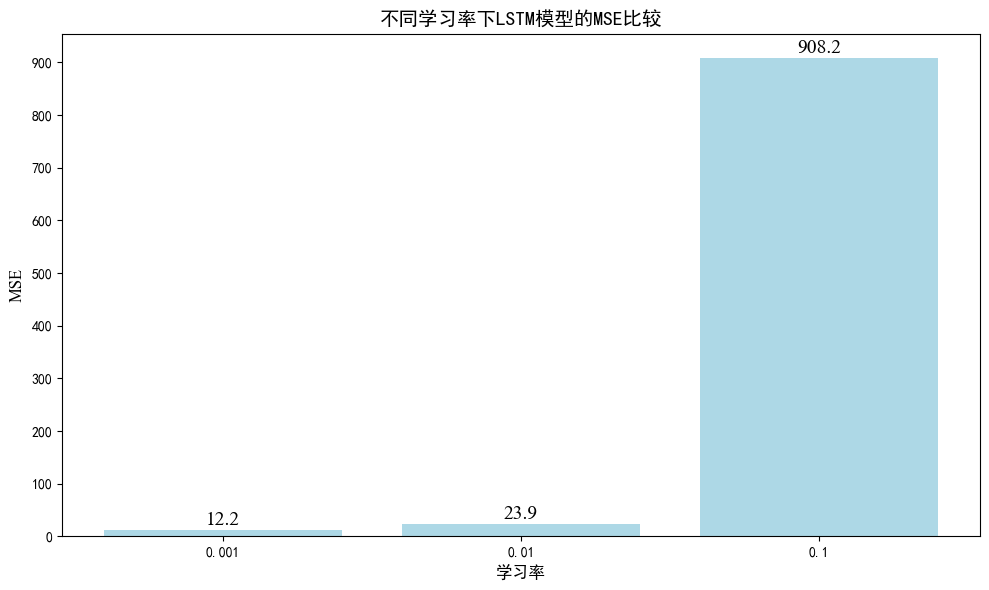

In [43]:
import matplotlib.pyplot as plt

# 隐藏层单元数和对应的 MSE 值
learning_rates = ['0.001', '0.01', '0.1']
mse_values = [12.237, 23.876,908.164]

# 设置柱子的位置，使其均匀分布
x_pos = [0, 1, 2]

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图表大小

# 绘制浅蓝色柱状图
plt.bar(x_pos, mse_values, color='lightblue')

# 添加标题和轴标签
plt.title('不同学习率下LSTM模型的MSE比较',fontsize=14)
plt.xlabel('学习率', fontsize=12)
plt.ylabel('MSE', fontsize=12, fontfamily='Times New Roman')

# 设置横轴的标签
plt.xticks(x_pos, learning_rates)  # 横轴标签为隐藏层单元数

# 设置纵轴刻度
plt.yticks([0, 100, 200,300,400,500,600,700,800,900])

# 在每个柱子上添加数值标签
for i, value in enumerate(mse_values):
    plt.text(x_pos[i], value + 2, f'{value:.1f}', ha='center', va='bottom',fontfamily='Times New Roman',fontsize=14,)
# 调整布局并显示图表
plt.tight_layout()
plt.savefig('隐藏层单元数对MSE的影响.png', dpi=300, bbox_inches='tight')
plt.show()

## 5.5不同CNN卷积核个数下的CNN+LSTM模型比较


=== 正在测试卷积核数量: 16 ===
Epoch 1/1000
114/114 [==============================] - 4s 22ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - mape: 7096.5400 - mae: 0.0399 - val_loss: 4.0427e-04 - val_root_mean_squared_error: 0.0201 - val_mape: 2.8719 - val_mae: 0.0130
Epoch 2/1000
114/114 [==============================] - 2s 19ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - mape: 6764.6328 - mae: 0.0244 - val_loss: 4.3522e-04 - val_root_mean_squared_error: 0.0209 - val_mape: 3.3676 - val_mae: 0.0148
Epoch 3/1000
114/114 [==============================] - 2s 18ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - mape: 4558.5991 - mae: 0.0230 - val_loss: 4.5813e-04 - val_root_mean_squared_error: 0.0214 - val_mape: 3.2665 - val_mae: 0.0151
Epoch 4/1000
114/114 [==============================] - 2s 18ms/step - loss: 8.7222e-04 - root_mean_squared_error: 0.0295 - mape: 8429.2002 - mae: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342 - val_mape: 6.4977 - v

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


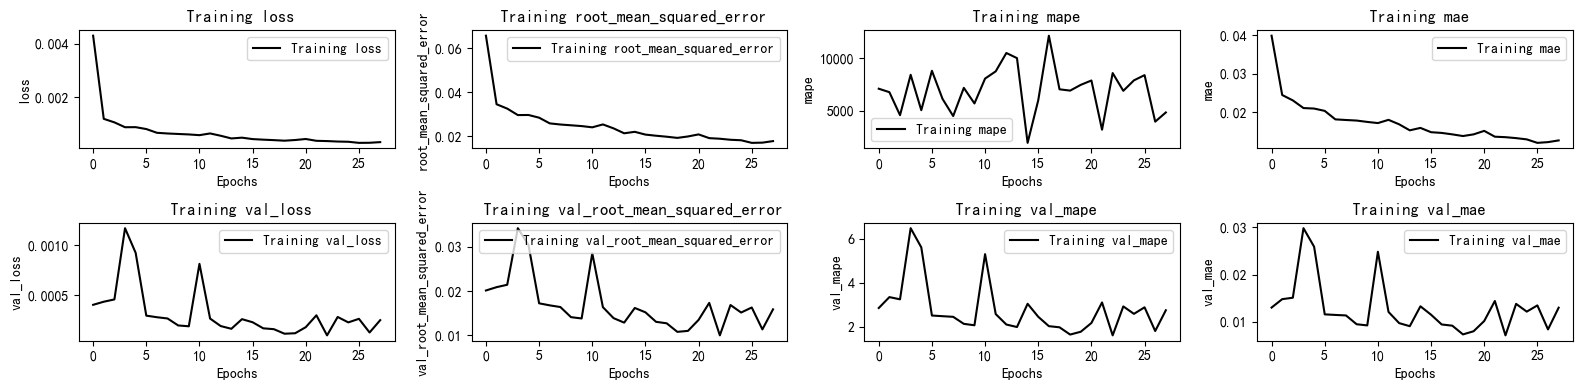

29/29 [==============================] - 1s 7ms/step


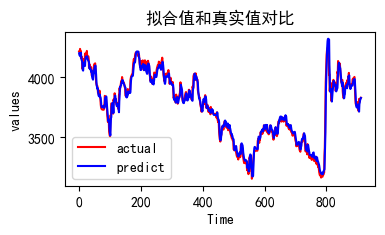

运行时间为 73.374 秒
CNN+LSTM 的预测效果为：MSE: 13.79, RMSE: 3.713, MAE: 2.665, MAPE: 0.007
======================================= 运行结束 ==========================================

=== 正在测试卷积核数量: 32 ===
Epoch 1/1000
114/114 [==============================] - 5s 27ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - mape: 6068.5688 - mae: 0.0444 - val_loss: 4.4318e-04 - val_root_mean_squared_error: 0.0211 - val_mape: 3.0894 - val_mae: 0.0142
Epoch 2/1000
114/114 [==============================] - 2s 19ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - mape: 8680.9463 - mae: 0.0239 - val_loss: 3.9154e-04 - val_root_mean_squared_error: 0.0198 - val_mape: 3.1481 - val_mae: 0.0139
Epoch 3/1000
114/114 [==============================] - 2s 19ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - mape: 4940.4526 - mae: 0.0227 - val_loss: 2.8721e-04 - val_root_mean_squared_error: 0.0169 - val_mape: 2.4865 - val_mae: 0.0111
Epoch 4/1000
114/114 [==============================] - 2s 19ms/s

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


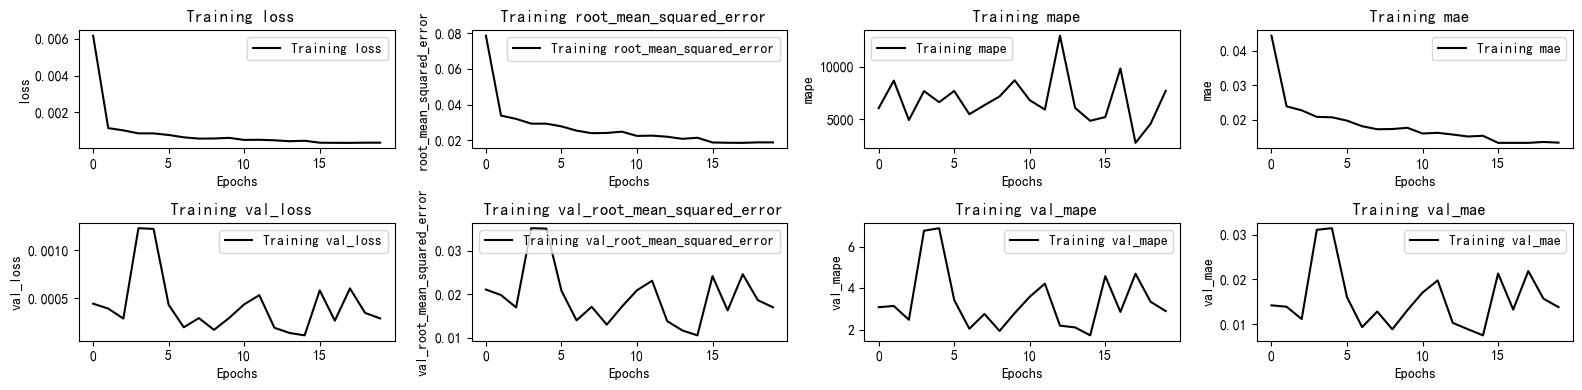

29/29 [==============================] - 0s 5ms/step


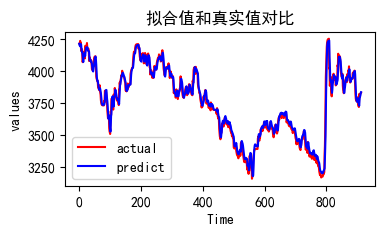

运行时间为 47.948 秒
CNN+LSTM 的预测效果为：MSE: 15.471, RMSE: 3.933, MAE: 2.79, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在测试卷积核数量: 64 ===
Epoch 1/1000
114/114 [==============================] - 5s 31ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - mape: 5424.7451 - mae: 0.0449 - val_loss: 3.9297e-04 - val_root_mean_squared_error: 0.0198 - val_mape: 2.8552 - val_mae: 0.0130
Epoch 2/1000
114/114 [==============================] - 3s 28ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - mape: 6091.5435 - mae: 0.0240 - val_loss: 3.8012e-04 - val_root_mean_squared_error: 0.0195 - val_mape: 3.0202 - val_mae: 0.0133
Epoch 3/1000
114/114 [==============================] - 3s 28ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - mape: 4859.1069 - mae: 0.0229 - val_loss: 4.8709e-04 - val_root_mean_squared_error: 0.0221 - val_mape: 3.4766 - val_mae: 0.0161
Epoch 4/1000
114/114 [==============================] - 3s 28ms/s

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


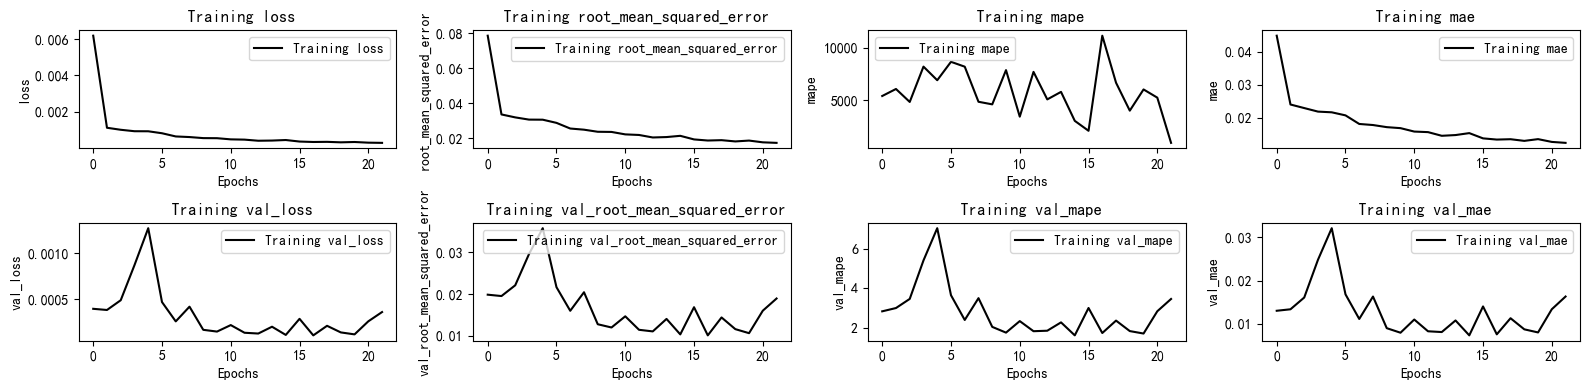

29/29 [==============================] - 0s 9ms/step


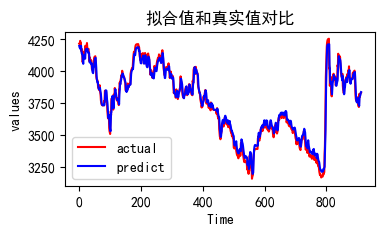

运行时间为 75.611 秒
CNN+LSTM 的预测效果为：MSE: 14.157, RMSE: 3.763, MAE: 2.815, MAPE: 0.008
======================================= 运行结束 ==========================================

=== 正在测试卷积核数量: 128 ===
Epoch 1/1000
114/114 [==============================] - 6s 35ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - mape: 6259.2139 - mae: 0.0437 - val_loss: 3.1611e-04 - val_root_mean_squared_error: 0.0178 - val_mape: 2.5644 - val_mae: 0.0115
Epoch 2/1000
114/114 [==============================] - 3s 30ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - mape: 8186.2778 - mae: 0.0232 - val_loss: 2.7384e-04 - val_root_mean_squared_error: 0.0165 - val_mape: 2.3952 - val_mae: 0.0108
Epoch 3/1000
114/114 [==============================] - 4s 34ms/step - loss: 9.2535e-04 - root_mean_squared_error: 0.0304 - mape: 4809.9380 - mae: 0.0215 - val_loss: 3.1853e-04 - val_root_mean_squared_error: 0.0178 - val_mape: 2.7428 - val_mae: 0.0126
Epoch 4/1000
114/114 [==============================] - 4s 

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


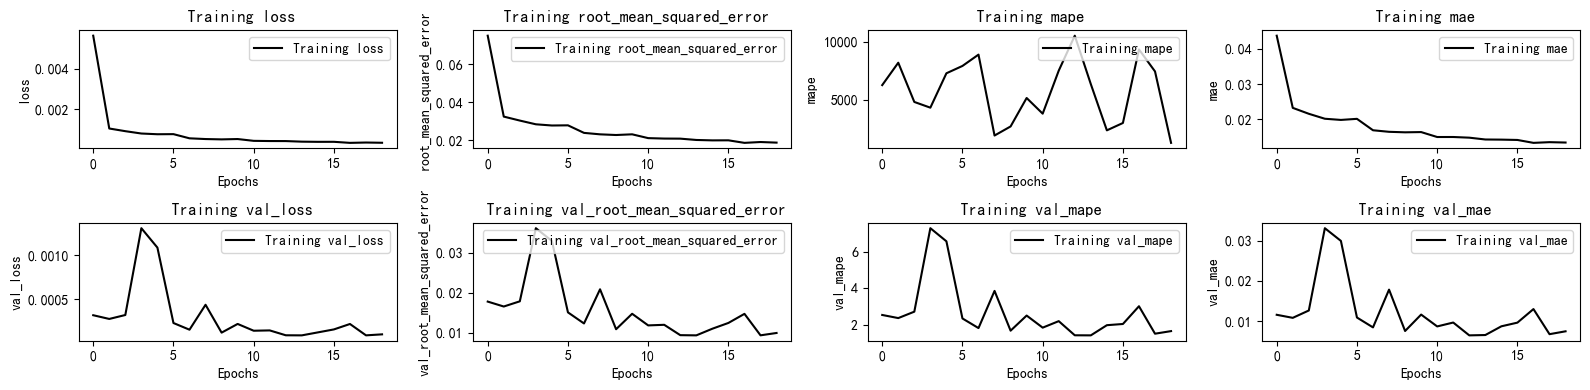

29/29 [==============================] - 0s 7ms/step


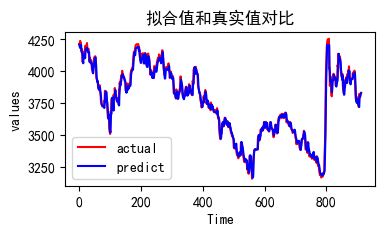

运行时间为 70.604 秒
CNN+LSTM 的预测效果为：MSE: 12.131, RMSE: 3.483, MAE: 2.423, MAPE: 0.006
======================================= 运行结束 ==========================================

=== 正在测试卷积核数量: 256 ===
Epoch 1/1000
114/114 [==============================] - 7s 44ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - mape: 6512.1440 - mae: 0.0453 - val_loss: 3.5352e-04 - val_root_mean_squared_error: 0.0188 - val_mape: 2.8285 - val_mae: 0.0126
Epoch 2/1000
114/114 [==============================] - 5s 41ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - mape: 7075.4438 - mae: 0.0236 - val_loss: 3.0969e-04 - val_root_mean_squared_error: 0.0176 - val_mape: 2.5187 - val_mae: 0.0114
Epoch 3/1000
114/114 [==============================] - 5s 42ms/step - loss: 9.7451e-04 - root_mean_squared_error: 0.0312 - mape: 4903.1914 - mae: 0.0222 - val_loss: 5.1690e-04 - val_root_mean_squared_error: 0.0227 - val_mape: 3.8253 - val_mae: 0.0176
Epoch 4/1000
114/114 [==============================] - 5s 

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


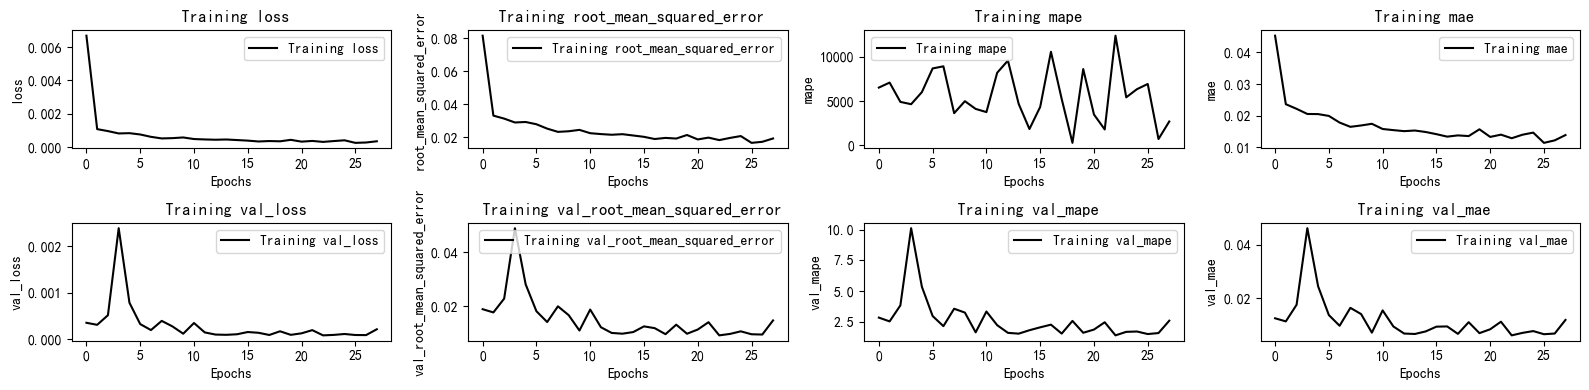

29/29 [==============================] - 1s 10ms/step


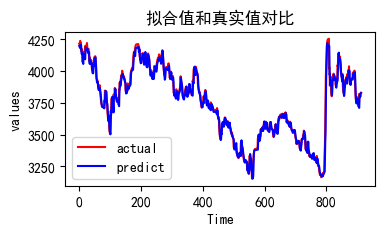

运行时间为 137.82 秒
CNN+LSTM 的预测效果为：MSE: 11.443, RMSE: 3.383, MAE: 2.317, MAPE: 0.006
======================================= 运行结束 ==========================================

=== 正在测试卷积核数量: 512 ===
Epoch 1/1000
114/114 [==============================] - 7s 47ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - mape: 7877.1436 - mae: 0.0414 - val_loss: 4.4355e-04 - val_root_mean_squared_error: 0.0211 - val_mape: 3.5079 - val_mae: 0.0155
Epoch 2/1000
114/114 [==============================] - 5s 45ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - mape: 6245.3032 - mae: 0.0235 - val_loss: 2.9174e-04 - val_root_mean_squared_error: 0.0171 - val_mape: 2.4806 - val_mae: 0.0111
Epoch 3/1000
114/114 [==============================] - 5s 44ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - mape: 6311.1680 - mae: 0.0222 - val_loss: 4.2932e-04 - val_root_mean_squared_error: 0.0207 - val_mape: 3.3174 - val_mae: 0.0153
Epoch 4/1000
114/114 [==============================] - 5s 44ms

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_15336\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


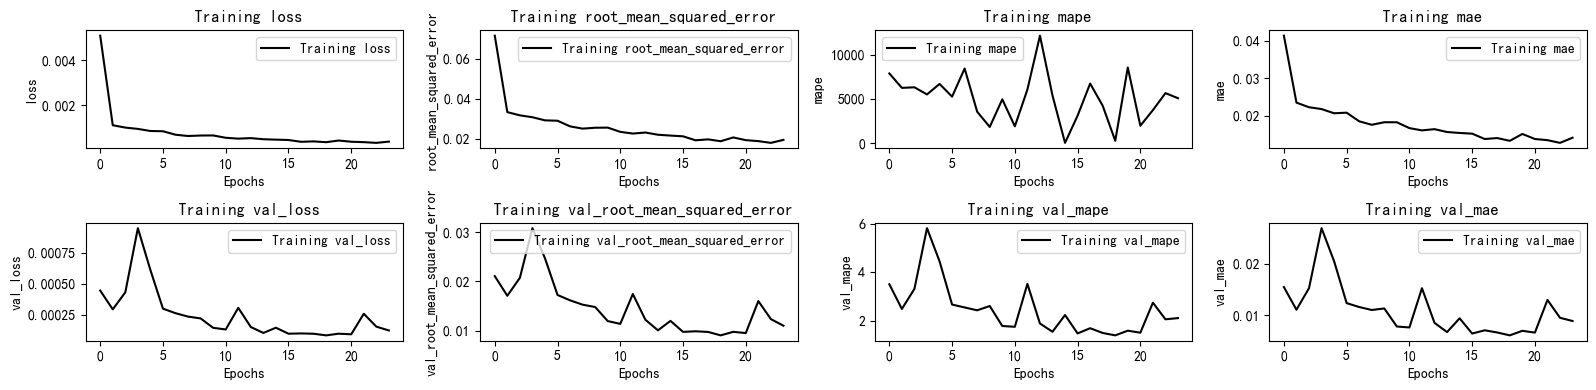

29/29 [==============================] - 1s 12ms/step


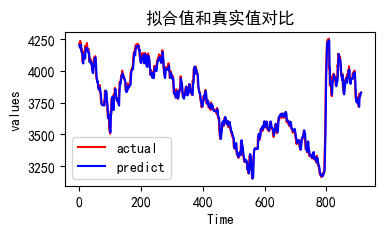

运行时间为 118.046 秒
CNN+LSTM 的预测效果为：MSE: 11.434, RMSE: 3.381, MAE: 2.298, MAPE: 0.006
======================================= 运行结束 ==========================================

=== 卷积核数量性能对比 ===
Filters:  16 | Test Loss: 0.2831 | RMSE: 0.5321
Filters:  32 | Test Loss: 0.1460 | RMSE: 0.3822
Filters:  64 | Test Loss: 0.3011 | RMSE: 0.5488
Filters: 128 | Test Loss: 0.2663 | RMSE: 0.5161
Filters: 256 | Test Loss: 0.2072 | RMSE: 0.4552
Filters: 512 | Test Loss: 0.2067 | RMSE: 0.4547


In [40]:
# 配置实验参数
filters_list = [16, 32, 64, 128, 256,512]  # 需要测试的卷积核数量
results = {}  # 存储不同配置的评估结果

# 数据准备
window_size = 11
train_ratio = 0.8
X_train, y_train, X_test, y_test = get_traintest(np.c_[X,y], 
                                                window_size=window_size,
                                                train_ratio=train_ratio)

for current_filters in filters_list:
    print(f"\n=== 正在测试卷积核数量: {current_filters} ===")
    
    # 动态重定义模型构建函数
    def build_model(X_train, mode='CNN+LSTM', hidden_dim=[32,16]):
        set_my_seed()
        model = Sequential()
        
        if mode == 'CNN+LSTM':
            # 动态使用当前卷积核数量
            model.add(Conv1D(
                filters=current_filters,
                kernel_size=2,
                activation='relu',
                input_shape=(X_train.shape[-2], X_train.shape[-1])
            ))
            model.add(MaxPooling1D(pool_size=1))
            model.add(LSTM(hidden_dim[0]))
            model.add(Dropout(0.2))
            model.add(Dense(hidden_dim[1], activation='relu'))
        
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse',
                     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
        return model

    # 执行训练和评估
    model = build_model(X_train)
    hist = train_model(train_fuc, **params['CNN+LSTM'])
    
    # 记录测试集结果
    test_loss, rmse, mape, mae = model.evaluate(X_test, y_test, verbose=0)
    results[current_filters] = {
        'test_loss': test_loss,
        'rmse': rmse,
        'mape': mape,
        'mae': mae
    }
    
    # 清理计算图
    tf.keras.backend.clear_session()

# 打印结果对比
print("\n=== 卷积核数量性能对比 ===")
for filters, metrics in results.items():
    print(f"Filters: {filters:3d} | "
          f"Test Loss: {metrics['test_loss']:.4f} | "
          f"RMSE: {metrics['rmse']:.4f}")

In [15]:
from tabulate import tabulate

# 定义表格数据
data = [
    ["卷积核数量为16", 13.79, 3.713, 2.665, 0.007],
    ["卷积核数量为32", 15.471, 3.933, 2.79, 0.008],
    ["卷积核数量为64", 14.157, 3.763, 2.815, 0.008],
    ["卷积核数量为128", 12.131, 3.483, 2.423, 0.006],
    ["卷积核数量为256", 11.443, 3.383, 2.317, 0.006],
    ["卷积核数量为512", 12.237, 3.498, 2.328, 0.006]
]

# 定义表头
headers = ["卷积核数量", "MSE", "RMSE", "MAE", "MAPE"]

# 打印表格
print(tabulate(data, headers, tablefmt="grid"))


+-----------------+--------+--------+-------+--------+
| 卷积核数量      |    MSE |   RMSE |   MAE |   MAPE |
+=================+========+========+=======+========+
| 卷积核数量为16  | 13.79  |  3.713 | 2.665 |  0.007 |
+-----------------+--------+--------+-------+--------+
| 卷积核数量为32  | 15.471 |  3.933 | 2.79  |  0.008 |
+-----------------+--------+--------+-------+--------+
| 卷积核数量为64  | 14.157 |  3.763 | 2.815 |  0.008 |
+-----------------+--------+--------+-------+--------+
| 卷积核数量为128 | 12.131 |  3.483 | 2.423 |  0.006 |
+-----------------+--------+--------+-------+--------+
| 卷积核数量为256 | 11.443 |  3.383 | 2.317 |  0.006 |
+-----------------+--------+--------+-------+--------+
| 卷积核数量为512 | 12.237 |  3.498 | 2.328 |  0.006 |
+-----------------+--------+--------+-------+--------+


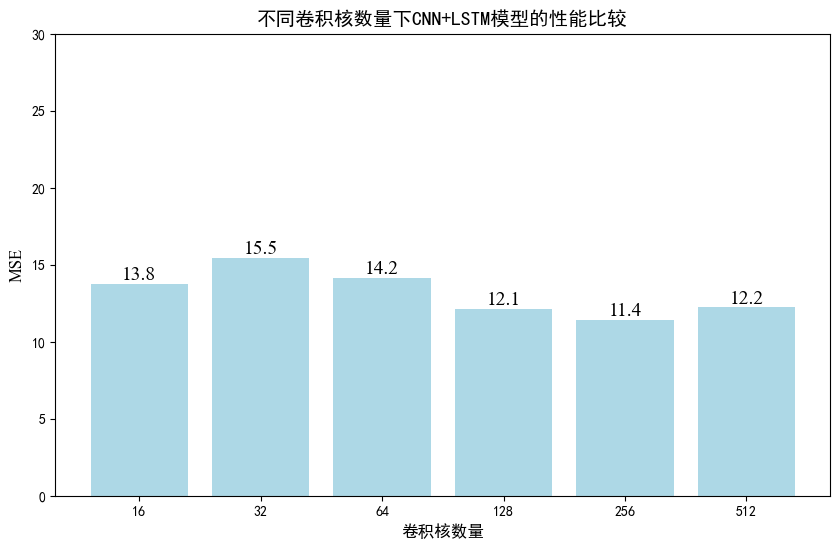

In [42]:
import matplotlib.pyplot as plt

# 隐藏层单元数和对应的 MSE 值
conv_filters = [16, 32, 64, 128, 256,512]
mse_values =[13.79, 15.471, 14.157, 12.131, 11.443,12.237]
# 设置柱子的位置，使其均匀分布
x_pos = [0, 1, 2,3,4,5]

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图表大小

# 绘制浅蓝色柱状图
plt.bar(x_pos, mse_values, color='lightblue')

# 添加标题和轴标签
plt.title('不同卷积核数量下CNN+LSTM模型的性能比较',fontsize=14)
plt.xlabel('卷积核数量', fontsize=12)
plt.ylabel('MSE', fontsize=12, fontfamily='Times New Roman')

# 设置横轴的标签
plt.xticks(x_pos, conv_filters)  # 横轴标签为隐藏层单元数

# 设置纵轴刻度
plt.yticks([0,5,10,15,20,25,30])

# 在每个柱子上添加数值标签
for i, value in enumerate(mse_values):
    plt.text(x_pos[i], value, f'{value:.1f}', ha='center', va='bottom',fontfamily='Times New Roman',fontsize=14,)
# 调整布局并显示图表
plt.show()

## 5.6其他传统模型（GRU、BiLSTM）

In [19]:
train_ratio=0.8     #训练集比例   
window_size=9 #滑动窗口大小
X_train,y_train,X_test,y_test=get_traintest(np.c_[X,y],window_size=window_size,train_ratio=train_ratio)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    window_size=9
    input_shape = (window_size, X_train.shape[-1]) 
    if mode=='GRU':
        #GRU
        model.add(GRU(
            hidden_dim[0], 
            return_sequences=True, 
            input_shape=input_shape,  
            kernel_regularizer=l2(0.01)
        ))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))
        model.add(GRU(hidden_dim[1], return_sequences=False))
        model.add(LayerNormalization())
        model.add(Dropout(0.3))
    
        model.add(Dense(1))
    elif mode=='BiLSTM':
        model.add(Bidirectional(
            LSTM(hidden_dim[0], return_sequences=True),
            input_shape=input_shape  
        ))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(hidden_dim[1])))
        model.add(Dropout(0.2))

    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model

(3642, 9, 4) (3642,) (913, 9, 4) (913,)


Epoch 1/1000
114/114 [==============================] - 4s 11ms/step - loss: 0.3691 - root_mean_squared_error: 0.5585 - mape: 4715.0352 - mae: 0.4269 - val_loss: 0.0452 - val_root_mean_squared_error: 0.0653 - val_mape: 10.9376 - val_mae: 0.0531
Epoch 2/1000
114/114 [==============================] - 1s 7ms/step - loss: 0.1314 - root_mean_squared_error: 0.3139 - mape: 24798.6719 - mae: 0.2498 - val_loss: 0.0297 - val_root_mean_squared_error: 0.0514 - val_mape: 10.7100 - val_mae: 0.0425
Epoch 3/1000
114/114 [==============================] - 1s 7ms/step - loss: 0.0761 - root_mean_squared_error: 0.2276 - mape: 138881.8906 - mae: 0.1824 - val_loss: 0.0241 - val_root_mean_squared_error: 0.0424 - val_mape: 8.8066 - val_mae: 0.0353
Epoch 4/1000
114/114 [==============================] - 1s 7ms/step - loss: 0.0506 - root_mean_squared_error: 0.1717 - mape: 57287.0430 - mae: 0.1364 - val_loss: 0.0216 - val_root_mean_squared_error: 0.0383 - val_mape: 7.8626 - val_mae: 0.0320
Epoch 5/1000
114/114 

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_18368\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


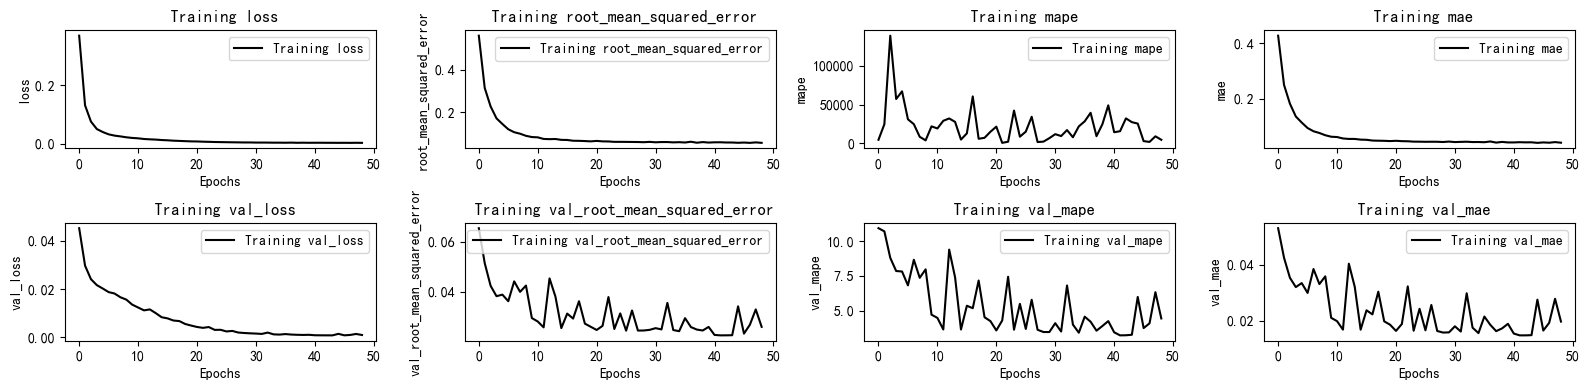

29/29 [==============================] - 0s 2ms/step


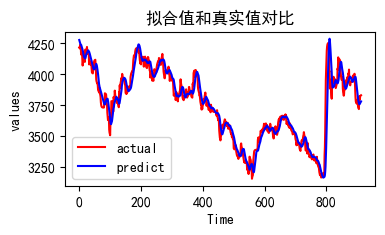

运行时间为 44.878 秒
GRU 的预测效果为：MSE: 72.405, RMSE: 8.509, MAE: 5.518, MAPE: 0.015
======================================= 运行结束 ==========================================


In [22]:
hist = train_model(train_fuc, **params['GRU'])

Epoch 1/1000
114/114 [==============================] - 9s 19ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - mape: 17140.4004 - mae: 0.0724 - val_loss: 5.6405e-04 - val_root_mean_squared_error: 0.0237 - val_mape: 3.3609 - val_mae: 0.0153
Epoch 2/1000
114/114 [==============================] - 1s 8ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - mape: 11534.6816 - mae: 0.0402 - val_loss: 5.8547e-04 - val_root_mean_squared_error: 0.0242 - val_mape: 3.8050 - val_mae: 0.0170
Epoch 3/1000
114/114 [==============================] - 1s 8ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - mape: 6686.2173 - mae: 0.0372 - val_loss: 4.6282e-04 - val_root_mean_squared_error: 0.0215 - val_mape: 3.0261 - val_mae: 0.0137
Epoch 4/1000
114/114 [==============================] - 1s 7ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - mape: 5700.6582 - mae: 0.0375 - val_loss: 5.2545e-04 - val_root_mean_squared_error: 0.0229 - val_mape: 3.2575 - val_mae: 0.0149
Epoch 5/1

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_9460\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


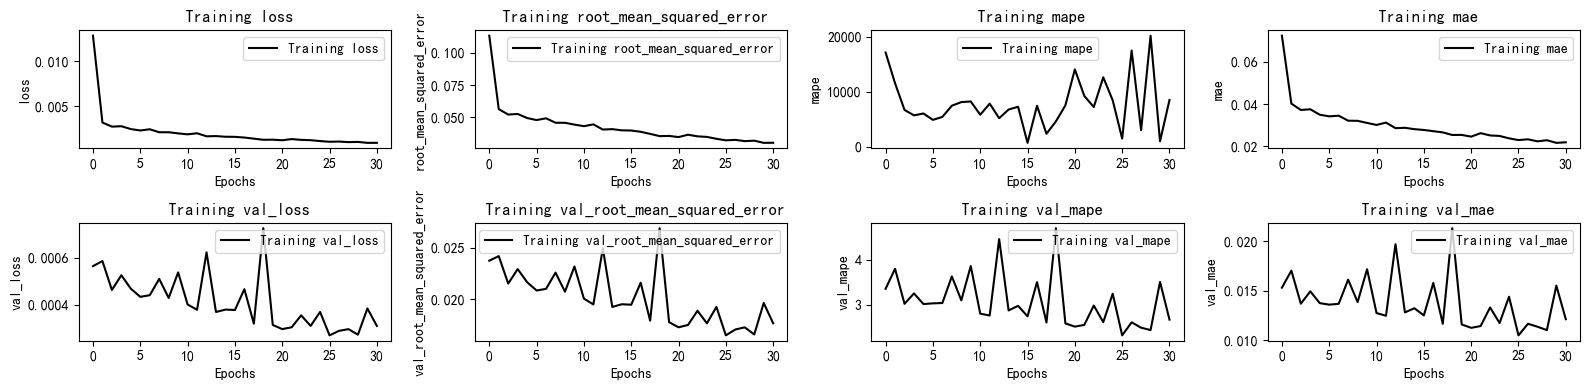

29/29 [==============================] - 1s 3ms/step


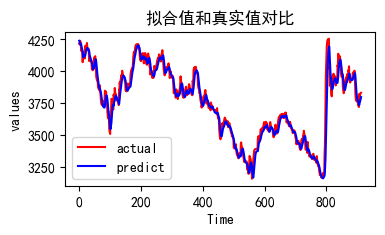

运行时间为 38.418 秒
BiLSTM 的预测效果为：MSE: 37.639, RMSE: 6.135, MAE: 3.909, MAPE: 0.01
======================================= 运行结束 ==========================================


In [20]:
hist = train_model(train_fuc, **params['BiLSTM'])

In [17]:
################################################################
#
#LSTM模型配置：滑动窗口为9，隐藏层单元数为64，学习率为0.001
#--------------------------------------------------------------#
#CNN+LSTM模型配置：CNN卷积核数256，最大池化层数1，学习率为0.001
#
################################################################

train_ratio=0.8   
window_size=9 
X_train,y_train,X_test,y_test=get_traintest(np.c_[X,y],window_size=window_size,train_ratio=train_ratio)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


def build_model(X_train,mode='LSTM',hidden_dim=[32,16]):
    set_my_seed()
    model = Sequential()
    window_size=9
    input_shape = (window_size, X_train.shape[-1]) 
    if mode=='LSTM':
        # LSTM
        model.add(LSTM(
            units=64, 
            return_sequences=True, 
            input_shape=input_shape,  
            kernel_initializer='he_normal'
        ))
        model.add(LayerNormalization())
        model.add(Dropout(0.2))
        model.add(LSTM(
            units=64,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4), 
            recurrent_regularizer=tf.keras.regularizers.L2(1e-5)  
        ))

        model.add(LSTM(units=64, return_sequences=False))  
        model.add(LayerNormalization())
        model.add(Dropout(0.2))
    elif mode == 'CNN+LSTM':
        model.add(Conv1D(
            filters=256,  
            kernel_size=2,
            activation='relu',
            input_shape=(X_train.shape[-2], X_train.shape[-1])
            ))
        model.add(MaxPooling1D(pool_size=1))
        model.add(LSTM(hidden_dim[0]))
        model.add(Dropout(0.2))
        model.add(Dense(hidden_dim[1], activation='relu'))
        
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError(),"mape","mae"])
    return model


(3642, 9, 4) (3642,) (913, 9, 4) (913,)


Epoch 1/1000
114/114 [==============================] - 5s 17ms/step - loss: 0.3257 - root_mean_squared_error: 0.5510 - mape: 104885.5938 - mae: 0.3673 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0234 - val_mape: 3.6447 - val_mae: 0.0158
Epoch 2/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.0604 - root_mean_squared_error: 0.1962 - mape: 20571.5996 - mae: 0.1551 - val_loss: 0.0284 - val_root_mean_squared_error: 0.0810 - val_mape: 18.0761 - val_mae: 0.0793
Epoch 3/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.0404 - root_mean_squared_error: 0.1366 - mape: 16856.4609 - mae: 0.1079 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0484 - val_mape: 9.9891 - val_mae: 0.0443
Epoch 4/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.0310 - root_mean_squared_error: 0.0977 - mape: 6126.1670 - mae: 0.0772 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0232 - val_mape: 3.5525 - val_mae: 0.0162
Epoch 5/1000
114/11

114/114 [==============================] - 1s 11ms/step - loss: 0.0027 - root_mean_squared_error: 0.0298 - mape: 10595.4111 - mae: 0.0222 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0129 - val_mape: 1.9851 - val_mae: 0.0089
Epoch 68/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.0026 - root_mean_squared_error: 0.0301 - mape: 10934.4316 - mae: 0.0223 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0139 - val_mape: 2.5509 - val_mae: 0.0108
Epoch 69/1000
114/114 [==============================] - 1s 11ms/step - loss: 0.0026 - root_mean_squared_error: 0.0307 - mape: 4215.8408 - mae: 0.0228 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0202 - val_mape: 4.0026 - val_mae: 0.0176
Epoch 70/1000
114/114 [==============================] - 1s 12ms/step - loss: 0.0025 - root_mean_squared_error: 0.0312 - mape: 1424.7942 - mae: 0.0234 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0185 - val_mape: 3.7633 - val_mae: 0.0159
Epoch 71/1000
114/114 [=========

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_18368\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


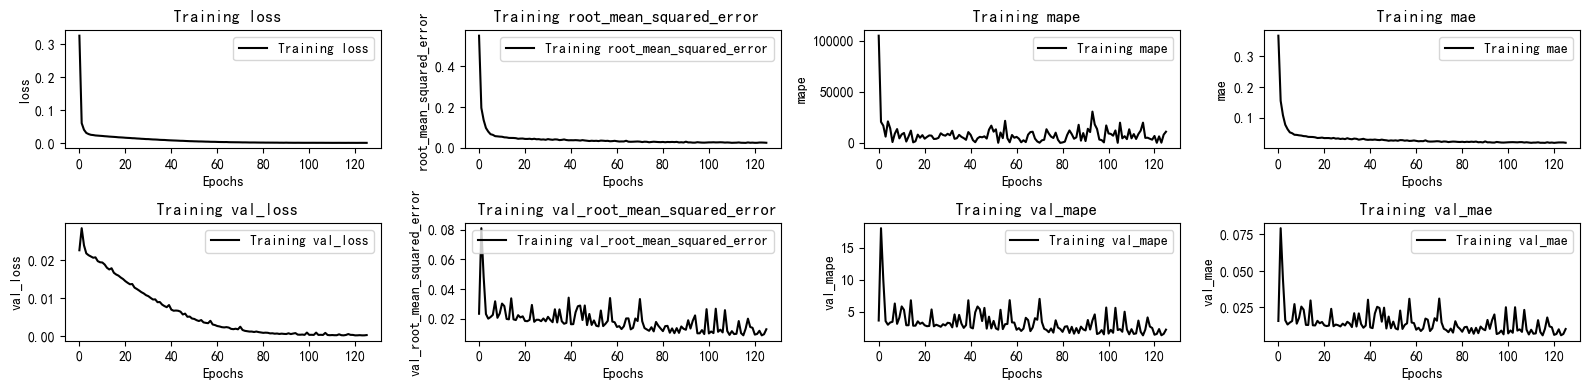

29/29 [==============================] - 1s 4ms/step


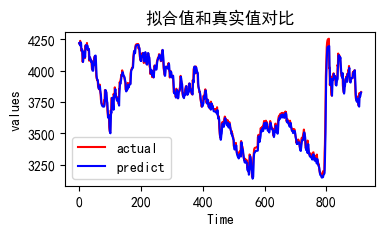

运行时间为 170.861 秒
LSTM 的预测效果为：MSE: 12.237, RMSE: 3.498, MAE: 2.328, MAPE: 0.006
======================================= 运行结束 ==========================================


In [18]:
hist = train_model(train_fuc, **params['LSTM'])

Epoch 1/1000
114/114 [==============================] - 3s 13ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - mape: 6900.5972 - mae: 0.0452 - val_loss: 3.4280e-04 - val_root_mean_squared_error: 0.0185 - val_mape: 2.7801 - val_mae: 0.0124
Epoch 2/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - mape: 5755.4482 - mae: 0.0233 - val_loss: 4.8851e-04 - val_root_mean_squared_error: 0.0221 - val_mape: 3.5200 - val_mae: 0.0162
Epoch 3/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - mape: 5024.9365 - mae: 0.0227 - val_loss: 3.1355e-04 - val_root_mean_squared_error: 0.0177 - val_mape: 2.6139 - val_mae: 0.0119
Epoch 4/1000
114/114 [==============================] - 1s 10ms/step - loss: 9.3338e-04 - root_mean_squared_error: 0.0306 - mape: 4470.7988 - mae: 0.0216 - val_loss: 4.5680e-04 - val_root_mean_squared_error: 0.0214 - val_mape: 3.5245 - val_mae: 0.0163
Epoch 

C:\Users\zhangqiongwen\.conda\envs\pytorch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
C:\Users\zhangqiongwen\AppData\Local\Temp\ipykernel_18368\3719406980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n)


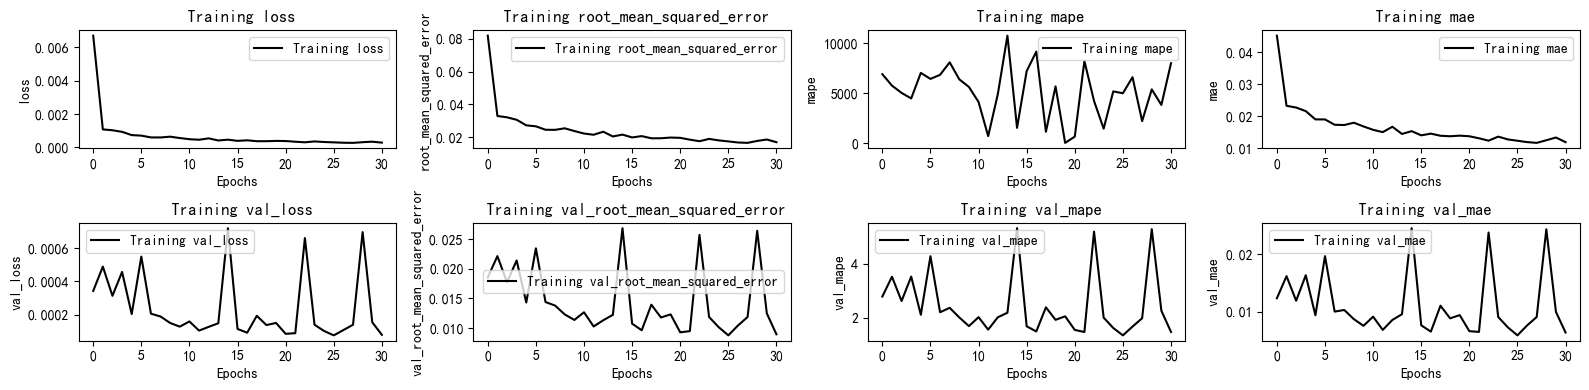

29/29 [==============================] - 0s 3ms/step


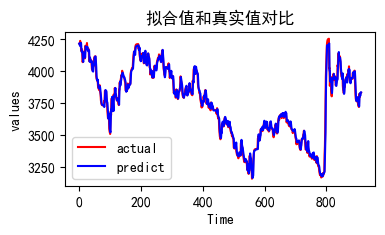

运行时间为 35.066 秒
CNN+LSTM 的预测效果为：MSE: 10.663, RMSE: 3.265, MAE: 2.204, MAPE: 0.006
======================================= 运行结束 ==========================================


In [20]:
hist = train_model(train_fuc, **params['CNN+LSTM'])

## 6.1模型评估

## 6.1.1预测与实际值对比曲线图

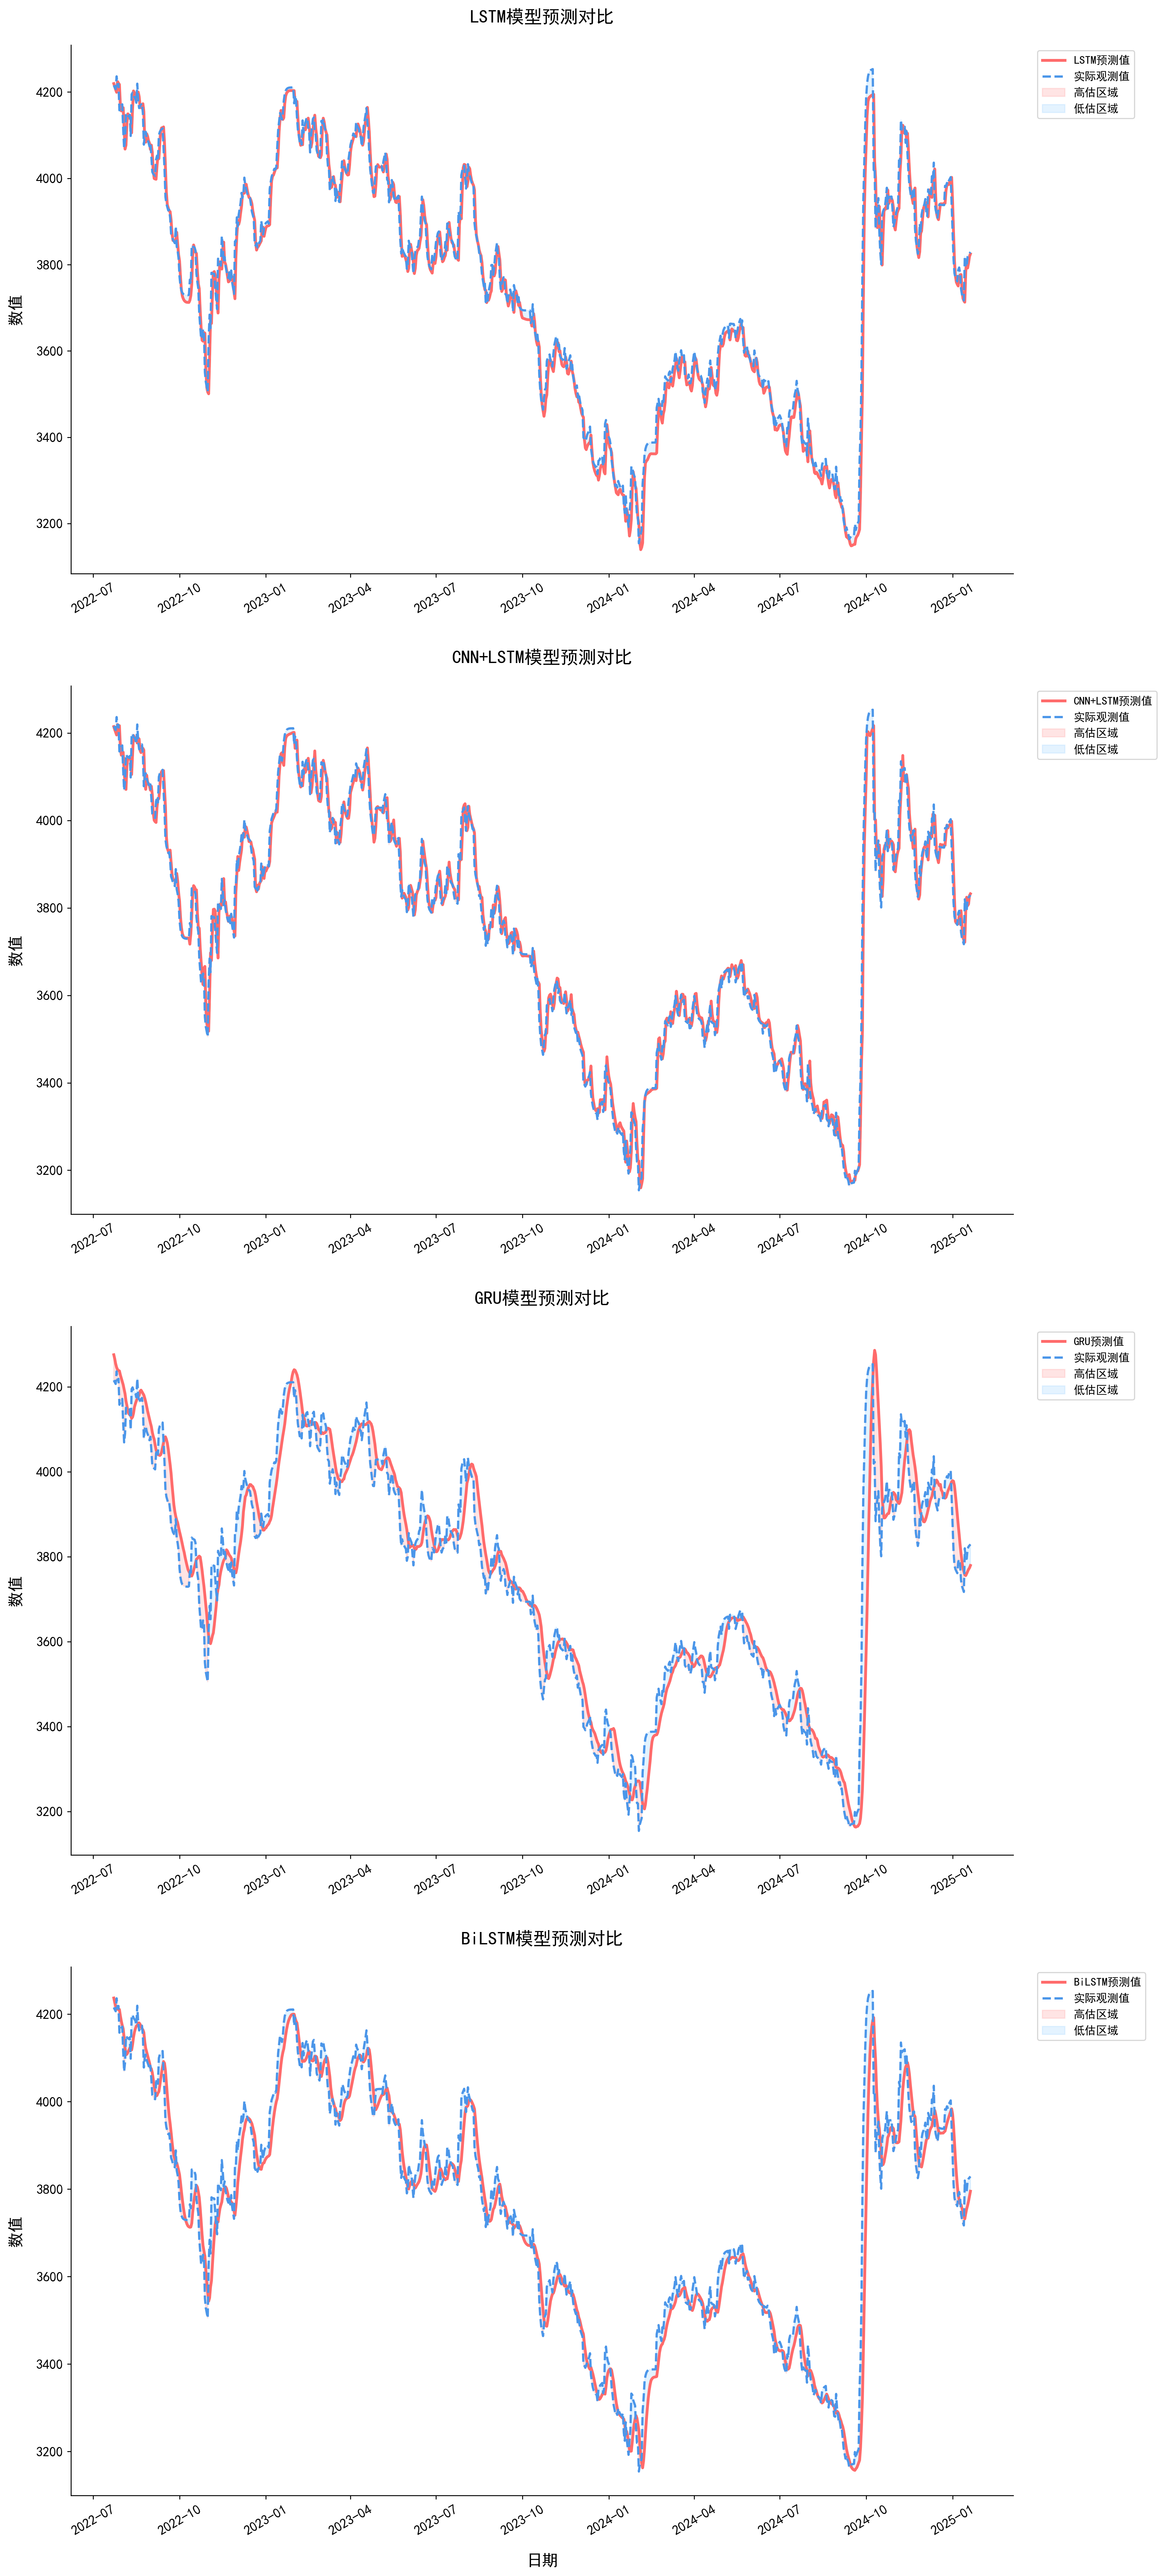

In [28]:
plt.figure(figsize=(15, 8*len(df_preds_all.columns)), dpi=256)  # 根据模型数量调整高度

# 创建垂直排列的子图
for i, col in enumerate(df_preds_all.columns, 1):
    plt.subplot(len(df_preds_all.columns), 1, i)  
    plt.plot(data0.index[-test_size-1:], df_preds_all[col], 
            label=f'{col}预测值', color='#FF6B6B', lw=2.5)  
    plt.plot(data0.index[-test_size-1:], y_test1.reshape(-1,), 
            label='实际观测值', color='#4B96E9', linestyle='--', lw=2)
    
    # 添加预测偏差填充
    plt.fill_between(data0.index[-test_size-1:],
                    df_preds_all[col], 
                    y_test1.reshape(-1,),
                    where=(df_preds_all[col] > y_test1.reshape(-1,)),
                    color='#FFA8A8', alpha=0.3, label='高估区域')
    plt.fill_between(data0.index[-test_size-1:],
                    df_preds_all[col], 
                    y_test1.reshape(-1,),
                    where=(df_preds_all[col] <= y_test1.reshape(-1,)),
                    color='#A8D8FF', alpha=0.3, label='低估区域')
    
    # 坐标轴美化
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=12, rotation=30)
    plt.yticks(fontsize=12)
    plt.ylabel('数值', fontsize=14, labelpad=12)
    plt.title(f'{col}模型预测对比', fontsize=16, pad=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') 
    

plt.tight_layout(pad=3.0)
plt.xlabel('日期', fontsize=14, labelpad=15)
plt.show()

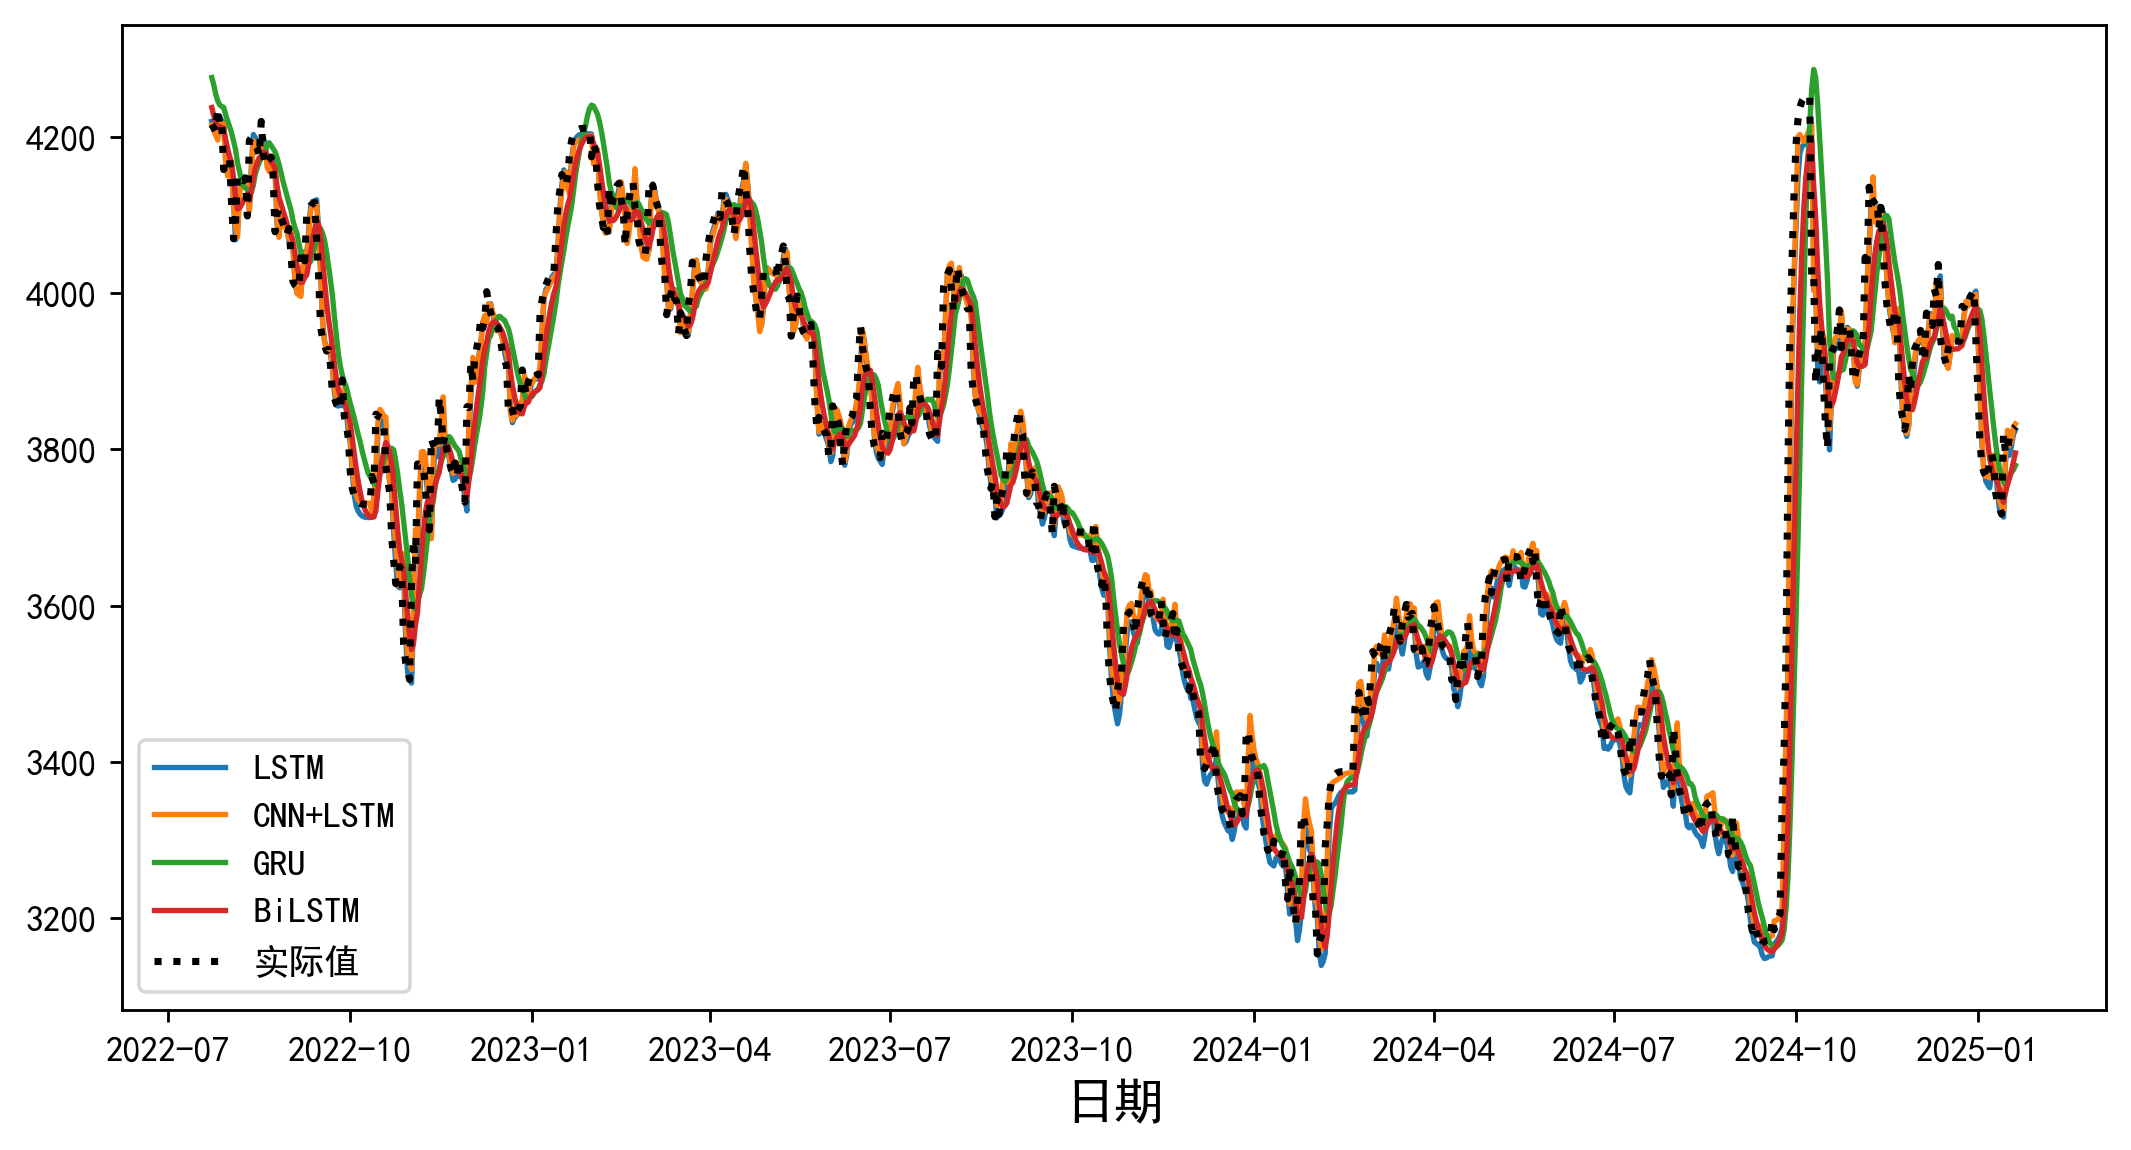

In [29]:
plt.figure(figsize=(10,5),dpi=256)
for i,col in enumerate(df_preds_all.columns):
    plt.plot(data0.index[-test_size-1:],df_preds_all[col],label=col) 

plt.plot(data0.index[-test_size-1:],y_test1.reshape(-1,),label='实际值',color='k',linestyle=':',lw=2)
plt.legend()
plt.ylabel('',fontsize=16)
plt.xlabel('日期',fontsize=14)
plt.show()

## 6.2 预测未来7日价格

### 6.2.1读取数据、加载特征、目标归一器

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

# 加载模型和预处理工具
model = load_model('lstm_model.h5')                  # 加载模型
feature_scaler = joblib.load('feature_scaler.pkl')    # 加载特征归一化器
target_scaler = joblib.load('target_scaler.pkl')      # 加载目标归一化器

# 加载新数据
new_data = pd.read_csv('沪深300期货历史数据2_处理后.csv', parse_dates=['日期'])
new_data = new_data.set_index('日期')[['开盘','高','低','收盘']].sort_index().astype('float')

# 提取最新 window_size 长度的数据
window_size =9  # 必须与训练时一致
latest_data = new_data.iloc[-window_size:].copy()  # 取最后5天的数据
latest_data

开盘        高        低      收盘
日期                                          
2025-01-12  3726.7  3753.10  3709.05  3723.8
2025-01-13  3708.4  3741.20  3701.60  3717.0
2025-01-14  3725.0  3833.80  3721.80  3819.6
2025-01-15  3816.4  3817.20  3788.40  3795.2
2025-01-16  3806.2  3849.60  3774.20  3795.0
2025-01-17  3786.8  3830.00  3777.60  3818.6
2025-01-18  3809.4  3846.10  3798.60  3823.8
2025-01-19  3820.7  3854.15  3809.10  3826.4
2025-01-20  3832.0  3862.20  3819.60  3829.0

In [22]:
# 1. 特征归一化
X_new_raw = latest_data[['开盘', '高', '低']].values  
X_new_scaled = feature_scaler.transform(X_new_raw)   # 使用训练时的 scaler

# 2. 目标列归一化
close_prices = latest_data['收盘'].values.reshape(-1, 1)
y_new_scaled = target_scaler.transform(close_prices)  # 使用训练时的 y_scaler

# 3. 合并为与训练时相同的格式 [X, y]
processed_data = np.c_[X_new_scaled, y_new_scaled]

# 4. 构建输入序列
def build_pred_sequence(data, window_size):
    return np.array([data[-window_size:]])

X_pred = build_pred_sequence(processed_data, window_size)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3642, 9, 4) (3642,) (913, 9, 4) (913,)


In [23]:
def predict_next_7_natural_days(
    model_path, 
    initial_data, 
    last_historical_date, 
    window_size=9
):
    # 加载模型和预处理工具
    model = load_model(model_path)
    feature_scaler = joblib.load("feature_scaler.pkl")
    target_scaler = joblib.load("target_scaler.pkl")
    print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
    
    # 生成未来7个自然日日期
    future_dates = pd.date_range(
        start=last_historical_date + pd.Timedelta(days=1), 
        periods=11, 
        freq='D' 
    )
    
    # 递归预测
    current_sequence = initial_data.copy()
    predictions = []
    
    for _ in range(11):
        # 数据预处理
        X_raw = current_sequence[:, :-1]
        X_scaled = feature_scaler.transform(X_raw)
        y_raw = current_sequence[:, -1].reshape(-1, 1)
        y_scaled = target_scaler.transform(y_raw)
        processed_data = np.c_[X_scaled, y_scaled]
        
        # 预测
        X_pred = np.array([processed_data[-window_size:]])
        y_pred_scaled = model.predict(X_pred, verbose=0)
        y_pred = target_scaler.inverse_transform(y_pred_scaled)[0][0]
        predictions.append(y_pred)
        
        # 生成新时间步的特征
        new_open = y_pred
        new_high = y_pred
        new_low = y_pred
        new_close = y_pred
        new_row = np.array([[new_open, new_high, new_low, new_close]])
        current_sequence = np.concatenate([current_sequence, new_row])[1:]
    
    # 构建结果 DataFrame
    return pd.DataFrame({
        "日期": future_dates,
        "预测收盘价": predictions
    })

In [24]:
import pandas as pd
from tabulate import tabulate

# 加载历史数据
new_data = pd.read_csv("沪深300期货历史数据2.csv", parse_dates=["日期"])
new_data = new_data.set_index("日期")[["开盘", "高", "低", "收盘"]].sort_index().astype(float)

# 提取初始数据和最后日期
window_size = 9
initial_raw_data = new_data.iloc[-window_size:].values
last_historical_date = new_data.index[-1]  

# 模型路径字典
model_paths = {
    'LSTM': "lstm_model.h5",
    'GRU': "GRU_model.h5",
    'BiLSTM': "BiLSTM_model.h5",
    'CNN+LSTM': "CNN+LSTM_model.h5"
}

# 执行预测并存储结果
predictions_dfs = {}
for model_name, model_path in model_paths.items():
    # 获取预测结果
    pred_df = predict_next_7_natural_days(
        model_path=model_path,
        initial_data=initial_raw_data,
        last_historical_date=last_historical_date,
        window_size=9
    )

    # 计算每日涨幅（%）
    pred_df["涨跌幅(%)"] = pred_df["预测收盘价"].pct_change() * 100  # 当日与前一日比较
    pred_df["涨跌幅(%)"] = pred_df["涨跌幅(%)"].round(2)  # 保留两位小数

    # 重命名列以区分模型
    pred_df.rename(columns={"预测收盘价": f"{model_name}_预测收盘价"}, inplace=True)

    predictions_dfs[model_name] = pred_df

# 合并所有预测结果
merged_df = pd.concat(predictions_dfs.values(), axis=1)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]  # 去重日期列

# 打印结果
print("未来7天各模型预测结果（含涨跌幅）：")
print(tabulate(merged_df, headers='keys', tablefmt='grid', floatfmt=".2f"))

# 分开展示
for model_name, pred_df in predictions_dfs.items():
    print(f"\n{model_name}模型预测结果：")
    print(tabulate(pred_df, headers='keys', tablefmt='grid', floatfmt=".2f"))


(3642, 9, 4) (3642,) (913, 9, 4) (913,)
(3642, 9, 4) (3642,) (913, 9, 4) (913,)
(3642, 9, 4) (3642,) (913, 9, 4) (913,)
(3642, 9, 4) (3642,) (913, 9, 4) (913,)
未来7天各模型预测结果（含涨跌幅）：
+----+---------------------+-------------------+-------------+------------------+---------------------+-----------------------+
|    | 日期                |   LSTM_预测收盘价 |   涨跌幅(%) |   GRU_预测收盘价 |   BiLSTM_预测收盘价 |   CNN+LSTM_预测收盘价 |
+====+=====================+===================+=============+==================+=====================+=======================+
|  0 | 2025-01-21 00:00:00 |           3825.02 |      nan    |          3784.78 |             3790.78 |               3839.30 |
+----+---------------------+-------------------+-------------+------------------+---------------------+-----------------------+
|  1 | 2025-01-22 00:00:00 |           3825.94 |        0.02 |          3787.50 |             3790.86 |               3839.14 |
+----+---------------------+-------------------+-------------+----------------

## 7.1 金融指标预测 

In [5]:
from tabulate import tabulate

actual_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24", "2025/1/27"],
    "实际收盘价": [3828.20, 3785.20, 3797.80, 3836.20, 3818.80],
    "实际涨跌幅(%)": [-0.02, -1.12, 0.33, 1.01, -2.76]
}

# 将字典数据转换为列表格式，以适应tabulate的输入要求
headers = actual_data.keys()
data = list(zip(*actual_data.values()))

table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-----------+--------------+-----------------+
| 日期      |   实际收盘价 |   实际涨跌幅(%) |
+===========+==============+=================+
| 2025/1/21 |       3828.2 |           -0.02 |
+-----------+--------------+-----------------+
| 2025/1/22 |       3785.2 |           -1.12 |
+-----------+--------------+-----------------+
| 2025/1/23 |       3797.8 |            0.33 |
+-----------+--------------+-----------------+
| 2025/1/24 |       3836.2 |            1.01 |
+-----------+--------------+-----------------+
| 2025/1/27 |       3818.8 |           -2.76 |
+-----------+--------------+-----------------+


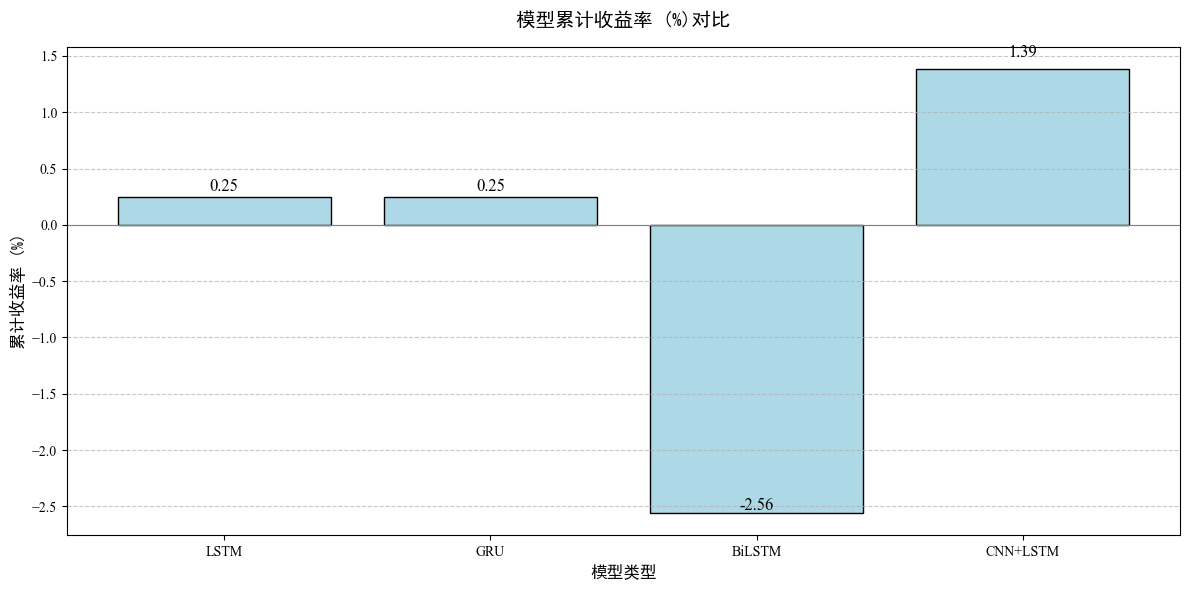

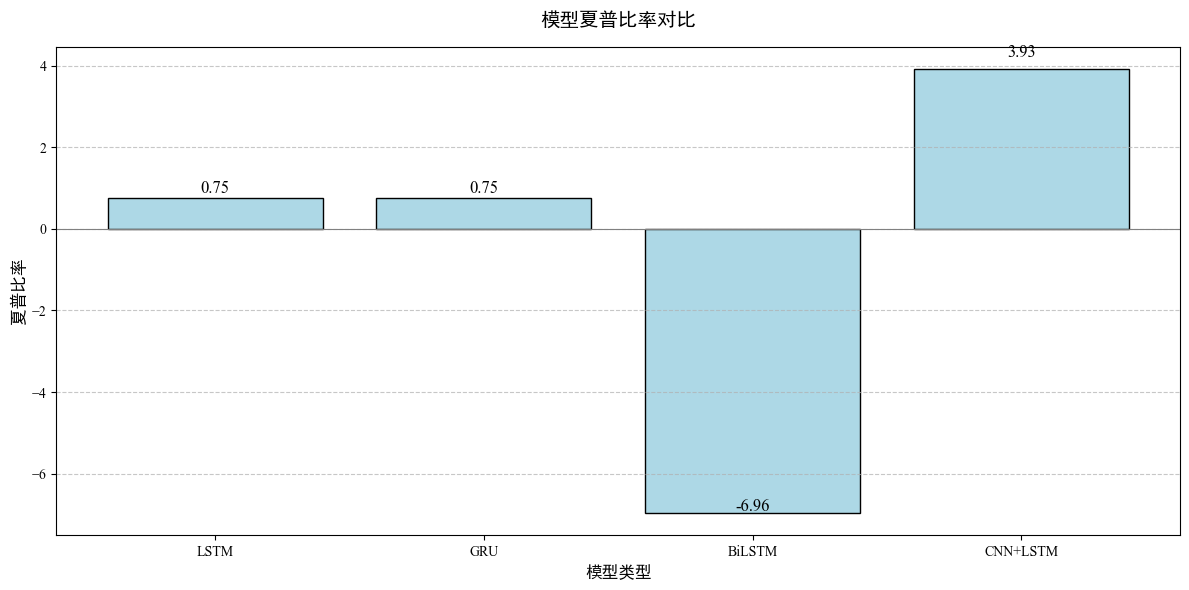

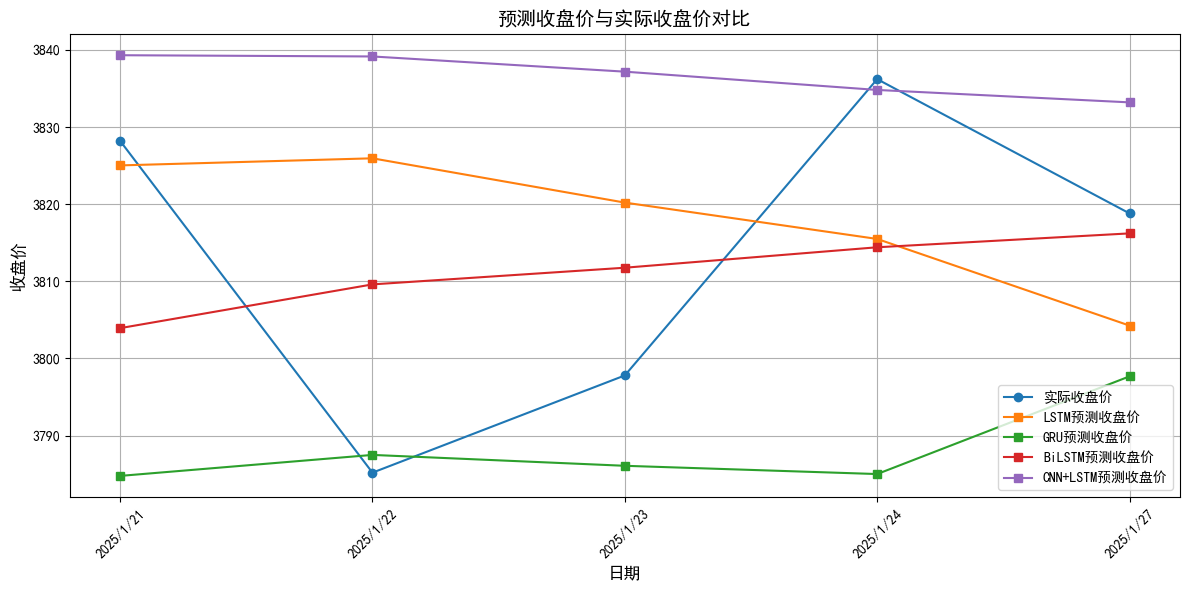


模型性能对比报告:
+----------+------------------+------------+
|   模型   |  累计收益率 (%)  |  夏普比率  |
+==========+==================+============+
|   LSTM   |      0.25%       |    0.75    |
+----------+------------------+------------+
|   GRU    |      0.25%       |    0.75    |
+----------+------------------+------------+
|  BiLSTM  |      -2.56%      |   -6.96    |
+----------+------------------+------------+
| CNN+LSTM |      1.39%       |    3.93    |
+----------+------------------+------------+


In [4]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# 原始数据准备部分保持不变
actual_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24", "2025/1/27"],
    "实际收盘价": [3828.20, 3785.20, 3797.80, 3836.20, 3818.80],
    "实际涨跌幅(%)": [-0.02, -1.12, 0.33, 1.01, -2.76]
}

lstm_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24",  "2025/1/27"],
    "预测收盘价": [3825.02, 3825.94, 3820.20, 3815.49,  3804.26],
    "预测涨跌幅(%)": [np.nan, 0.02, -0.15, -0.12, -0.09]
}

gru_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24", "2025/1/27"],
    "预测收盘价": [3784.78, 3787.50, 3786.09, 3785.02,  3797.68],
    "预测涨跌幅(%)": [np.nan, 0.07, -0.04, -0.03,  -0.01]
}

bilstm_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24", "2025/1/27"],
    "预测收盘价": [3803.93, 3809.60, 3811.76, 3814.41, 3816.21],
    "预测涨跌幅(%)": [np.nan, 0.15, 0.06, 0.07, 0.05]
}

cnnbilstm_data = {
    "日期": ["2025/1/21", "2025/1/22", "2025/1/23", "2025/1/24",  "2025/1/27"],
    "预测收盘价": [3839.30, 3839.14, 3837.17, 3834.80, 3833.19],
    "预测涨跌幅(%)": [np.nan, -0.00, -0.05, -0.06,  -0.01]
}

# 数据对齐处理
df_actual = pd.DataFrame(actual_data)
df_lstm = pd.DataFrame(lstm_data).merge(df_actual[["日期"]], on="日期")
df_gru = pd.DataFrame(gru_data).merge(df_actual[["日期"]], on="日期")
df_bilstm = pd.DataFrame(bilstm_data).merge(df_actual[["日期"]], on="日期")
df_cnnbilstm = pd.DataFrame(cnnbilstm_data).merge(df_actual[["日期"]], on="日期")

# 指标计算函数优化
def calculate_metrics(df_pred, df_actual):
    df = df_pred.merge(df_actual, on="日期")
    df["实际涨跌幅(%)"] = df["实际涨跌幅(%)"] / 100
    df["预测涨跌幅(%)"] = df["预测涨跌幅(%)"].fillna(0) / 100  # 处理缺失值

    returns = []
    for i in range(1, len(df)):
        pred_dir = np.sign(df["预测涨跌幅(%)"].iloc[i])
        actual_ret = df["实际涨跌幅(%)"].iloc[i]
        returns.append(pred_dir * actual_ret)

    cumulative_return = (np.prod(1 + np.array(returns)) - 1) * 100
    sharpe = np.mean(returns)/np.std(returns)*np.sqrt(252) if len(returns) > 1 else 0

    return {
        "累计收益率 (%)": cumulative_return,
        "夏普比率": sharpe
    }

# 计算各模型指标
model_frames = {
    "LSTM": df_lstm,
    "GRU": df_gru,
    "BiLSTM": df_bilstm,
    "CNN+LSTM": df_cnnbilstm
}

metrics = {model: calculate_metrics(df, df_actual) for model, df in model_frames.items()}

# 可视化函数
def plot_metric_comparison(metric_name, color_map):
    """
    通用指标可视化函数
    :param metric_name: 指标名称（'累计收益率 (%)' 或 '夏普比率'）
    :param color_map: 颜色映射字典
    """
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    values = [metrics[model][metric_name] for model in model_frames]
    colors = [color_map[value > 0] for value in values]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_frames.keys(), values, color=colors, edgecolor='black')

    # 添加数据标签
    for bar in bars:
        yval = bar.get_height()
        label_pos = yval * 1.05 if yval >= 0 else yval * 0.95
        plt.text(bar.get_x() + bar.get_width() / 2,
                 label_pos,
                 f'{yval:.2f}',
                 ha='center',
                 va='bottom' if yval >= 0 else 'top',
                 fontsize=12,
                 fontfamily='Times New Roman')

    # 图表装饰
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.title(f'模型{metric_name}对比', fontsize=14, pad=15)
    plt.xlabel('模型类型', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontname='Times New Roman')
    plt.yticks(fontname='Times New Roman')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 生成可视化图表
plot_metric_comparison(
    metric_name='累计收益率 (%)',
    color_map={True: 'lightblue', False: 'lightblue'}
)

plot_metric_comparison(
    metric_name='夏普比率',
    color_map={True: 'lightblue', False: 'lightblue'}
)

# 绘制预测值与真实值的折线图
plt.figure(figsize=(12, 6))
plt.plot(df_actual["日期"], df_actual["实际收盘价"], label="实际收盘价", marker='o')
for model, df in model_frames.items():
    plt.plot(df["日期"], df["预测收盘价"], label=f"{model}预测收盘价", marker='s')

plt.title("预测收盘价与实际收盘价对比", fontsize=14)
plt.xlabel("日期", fontsize=12)
plt.ylabel("收盘价", fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 生成表格报告
table_data = [
    [model,
     f'{values["累计收益率 (%)"]:.2f}%',
     f'{values["夏普比率"]:.2f}']
    for model, values in metrics.items()
]

print("\n模型性能对比报告:")
print(tabulate(table_data,
               headers=["模型", "累计收益率 (%)", "夏普比率"],
               tablefmt="grid",
               stralign="center",
               numalign="center"))


## 8.1 模型应用


In [27]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
from tabulate import tabulate

# 加载所有模型
models = {
    'LSTM': load_model('lstm_model.h5'),
    'GRU': load_model('GRU_model.h5'),
    'CNN+LSTM': load_model('CNN+LSTM_model.h5'),
    'BiLSTM': load_model('BiLSTM_model.h5')
}

# 加载特征和目标归一化器
feature_scaler = joblib.load('feature_scaler.pkl')
target_scaler = joblib.load('target_scaler.pkl')

# 加载新数据
new_data = pd.read_csv('沪深300期货历史数据 (7).csv')

# 数据格式转换
new_data['日期'] = new_data['日期'].str.replace('-', '/')

# 去除收盘、开盘、高、低列中的逗号
columns_to_clean = ['收盘', '开盘', '高', '低']
for col in columns_to_clean:
    new_data[col] = new_data[col].str.replace(',', '').astype(float)

# 去除涨跌幅列的百分号并转换为小数
new_data['涨跌幅'] = new_data['涨跌幅'].str.rstrip('%').astype(float) / 100

# 去除交易量列的 'K' 并转换为数值
new_data['交易量'] = new_data['交易量'].str.rstrip('K').astype(float) * 1000

# 设置日期索引并排序
new_data = new_data.set_index('日期')[['开盘', '高', '低', '收盘']].sort_index().astype('float')

# 提取最新window_size长度的数据
window_size = 9 
latest_data = new_data.iloc[-window_size:].copy()  

# 定义预测天数
forecast_days =5

# 存储每个模型的预测结果和涨跌幅
all_forecasted_results = {}

for model_name, model in models.items():
    # 重置 latest_data 用于每个模型的预测
    current_latest_data = latest_data.copy()
    # 存储当前模型的预测结果、日期和涨跌幅
    forecasted_prices = []
    forecasted_dates = []
    forecasted_changes = []
    # 获取最新日期
    latest_date = pd.to_datetime(current_latest_data.index[-1], format='%Y/%m/%d')

    for i in range(forecast_days):
        # 1. 特征归一化
        X_new_raw = current_latest_data[['开盘', '高', '低']].values  
        X_new_scaled = feature_scaler.transform(X_new_raw)  

        # 2. 目标列归一化
        close_prices = current_latest_data['收盘'].values.reshape(-1, 1)
        y_new_scaled = target_scaler.transform(close_prices)  # 使用训练时的 y_scaler

        # 3. 合并为与训练时相同的格式 [X, y]
        processed_data = np.c_[X_new_scaled, y_new_scaled]

        # 4. 构建输入序列
        def build_pred_sequence(data, window_size):
            return np.array([data[-window_size:]])

        X_pred = build_pred_sequence(processed_data, window_size)

        # 进行预测
        prediction = model.predict(X_pred)

        # 反归一化预测结果
        prediction = target_scaler.inverse_transform(prediction)

        # 存储预测结果
        forecasted_prices.append(prediction[0][0])

        # 计算涨跌幅
        if i == 0:
            prev_close = current_latest_data['收盘'].iloc[-1]
        else:
            prev_close = forecasted_prices[i - 1]
        change = ((prediction[0][0] - prev_close) / prev_close) * 100
        forecasted_changes.append(change)

        # 生成预测日期
        next_date = latest_date + pd.Timedelta(days=1)
        forecasted_dates.append(next_date.strftime('%Y/%m/%d'))
        latest_date = next_date

        # 更新 current_latest_data 用于下一次预测
        last_row = current_latest_data.iloc[-1].copy()
        last_row['开盘'] = last_row['收盘']  
        last_row['高'] = prediction[0][0]  
        last_row['低'] = prediction[0][0]  
        last_row['收盘'] = prediction[0][0]
        current_latest_data = pd.concat([current_latest_data[1:], pd.DataFrame([last_row], index=[next_date.strftime('%Y/%m/%d')])])

    all_forecasted_results[model_name] = (forecasted_dates, forecasted_prices, forecasted_changes)

# 准备第一个表格数据（LSTM 和 CNN+LSTM）
table1_data = []
table1_headers = ['日期', 'LSTM 收盘价', 'LSTM 涨跌幅(%)', 'CNN+LSTM 收盘价', 'CNN+LSTM 涨跌幅(%)']

for i in range(forecast_days):
    row = [all_forecasted_results['LSTM'][0][i]]
    row.extend([all_forecasted_results['LSTM'][1][i], all_forecasted_results['LSTM'][2][i]])
    row.extend([all_forecasted_results['CNN+LSTM'][1][i], all_forecasted_results['CNN+LSTM'][2][i]])
    table1_data.append(row)

# 准备第二个表格数据（GRU 和 BiLSTM）
table2_data = []
table2_headers = ['日期', 'GRU 收盘价', 'GRU 涨跌幅(%)', 'BiLSTM 收盘价', 'BiLSTM 涨跌幅(%)']

for i in range(forecast_days):
    row = [all_forecasted_results['GRU'][0][i]]
    row.extend([all_forecasted_results['GRU'][1][i], all_forecasted_results['GRU'][2][i]])
    row.extend([all_forecasted_results['BiLSTM'][1][i], all_forecasted_results['BiLSTM'][2][i]])
    table2_data.append(row)

# 输出第一个表格
print("预测价格表格（LSTM 和 CNN+LSTM）：")
print(tabulate(table1_data, headers=table1_headers, tablefmt='grid'))

# 输出第二个表格
print("\n预测价格表格（GRU 和 BiLSTM）：")
print(tabulate(table2_data, headers=table2_headers, tablefmt='grid'))

1/1 [==============================] - 0s 16ms/step
预测价格表格（LSTM 和 CNN+LSTM）：
+------------+---------------+------------------+-------------------+----------------------+
| 日期       |   LSTM 收盘价 |   LSTM 涨跌幅(%) |   CNN+LSTM 收盘价 |   CNN+LSTM 涨跌幅(%) |
+============+===============+==================+===================+======================+
| 2025/03/08 |       3953.21 |        0.264142  |           3954.85 |           0.305679   |
+------------+---------------+------------------+-------------------+----------------------+
| 2025/03/09 |       3953.96 |        0.0189163 |           3955.2  |           0.00874741 |
+------------+---------------+------------------+-------------------+----------------------+
| 2025/03/10 |       3951.69 |       -0.05751   |           3955.39 |           0.00484553 |
+------------+---------------+------------------+-------------------+----------------------+
| 2025/03/11 |       3949.76 |       -0.0487702 |           3952.23 |          -0.0799875  |
+------